In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import skimage
import math
from skimage.io import imsave, imread
from skimage.transform import resize
from PIL import Image
from shutil import copyfile
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.optimizers import SGD, Adadelta, Adam
from keras.applications.mobilenet import MobileNet
from keras_squeezenet import SqueezeNet
from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2

from keras.layers import BatchNormalization
from keras.optimizers import RMSprop

from keras.utils import np_utils


%matplotlib inline

C:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from preprocess import load_dir, preprocess_and_save_images, divide_to_train_end_test
from custom_metrics import precision, recall, fmeasure

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

In [4]:
%%time
# Firstly load all datasets

X_128_F_ByShape, y_128_F_ByShape = load_dir("D:/svruchtel/PREPROCESSED_DATA/03_France_ByShape_128_3dim",
                                            ["A4", "Slip", "Ticket"],
                                            already_transformed=True)   

X_160_F_ByShape, y_160_F_ByShape = load_dir("D:/svruchtel/PREPROCESSED_DATA/03_France_ByShape_160_3dim",
                                            ["A4", "Slip", "Ticket"],
                                            already_transformed=True)   

X_192_F_ByShape, y_192_F_ByShape = load_dir("D:/svruchtel/PREPROCESSED_DATA/03_France_ByShape_192_3dim",
                                            ["A4", "Slip", "Ticket"],
                                            already_transformed=True)   

X_224_F_ByShape, y_224_F_ByShape = load_dir("D:/svruchtel/PREPROCESSED_DATA/03_France_ByShape_224_3dim",
                                            ["A4", "Slip", "Ticket"],
                                            already_transformed=True)   


Wall time: 15.6 s


In [5]:
%%time

#Than divide all of them to train and test

X_train_128_FS, y_train_128_FS, X_test_128_FS, y_test_128_FS = divide_to_train_end_test(X_128_F_ByShape,
                                                                                        y_128_F_ByShape, num_categories=3)
X_train_160_FS, y_train_160_FS, X_test_160_FS, y_test_160_FS = divide_to_train_end_test(X_160_F_ByShape,
                                                                                        y_160_F_ByShape, num_categories=3)
X_train_192_FS, y_train_192_FS, X_test_192_FS, y_test_192_FS = divide_to_train_end_test(X_192_F_ByShape,
                                                                                        y_192_F_ByShape, num_categories=3)
X_train_224_FS, y_train_224_FS, X_test_224_FS, y_test_224_FS = divide_to_train_end_test(X_224_F_ByShape,
                                                                                        y_224_F_ByShape, num_categories=3)


Wall time: 899 ms


In [6]:
# Create two pandas tables
# One with parameters, and one - with results

parameters_df = pd.DataFrame(columns=['net_name', 'dataset_name', 'train_or_test', 'image_size', 'batch_size_app',
                                      'batch_size_small_net', 'dense_1', 'dense_2', 'activation_1', 'activation_2', 'optimiser'])
results_df = pd.DataFrame(columns=['net_name', 'dataset_name', 'train_or_test',
                                   'loss', 'accuracy', 'precision', 'recall', 'fmeasure'])


In [4]:
def shuffle_Xy(X, y):
    perm = np.random.permutation(len(X))
    return np.array(X)[perm], np.array(y)[perm]

In [5]:
def create_net_with_name(net_name, X_train):
    if net_name == 'MobileNet':
        return MobileNet(input_shape=X_train[0].shape, include_top=False)
    if net_name == 'SqueezeNet':
        return SqueezeNet(input_shape=X_train[0].shape, include_top=False)
    if net_name == 'Xception':
        return Xception(input_shape=X_train[0].shape, include_top=False)
    if net_name == 'VGG16':
        return VGG16(input_shape=X_train[0].shape, include_top=False)
    if net_name == 'VGG19':
        return VGG19(input_shape=X_train[0].shape, include_top=False)
    if net_name == 'ResNet50':
        return ResNet50(input_shape=X_train[0].shape, include_top=False)
    if net_name == 'InceptionV3':
        return InceptionV3(input_shape=X_train[0].shape, include_top=False)
    if net_name == 'InceptionResNetV2':
        return InceptionResNetV2(input_shape=X_train[0].shape, include_top=False)    
    

In [6]:
def one_hot(y, classes_count):
    return np.eye(classes_count)[y]

print(np.eye(4)[[1, 2, 3, 0]])

[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


In [7]:
y_train_128_FS

NameError: name 'y_train_128_FS' is not defined

In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [8]:
def create_and_run_net(net_name, categories_count, X_train, y_train, X_test, y_test, batch_size_small_net, dense_1, dense_2, epoch_count):
    
    X_train_shuffled, y_train_shuffled = shuffle_Xy(X_train, y_train)
    
    model_app = create_net_with_name(net_name, X_train_shuffled)
    model_app.trainable = False

    model = Sequential()
    model.add(model_app)
    model.add(Flatten())
    model.add(Dropout(0.5))
    
    #model.add(Dropout(0.8))
    #model.add(Dense(dense_1, activation='relu'))
    #model.add(Dropout(0.6))
    #model.add(Dense(dense_2, activation='relu'))
    #model.add(Dropout(0.4))
    model.add(Dense(categories_count, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', precision, recall, fmeasure])
    callback = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto')
    history_callback = model.fit(X_train_shuffled, one_hot(y_train_shuffled, categories_count),
                                 epochs=epoch_count, batch_size=batch_size_small_net, callbacks=[callback])
    
    scores_test = model.evaluate(X_test, one_hot(y_test, categories_count))
    
    ### CONFUSION MATRIX 
    
    y_pred_train = model.predict(X_train)
    cnf_matrix = confusion_matrix(one_hot(y_train, categories_count).argmax(axis=1), (y_pred_train.round()).argmax(axis=1))

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=range(categories_count),
                      title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=range(categories_count), normalize=True,
                      title='Normalized confusion matrix')

    plt.show()

    y_pred_test = model.predict(X_test)
    cnf_matrix = confusion_matrix(one_hot(y_test, categories_count).argmax(axis=1), (y_pred_test.round()).argmax(axis=1))

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=range(categories_count),
                      title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=range(categories_count), normalize=True,
                      title='Normalized confusion matrix')

    plt.show()
    
    
    return history_callback, scores_test


In [9]:
def run_net_and_write_result(parameters_df, results_df, net_name, dataset_name, categories_count, image_size, X_train, y_train, X_test, y_test,
                            batch_size_small_net, dense_1, dense_2, epoch_count):
    history_callback, scores_test = create_and_run_net(net_name, categories_count, X_train, y_train, X_test, y_test, batch_size_small_net,
                                                      dense_1, dense_2, epoch_count)
    
    loss_best = min(history_callback.history['loss'])
    accuracy_best = max(history_callback.history['acc'])
    precision_best = max(history_callback.history['precision'])
    recall_best = max(history_callback.history['recall'])
    fmeasure_best = max(history_callback.history['fmeasure'])
    
    # write in dataframes
    parameters = {'net_name':net_name, 'dataset_name':dataset_name, 
                  'train_or_test':'train', 'image_size':image_size, 
                  'batch_size_app':-1, 'batch_size_small_net':batch_size_small_net, 'dense_1':dense_1, 'dense_2':dense_2,
                  'activation_1':'relu', 'activation_2':'relu', 'optimiser':'adam'}
    parameters_df = parameters_df.append(parameters, ignore_index=True)
    results = {'net_name':net_name,'dataset_name':dataset_name, 'train_or_test':'train',
               'loss':loss_best, 'accuracy':accuracy_best, 'precision':precision_best,
               'recall':recall_best, 'fmeasure':fmeasure_best}
    results_df = results_df.append(results, ignore_index=True)
    
    # evaluate on test
    parameters = {'net_name':net_name, 'dataset_name':dataset_name, 
                  'train_or_test':'test', 'image_size':image_size, 
                  'batch_size_app':-1, 'batch_size_small_net':batch_size_small_net, 'dense_1':dense_1, 'dense_2':dense_2,
                  'activation_1':'relu', 'activation_2':'relu', 'optimiser':'adam'}
    parameters_df = parameters_df.append(parameters, ignore_index=True)
    results = {'net_name':net_name,'dataset_name':dataset_name, 'train_or_test':'test',
               'loss':scores_test[0], 'accuracy':scores_test[1],
               'precision':scores_test[2], 'recall':scores_test[3], 'fmeasure':scores_test[4]}
    results_df = results_df.append(results, ignore_index=True)
    
    parameters_df.to_csv('./PARAMETERS_AND_RESULTS/04_04_params_France_WithoutRetrain.csv', sep='\t')
    results_df.to_csv('./PARAMETERS_AND_RESULTS/04_04_results_France_WithoutRetrain.csv', sep='\t')
    
    return parameters_df, results_df
    

In [45]:
%%time
## MobileNet, 128

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='MobileNet',
                                                    categories_count=3,
                                                    dataset_name='03_France_ByShape_128_3dim',
                                                    image_size=128, X_train=X_train_128_FS, y_train=y_train_128_FS,
                                                    X_test=X_test_128_FS, y_test=y_test_128_FS,
                                                    batch_size_small_net=100, dense_1=200, dense_2=30,
                                                    epoch_count=200)

Epoch 1/200
3234/3234 [==============================] - 14s 4ms/step - loss: 2.4537 - acc: 0.7171 - precision: 0.7225 - recall: 0.7075 - fmeasure: 0.7148
Epoch 2/200
3234/3234 [==============================] - 5s 1ms/step - loss: 0.8719 - acc: 0.7801 - precision: 0.8015 - recall: 0.7180 - fmeasure: 0.7571
Epoch 3/200
3234/3234 [==============================] - 5s 1ms/step - loss: 0.6087 - acc: 0.8268 - precision: 0.8506 - recall: 0.7783 - fmeasure: 0.8126
Epoch 4/200
3234/3234 [==============================] - 5s 2ms/step - loss: 0.4759 - acc: 0.8544 - precision: 0.8766 - recall: 0.8231 - fmeasure: 0.8488
Epoch 5/200
3234/3234 [==============================] - 5s 1ms/step - loss: 0.4289 - acc: 0.8655 - precision: 0.8852 - recall: 0.8469 - fmeasure: 0.8655
Epoch 6/200
3234/3234 [==============================] - 5s 2ms/step - loss: 0.3479 - acc: 0.8828 - precision: 0.9033 - recall: 0.8652 - fmeasure: 0.8837
Epoch 7/200
3234/3234 [==============================] - 5s 2ms/step - loss

In [46]:
%%time
## MobileNet, 160

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='MobileNet',
                                                    categories_count=3,
                                                    dataset_name='03_France_ByShape_160_3dim',
                                                    image_size=160, X_train=X_train_160_FS, y_train=y_train_160_FS,
                                                    X_test=X_test_160_FS, y_test=y_test_160_FS,
                                                    batch_size_small_net=100, dense_1=200, dense_2=30,
                                                    epoch_count=200)

Epoch 1/200
3234/3234 [==============================] - 18s 6ms/step - loss: 3.0880 - acc: 0.7904 - precision: 0.7908 - recall: 0.7904 - fmeasure: 0.7906
Epoch 2/200
3234/3234 [==============================] - 7s 2ms/step - loss: 2.9765 - acc: 0.8135 - precision: 0.8135 - recall: 0.8135 - fmeasure: 0.8135
Epoch 3/200
3234/3234 [==============================] - 7s 2ms/step - loss: 2.9766 - acc: 0.8132 - precision: 0.8132 - recall: 0.8132 - fmeasure: 0.8132
Epoch 4/200
3234/3234 [==============================] - 7s 2ms/step - loss: 2.9828 - acc: 0.8142 - precision: 0.8142 - recall: 0.8142 - fmeasure: 0.8142
Epoch 5/200
3234/3234 [==============================] - 7s 2ms/step - loss: 2.9691 - acc: 0.8148 - precision: 0.8148 - recall: 0.8148 - fmeasure: 0.8148
Epoch 6/200
3234/3234 [==============================] - 7s 2ms/step - loss: 2.9708 - acc: 0.8145 - precision: 0.8145 - recall: 0.8145 - fmeasure: 0.8145
Epoch 7/200
3234/3234 [==============================] - 7s 2ms/step - loss

In [47]:
%%time
## MobileNet, 192

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='MobileNet',
                                                    categories_count=3,
                                                    dataset_name='03_France_ByShape_192_3dim',
                                                    image_size=192, X_train=X_train_192_FS, y_train=y_train_192_FS,
                                                    X_test=X_test_192_FS, y_test=y_test_192_FS,
                                                    batch_size_small_net=100, dense_1=200, dense_2=30,
                                                    epoch_count=200)

Epoch 1/200
3234/3234 [==============================] - 20s 6ms/step - loss: 3.0156 - acc: 0.7978 - precision: 0.7979 - recall: 0.7978 - fmeasure: 0.7978
Epoch 2/200
3234/3234 [==============================] - 9s 3ms/step - loss: 2.9706 - acc: 0.8145 - precision: 0.8145 - recall: 0.8145 - fmeasure: 0.8145
Epoch 3/200
3234/3234 [==============================] - 9s 3ms/step - loss: 2.9596 - acc: 0.8135 - precision: 0.8135 - recall: 0.8135 - fmeasure: 0.8135
Epoch 4/200
3234/3234 [==============================] - 9s 3ms/step - loss: 2.9741 - acc: 0.8135 - precision: 0.8137 - recall: 0.8132 - fmeasure: 0.8135
Epoch 5/200
3234/3234 [==============================] - 9s 3ms/step - loss: 2.9780 - acc: 0.8126 - precision: 0.8126 - recall: 0.8123 - fmeasure: 0.8124
Epoch 6/200
3234/3234 [==============================] - 9s 3ms/step - loss: 2.9367 - acc: 0.8157 - precision: 0.8157 - recall: 0.8157 - fmeasure: 0.8157
Epoch 7/200
3234/3234 [==============================] - 9s 3ms/step - loss

In [13]:
parameters_df = pd.read_csv('./PARAMETERS_AND_RESULTS/04_04_params_France_WithoutRetrain.csv', sep='\t', index_col=0)
results_df = pd.read_csv('./PARAMETERS_AND_RESULTS/04_04_results_France_WithoutRetrain.csv', sep='\t', index_col=0)

In [14]:
## MobileNet, 224

In [15]:
X_train_shuffled, y_train_shuffled = shuffle_Xy(X_train_224_FS, y_train_224_FS)

In [47]:
model_app = create_net_with_name('MobileNet', X_train_shuffled)
model_app.trainable = False

In [48]:
model = Sequential()
model.add(model_app)
model.add(Flatten())
model.add(Dropout(0.6))
model.add(Dense(3, activation='softmax'))

In [49]:
%%time
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', precision, recall, fmeasure])
callback = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=8, verbose=0, mode='auto')
history_callback = model.fit(X_train_shuffled, one_hot(y_train_shuffled, 3),
                                 epochs=200, batch_size=4, callbacks=[callback])

Epoch 1/200
3234/3234 [==============================] - 53s 16ms/step - loss: 2.9753 - acc: 0.8139 - precision: 0.8140 - recall: 0.8139 - fmeasure: 0.8139
Epoch 2/200
3234/3234 [==============================] - 51s 16ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 3/200
3234/3234 [==============================] - 51s 16ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 4/200
3234/3234 [==============================] - 51s 16ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 5/200
3234/3234 [==============================] - 51s 16ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 6/200
1604/3234 [=============>................] - ETA: 25s - loss: 2.8739 - acc: 0.8217 - precision: 0.8217 - recall: 0.8217 - fmeasure: 0.8217

KeyboardInterrupt: 

In [25]:
scores_test = model.evaluate(X_test_224_FS, one_hot(y_test_224_FS, 3))

362/362 [==============================] - 2s 7ms/step


In [27]:
loss_best = min(history_callback.history['loss'])
accuracy_best = max(history_callback.history['acc'])
precision_best = max(history_callback.history['precision'])
recall_best = max(history_callback.history['recall'])
fmeasure_best = max(history_callback.history['fmeasure'])
    
# write in dataframes
parameters = {'net_name':'MobileNet', 'dataset_name':'03_France_ByShape_224_3dim', 
              'train_or_test':'train', 'image_size':224, 
              'batch_size_app':-1, 'batch_size_small_net':4, 'dense_1':-1, 'dense_2':-1,
              'activation_1':'dropout 0.9', 'activation_2':'-1', 'optimiser':'adam'}
parameters_df = parameters_df.append(parameters, ignore_index=True)
results = {'net_name':'MobileNet','dataset_name':'03_France_ByShape_224_3dim', 'train_or_test':'train',
           'loss':loss_best, 'accuracy':accuracy_best, 'precision':precision_best,
           'recall':recall_best, 'fmeasure':fmeasure_best}
results_df = results_df.append(results, ignore_index=True)
    
# evaluate on test
parameters = {'net_name':'MobileNet', 'dataset_name':'03_France_ByShape_224_3dim', 
              'train_or_test':'test', 'image_size':224, 
              'batch_size_app':-1, 'batch_size_small_net':4, 'dense_1':-1, 'dense_2':-1,
              'activation_1':'dropout 0.9', 'activation_2':'-1', 'optimiser':'adam'}
parameters_df = parameters_df.append(parameters, ignore_index=True)
results = {'net_name':'MobileNet','dataset_name':'03_France_ByShape_224_3dim', 'train_or_test':'test',
          'loss':scores_test[0], 'accuracy':scores_test[1],
          'precision':scores_test[2], 'recall':scores_test[3], 'fmeasure':scores_test[4]}
results_df = results_df.append(results, ignore_index=True)
    
parameters_df.to_csv('./PARAMETERS_AND_RESULTS/04_04_params_France_WithoutRetrain.csv', sep='\t')
results_df.to_csv('./PARAMETERS_AND_RESULTS/04_04_results_France_WithoutRetrain.csv', sep='\t')
    

Confusion matrix, without normalization
[[  61  254    0]
 [ 126 2511    0]
 [  27  255    0]]
Normalized confusion matrix
[[0.19365079 0.80634921 0.        ]
 [0.04778157 0.95221843 0.        ]
 [0.09574468 0.90425532 0.        ]]


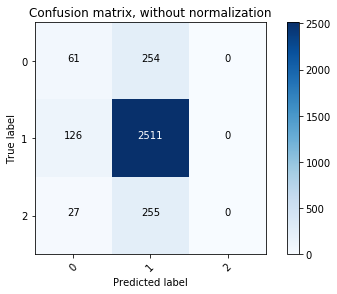

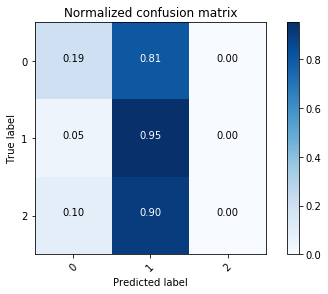

In [43]:
y_pred_train = model.predict(X_train_224_FS)
cnf_matrix = confusion_matrix(one_hot(y_train_224_FS, 3).argmax(axis=1), (y_pred_train.round()).argmax(axis=1))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(3),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(3), normalize=True,
                      title='Normalized confusion matrix')

plt.show()



Confusion matrix, without normalization
[[  3  33   0]
 [ 11 283   0]
 [  7  25   0]]
Normalized confusion matrix
[[0.08333333 0.91666667 0.        ]
 [0.03741497 0.96258503 0.        ]
 [0.21875    0.78125    0.        ]]


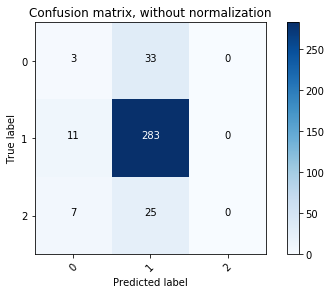

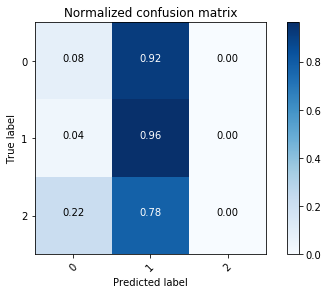

In [42]:
y_pred_test = model.predict(X_test_224_FS)
cnf_matrix = confusion_matrix(one_hot(y_test_224_FS, 3).argmax(axis=1), (y_pred_test.round()).argmax(axis=1))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2], normalize=True,
                      title='Normalized confusion matrix')

plt.show()



In [46]:
y_pred_test.round().argmax(axis=1)

array([0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

Epoch 1/200
3234/3234 [==============================] - 42s 13ms/step - loss: 2.9831 - acc: 0.8148 - precision: 0.8148 - recall: 0.8148 - fmeasure: 0.8148
Epoch 2/200
3234/3234 [==============================] - 41s 13ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 3/200
3234/3234 [==============================] - 40s 12ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 4/200
3234/3234 [==============================] - 40s 12ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 5/200
3234/3234 [==============================] - 40s 13ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 6/200
3234/3234 [==============================] - 40s 12ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 7/200
3234/3234 [==============================] - 40s 12m

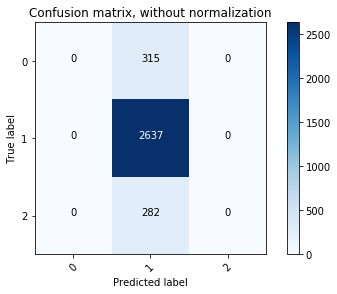

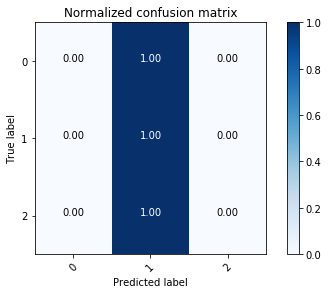

Confusion matrix, without normalization
[[  0  36   0]
 [  0 294   0]
 [  0  32   0]]
Normalized confusion matrix
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


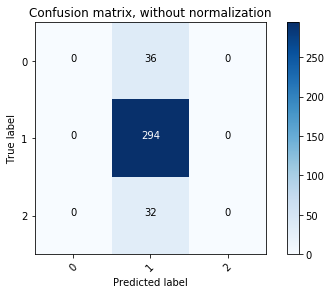

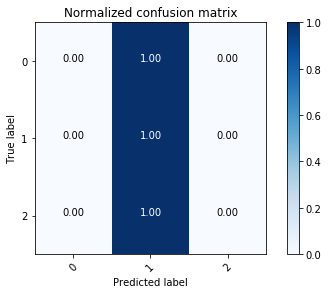

Wall time: 12min 14s


In [55]:
%%time
## SqueezeNet, 128

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='SqueezeNet',
                                                    categories_count=3,
                                                    dataset_name='03_France_ByShape_128_3dim',
                                                    image_size=128, X_train=X_train_128_FS, y_train=y_train_128_FS,
                                                    X_test=X_test_128_FS, y_test=y_test_128_FS,
                                                    batch_size_small_net=3, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3234/3234 [==============================] - 31s 9ms/step - loss: 2.8872 - acc: 0.8197 - precision: 0.8197 - recall: 0.8197 - fmeasure: 0.8197
Epoch 2/200
3234/3234 [==============================] - 28s 9ms/step - loss: 2.7384 - acc: 0.8281 - precision: 0.8281 - recall: 0.8281 - fmeasure: 0.8281
Epoch 3/200
3234/3234 [==============================] - 28s 9ms/step - loss: 2.4414 - acc: 0.8472 - precision: 0.8472 - recall: 0.8472 - fmeasure: 0.8472
Epoch 4/200
3234/3234 [==============================] - 28s 9ms/step - loss: 2.6358 - acc: 0.8336 - precision: 0.8336 - recall: 0.8336 - fmeasure: 0.8336
Epoch 5/200
3234/3234 [==============================] - 27s 8ms/step - loss: 2.4937 - acc: 0.8448 - precision: 0.8448 - recall: 0.8448 - fmeasure: 0.8448
Epoch 6/200
3234/3234 [==============================] - 27s 8ms/step - loss: 2.5562 - acc: 0.8414 - precision: 0.8414 - recall: 0.8414 - fmeasure: 0.8414
Epoch 7/200
3234/3234 [==============================] - 27s 8ms/step 

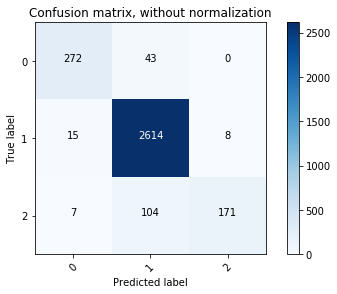

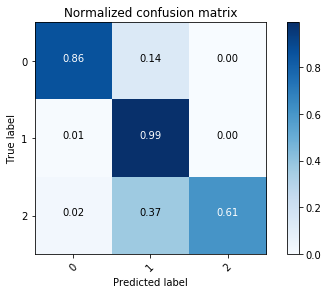

Confusion matrix, without normalization
[[ 26  10   0]
 [  3 288   3]
 [  0  12  20]]
Normalized confusion matrix
[[0.72222222 0.27777778 0.        ]
 [0.01020408 0.97959184 0.01020408]
 [0.         0.375      0.625     ]]


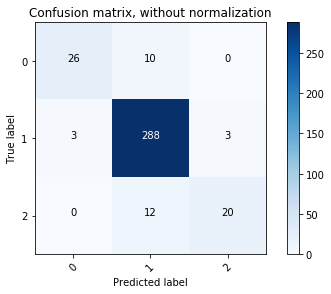

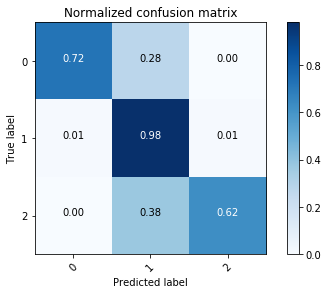

Wall time: 14min 15s


In [56]:
%%time
## SqueezeNet, 160

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='SqueezeNet',
                                                    categories_count=3,
                                                    dataset_name='03_France_ByShape_160_3dim',
                                                    image_size=160, X_train=X_train_160_FS, y_train=y_train_160_FS,
                                                    X_test=X_test_160_FS, y_test=y_test_160_FS,
                                                    batch_size_small_net=5, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3234/3234 [==============================] - 20s 6ms/step - loss: 3.0646 - acc: 0.8077 - precision: 0.8077 - recall: 0.8077 - fmeasure: 0.8077
Epoch 2/200
3234/3234 [==============================] - 17s 5ms/step - loss: 2.5692 - acc: 0.8395 - precision: 0.8395 - recall: 0.8395 - fmeasure: 0.8395
Epoch 3/200
3234/3234 [==============================] - 17s 5ms/step - loss: 2.5294 - acc: 0.8423 - precision: 0.8423 - recall: 0.8423 - fmeasure: 0.8423
Epoch 4/200
3234/3234 [==============================] - 17s 5ms/step - loss: 2.4696 - acc: 0.8466 - precision: 0.8466 - recall: 0.8466 - fmeasure: 0.8466
Epoch 5/200
3234/3234 [==============================] - 17s 5ms/step - loss: 2.3164 - acc: 0.8547 - precision: 0.8547 - recall: 0.8547 - fmeasure: 0.8547
Epoch 6/200
3234/3234 [==============================] - 17s 5ms/step - loss: 2.3519 - acc: 0.8534 - precision: 0.8534 - recall: 0.8534 - fmeasure: 0.8534
Epoch 7/200
3234/3234 [==============================] - 17s 5ms/step 

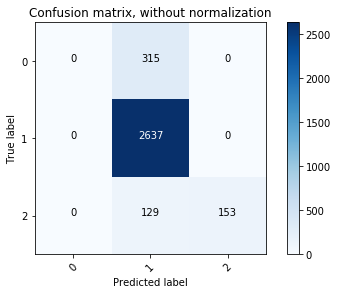

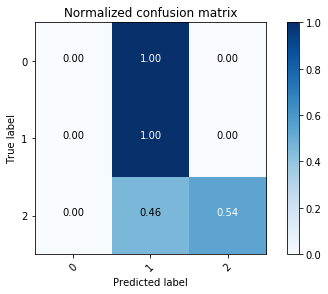

Confusion matrix, without normalization
[[  0  36   0]
 [  0 294   0]
 [  0  19  13]]
Normalized confusion matrix
[[0.      1.      0.     ]
 [0.      1.      0.     ]
 [0.      0.59375 0.40625]]


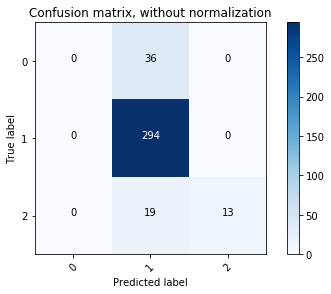

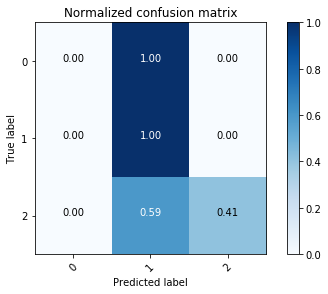

Wall time: 16min 52s


In [57]:
%%time
## SqueezeNet, 192

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='SqueezeNet',
                                                    categories_count=3,
                                                    dataset_name='03_France_ByShape_192_3dim',
                                                    image_size=192, X_train=X_train_192_FS, y_train=y_train_192_FS,
                                                    X_test=X_test_192_FS, y_test=y_test_192_FS,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3234/3234 [==============================] - 22s 7ms/step - loss: 2.9835 - acc: 0.8139 - precision: 0.8139 - recall: 0.8139 - fmeasure: 0.8139
Epoch 2/200
3234/3234 [==============================] - 19s 6ms/step - loss: 3.1597 - acc: 0.8033 - precision: 0.8033 - recall: 0.8033 - fmeasure: 0.8033
Epoch 3/200
3234/3234 [==============================] - 19s 6ms/step - loss: 2.7691 - acc: 0.8278 - precision: 0.8278 - recall: 0.8278 - fmeasure: 0.8278
Epoch 4/200
3234/3234 [==============================] - 19s 6ms/step - loss: 2.6939 - acc: 0.8321 - precision: 0.8321 - recall: 0.8321 - fmeasure: 0.8321
Epoch 5/200
3234/3234 [==============================] - 19s 6ms/step - loss: 2.4818 - acc: 0.8457 - precision: 0.8457 - recall: 0.8457 - fmeasure: 0.8457
Epoch 6/200
3234/3234 [==============================] - 19s 6ms/step - loss: 2.6497 - acc: 0.8352 - precision: 0.8352 - recall: 0.8352 - fmeasure: 0.8352
Epoch 7/200
3234/3234 [==============================] - 19s 6ms/step 

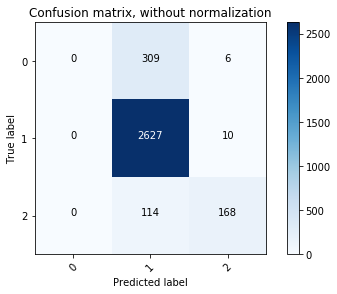

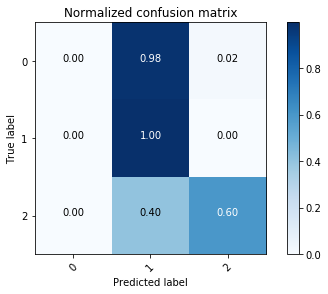

Confusion matrix, without normalization
[[  0  35   1]
 [  0 294   0]
 [  0  17  15]]
Normalized confusion matrix
[[0.         0.97222222 0.02777778]
 [0.         1.         0.        ]
 [0.         0.53125    0.46875   ]]


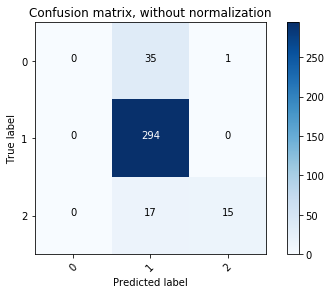

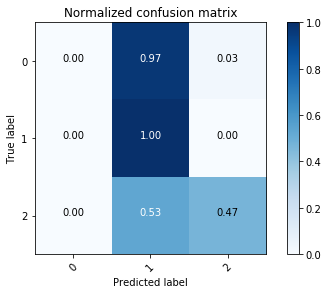

Wall time: 9min 33s


In [59]:
%%time
## SqueezeNet, 224

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='SqueezeNet',
                                                    categories_count=3,
                                                    dataset_name='03_France_ByShape_224_3dim',
                                                    image_size=224, X_train=X_train_224_FS, y_train=y_train_224_FS,
                                                    X_test=X_test_224_FS, y_test=y_test_224_FS,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3234/3234 [==============================] - 21s 6ms/step - loss: 2.1742 - acc: 0.8438 - precision: 0.8439 - recall: 0.8435 - fmeasure: 0.8437
Epoch 2/200
3234/3234 [==============================] - 19s 6ms/step - loss: 1.9197 - acc: 0.8686 - precision: 0.8686 - recall: 0.8686 - fmeasure: 0.8686
Epoch 3/200
3234/3234 [==============================] - 19s 6ms/step - loss: 1.8724 - acc: 0.8729 - precision: 0.8729 - recall: 0.8729 - fmeasure: 0.8729
Epoch 4/200
3234/3234 [==============================] - 19s 6ms/step - loss: 1.7969 - acc: 0.8825 - precision: 0.8825 - recall: 0.8825 - fmeasure: 0.8825
Epoch 5/200
3234/3234 [==============================] - 19s 6ms/step - loss: 1.8070 - acc: 0.8816 - precision: 0.8816 - recall: 0.8816 - fmeasure: 0.8816
Epoch 6/200
3234/3234 [==============================] - 19s 6ms/step - loss: 1.7863 - acc: 0.8837 - precision: 0.8837 - recall: 0.8837 - fmeasure: 0.8837
Epoch 7/200
3234/3234 [==============================] - 19s 6ms/step 

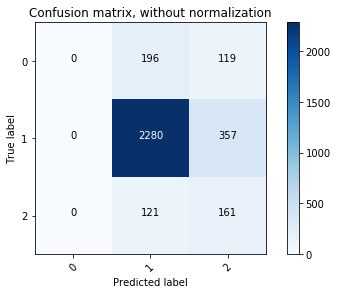

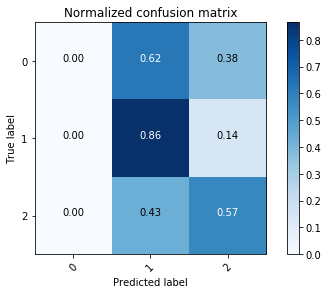

Confusion matrix, without normalization
[[  0  21  15]
 [  0 246  48]
 [  0  16  16]]
Normalized confusion matrix
[[0.         0.58333333 0.41666667]
 [0.         0.83673469 0.16326531]
 [0.         0.5        0.5       ]]


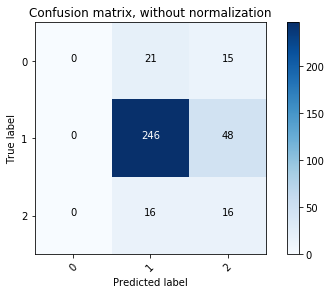

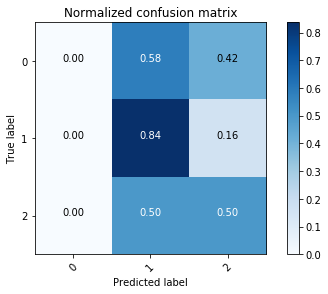

Wall time: 17min 16s


In [61]:
%%time
## MobileNet, 128

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='MobileNet',
                                                    categories_count=3,
                                                    dataset_name='03_France_ByShape_128_3dim',
                                                    image_size=128, X_train=X_train_128_FS, y_train=y_train_128_FS,
                                                    X_test=X_test_128_FS, y_test=y_test_128_FS,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3234/3234 [==============================] - 23s 7ms/step - loss: 1.1700 - acc: 0.8862 - precision: 0.8862 - recall: 0.8859 - fmeasure: 0.8860
Epoch 2/200
3234/3234 [==============================] - 20s 6ms/step - loss: 0.5756 - acc: 0.9477 - precision: 0.9477 - recall: 0.9477 - fmeasure: 0.9477
Epoch 3/200
3234/3234 [==============================] - 20s 6ms/step - loss: 0.5538 - acc: 0.9490 - precision: 0.9490 - recall: 0.9490 - fmeasure: 0.9490
Epoch 4/200
3234/3234 [==============================] - 21s 6ms/step - loss: 0.4421 - acc: 0.9641 - precision: 0.9641 - recall: 0.9641 - fmeasure: 0.9641
Epoch 5/200
3234/3234 [==============================] - 20s 6ms/step - loss: 0.5295 - acc: 0.9533 - precision: 0.9533 - recall: 0.9533 - fmeasure: 0.9533
Epoch 6/200
3234/3234 [==============================] - 20s 6ms/step - loss: 0.3882 - acc: 0.9666 - precision: 0.9666 - recall: 0.9666 - fmeasure: 0.9666
Epoch 7/200
3234/3234 [==============================] - 20s 6ms/step 

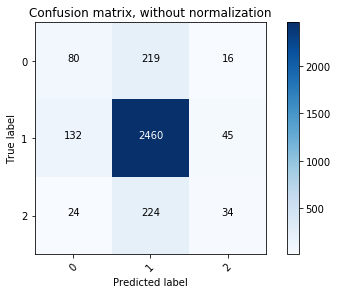

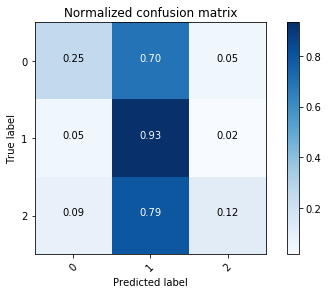

Confusion matrix, without normalization
[[ 13  21   2]
 [ 22 263   9]
 [  1  22   9]]
Normalized confusion matrix
[[0.36111111 0.58333333 0.05555556]
 [0.07482993 0.89455782 0.03061224]
 [0.03125    0.6875     0.28125   ]]


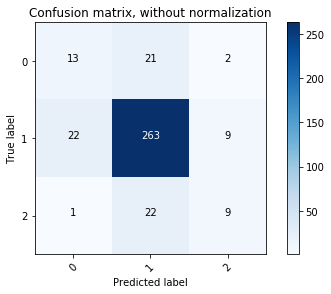

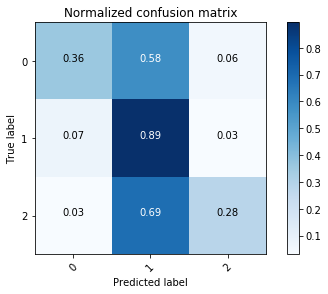

Wall time: 12min 29s


In [63]:
%%time
## MobileNet, 160

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='MobileNet',
                                                    categories_count=3,
                                                    dataset_name='03_France_ByShape_160_3dim',
                                                    image_size=160, X_train=X_train_160_FS, y_train=y_train_160_FS,
                                                    X_test=X_test_160_FS, y_test=y_test_160_FS,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3234/3234 [==============================] - 28s 9ms/step - loss: 2.9704 - acc: 0.8145 - precision: 0.8143 - recall: 0.8142 - fmeasure: 0.8142
Epoch 2/200
3234/3234 [==============================] - 22s 7ms/step - loss: 2.7655 - acc: 0.8256 - precision: 0.8256 - recall: 0.8256 - fmeasure: 0.8256
Epoch 3/200
3234/3234 [==============================] - 22s 7ms/step - loss: 1.9697 - acc: 0.8704 - precision: 0.8704 - recall: 0.8704 - fmeasure: 0.8704
Epoch 4/200
3234/3234 [==============================] - 22s 7ms/step - loss: 1.8175 - acc: 0.8828 - precision: 0.8828 - recall: 0.8828 - fmeasure: 0.8828
Epoch 5/200
3234/3234 [==============================] - 22s 7ms/step - loss: 1.7628 - acc: 0.8874 - precision: 0.8874 - recall: 0.8874 - fmeasure: 0.8874
Epoch 6/200
3234/3234 [==============================] - 22s 7ms/step - loss: 1.6729 - acc: 0.8933 - precision: 0.8933 - recall: 0.8933 - fmeasure: 0.8933
Epoch 7/200
3234/3234 [==============================] - 22s 7ms/step 

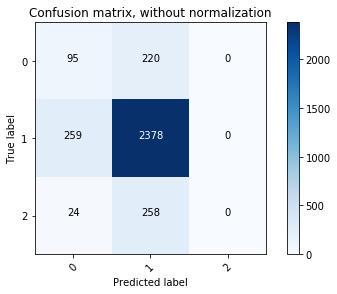

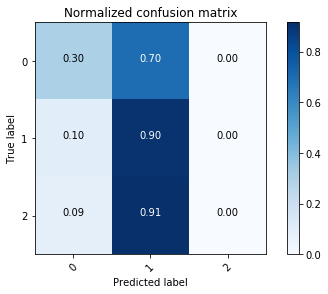

Confusion matrix, without normalization
[[ 10  26   0]
 [ 23 271   0]
 [  4  28   0]]
Normalized confusion matrix
[[0.27777778 0.72222222 0.        ]
 [0.07823129 0.92176871 0.        ]
 [0.125      0.875      0.        ]]


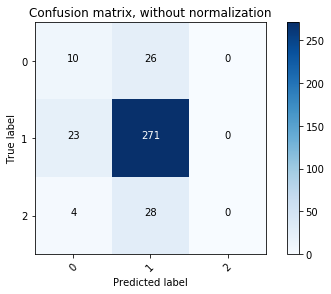

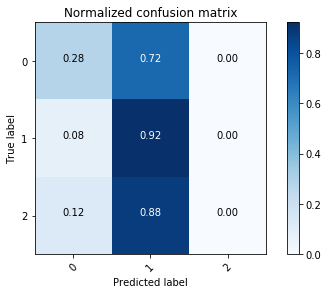

Wall time: 11min 7s


In [64]:
%%time
## MobileNet, 192

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='MobileNet',
                                                    categories_count=3,
                                                    dataset_name='03_France_ByShape_192_3dim',
                                                    image_size=192, X_train=X_train_192_FS, y_train=y_train_192_FS,
                                                    X_test=X_test_192_FS, y_test=y_test_192_FS,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3234/3234 [==============================] - 36s 11ms/step - loss: 0.6896 - acc: 0.8293 - precision: 0.8417 - recall: 0.8046 - fmeasure: 0.8211
Epoch 2/200
3234/3234 [==============================] - 30s 9ms/step - loss: 0.5679 - acc: 0.8689 - precision: 0.8723 - recall: 0.8541 - fmeasure: 0.8625
Epoch 3/200
3234/3234 [==============================] - 30s 9ms/step - loss: 0.4823 - acc: 0.8933 - precision: 0.8963 - recall: 0.8874 - fmeasure: 0.8916
Epoch 4/200
3234/3234 [==============================] - 30s 9ms/step - loss: 0.6084 - acc: 0.8887 - precision: 0.8912 - recall: 0.8837 - fmeasure: 0.8873
Epoch 5/200
3234/3234 [==============================] - 30s 9ms/step - loss: 0.4481 - acc: 0.9060 - precision: 0.9084 - recall: 0.9026 - fmeasure: 0.9053
Epoch 6/200
3234/3234 [==============================] - 30s 9ms/step - loss: 0.4752 - acc: 0.9038 - precision: 0.9062 - recall: 0.8995 - fmeasure: 0.9026
Epoch 7/200
3234/3234 [==============================] - 30s 9ms/step

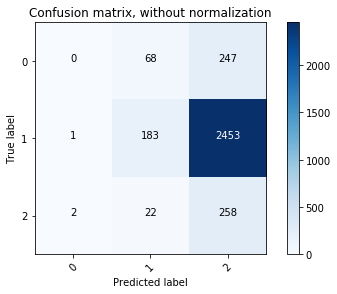

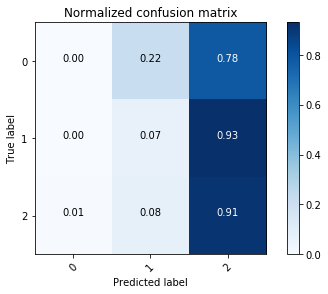

Confusion matrix, without normalization
[[  0   8  28]
 [  0  11 283]
 [  0   3  29]]
Normalized confusion matrix
[[0.         0.22222222 0.77777778]
 [0.         0.03741497 0.96258503]
 [0.         0.09375    0.90625   ]]


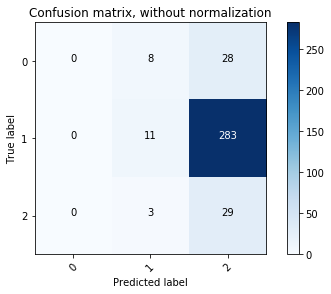

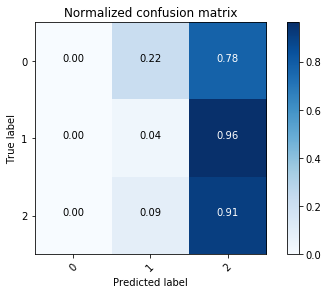

Wall time: 16min 18s


In [65]:
%%time
## Xception, 128

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='Xception',
                                                    categories_count=3,
                                                    dataset_name='03_France_ByShape_128_3dim',
                                                    image_size=128, X_train=X_train_128_FS, y_train=y_train_128_FS,
                                                    X_test=X_test_128_FS, y_test=y_test_128_FS,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3234/3234 [==============================] - 40s 12ms/step - loss: 0.9480 - acc: 0.8284 - precision: 0.8322 - recall: 0.8247 - fmeasure: 0.8281
Epoch 2/200
3234/3234 [==============================] - 31s 10ms/step - loss: 0.5420 - acc: 0.9038 - precision: 0.9053 - recall: 0.9014 - fmeasure: 0.9032
Epoch 3/200
3234/3234 [==============================] - 31s 10ms/step - loss: 0.5396 - acc: 0.9106 - precision: 0.9117 - recall: 0.9094 - fmeasure: 0.9105
Epoch 4/200
3234/3234 [==============================] - 31s 10ms/step - loss: 0.4480 - acc: 0.9236 - precision: 0.9240 - recall: 0.9221 - fmeasure: 0.9230
Epoch 5/200
3234/3234 [==============================] - 31s 10ms/step - loss: 0.4220 - acc: 0.9283 - precision: 0.9291 - recall: 0.9283 - fmeasure: 0.9287
Epoch 6/200
3234/3234 [==============================] - 31s 10ms/step - loss: 0.4565 - acc: 0.9289 - precision: 0.9292 - recall: 0.9289 - fmeasure: 0.9290
Epoch 7/200
3234/3234 [==============================] - 31s 10m

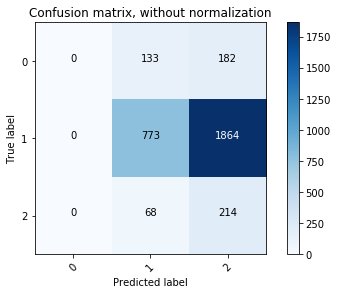

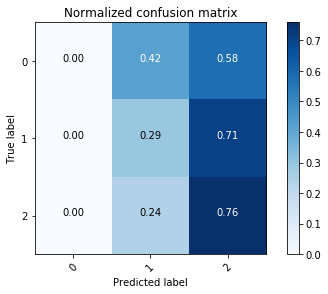

Confusion matrix, without normalization
[[  0  10  26]
 [  0  88 206]
 [  0  15  17]]
Normalized confusion matrix
[[0.         0.27777778 0.72222222]
 [0.         0.29931973 0.70068027]
 [0.         0.46875    0.53125   ]]


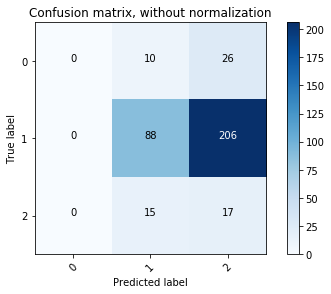

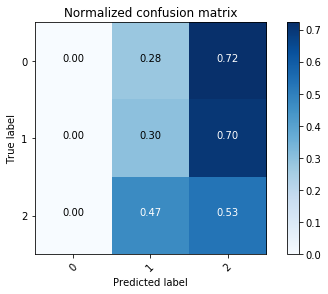

Wall time: 20min 11s


In [66]:
%%time
## Xception, 160

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='Xception',
                                                    categories_count=3,
                                                    dataset_name='03_France_ByShape_160_3dim',
                                                    image_size=160, X_train=X_train_160_FS, y_train=y_train_160_FS,
                                                    X_test=X_test_160_FS, y_test=y_test_160_FS,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3234/3234 [==============================] - 38s 12ms/step - loss: 0.8908 - acc: 0.8460 - precision: 0.8465 - recall: 0.8448 - fmeasure: 0.8455
Epoch 2/200
3234/3234 [==============================] - 31s 9ms/step - loss: 0.5715 - acc: 0.9106 - precision: 0.9108 - recall: 0.9103 - fmeasure: 0.9106
Epoch 3/200
3234/3234 [==============================] - 31s 10ms/step - loss: 0.5063 - acc: 0.9289 - precision: 0.9297 - recall: 0.9283 - fmeasure: 0.9289
Epoch 4/200
3234/3234 [==============================] - 31s 10ms/step - loss: 0.5230 - acc: 0.9304 - precision: 0.9310 - recall: 0.9304 - fmeasure: 0.9307
Epoch 5/200
3234/3234 [==============================] - 31s 10ms/step - loss: 0.2943 - acc: 0.9558 - precision: 0.9561 - recall: 0.9558 - fmeasure: 0.9559
Epoch 6/200
3234/3234 [==============================] - 31s 10ms/step - loss: 0.3432 - acc: 0.9518 - precision: 0.9518 - recall: 0.9518 - fmeasure: 0.9518
Epoch 7/200
3234/3234 [==============================] - 31s 10ms

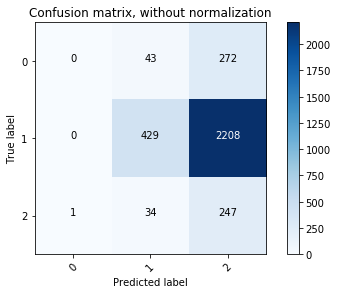

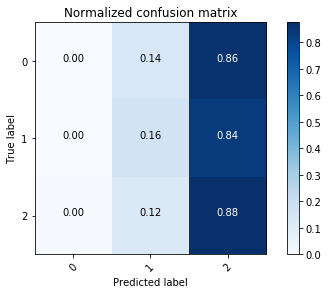

Confusion matrix, without normalization
[[  0   2  34]
 [  0  52 242]
 [  0   2  30]]
Normalized confusion matrix
[[0.         0.05555556 0.94444444]
 [0.         0.17687075 0.82312925]
 [0.         0.0625     0.9375    ]]


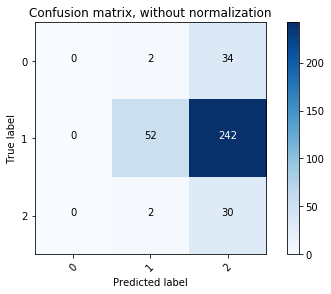

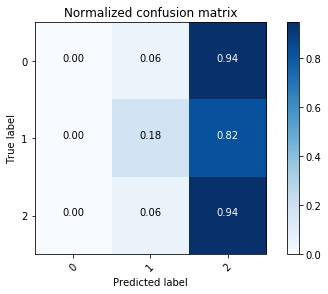

Wall time: 9min 59s


In [67]:
%%time
## Xception, 192

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='Xception',
                                                    categories_count=3,
                                                    dataset_name='03_France_ByShape_192_3dim',
                                                    image_size=192, X_train=X_train_192_FS, y_train=y_train_192_FS,
                                                    X_test=X_test_192_FS, y_test=y_test_192_FS,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3234/3234 [==============================] - 45s 14ms/step - loss: 2.9736 - acc: 0.8135 - precision: 0.8139 - recall: 0.8135 - fmeasure: 0.8137
Epoch 2/200
3234/3234 [==============================] - 38s 12ms/step - loss: 2.3606 - acc: 0.8395 - precision: 0.8395 - recall: 0.8395 - fmeasure: 0.8395
Epoch 3/200
3234/3234 [==============================] - 38s 12ms/step - loss: 2.0047 - acc: 0.8646 - precision: 0.8646 - recall: 0.8646 - fmeasure: 0.8646
Epoch 4/200
3234/3234 [==============================] - 38s 12ms/step - loss: 1.8054 - acc: 0.8794 - precision: 0.8794 - recall: 0.8794 - fmeasure: 0.8794
Epoch 5/200
3234/3234 [==============================] - 38s 12ms/step - loss: 1.7009 - acc: 0.8862 - precision: 0.8862 - recall: 0.8862 - fmeasure: 0.8862
Epoch 6/200
3234/3234 [==============================] - 38s 12ms/step - loss: 1.6663 - acc: 0.8868 - precision: 0.8868 - recall: 0.8868 - fmeasure: 0.8868
Epoch 7/200
3234/3234 [==============================] - 38s 12m

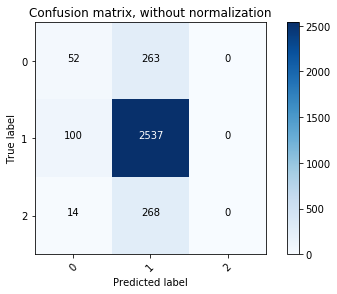

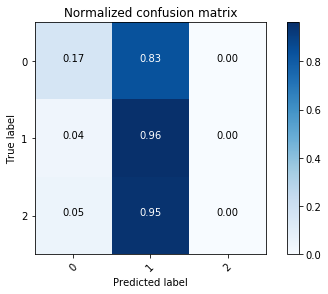

Confusion matrix, without normalization
[[  7  29   0]
 [ 10 284   0]
 [  2  30   0]]
Normalized confusion matrix
[[0.19444444 0.80555556 0.        ]
 [0.03401361 0.96598639 0.        ]
 [0.0625     0.9375     0.        ]]


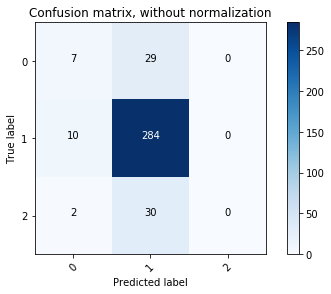

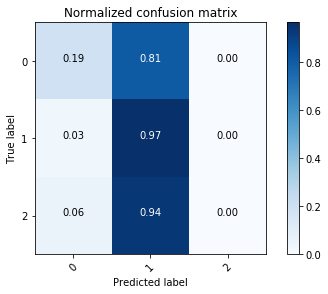

Wall time: 22min 11s


In [68]:
%%time
## Xception, 224

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='Xception',
                                                    categories_count=3,
                                                    dataset_name='03_France_ByShape_224_3dim',
                                                    image_size=224, X_train=X_train_224_FS, y_train=y_train_224_FS,
                                                    X_test=X_test_224_FS, y_test=y_test_224_FS,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3234/3234 [==============================] - 40s 12ms/step - loss: 1.6683 - acc: 0.8689 - precision: 0.8689 - recall: 0.8689 - fmeasure: 0.8689
Epoch 2/200
3234/3234 [==============================] - 20s 6ms/step - loss: 0.9624 - acc: 0.9276 - precision: 0.9276 - recall: 0.9276 - fmeasure: 0.9276
Epoch 3/200
3234/3234 [==============================] - 21s 6ms/step - loss: 0.8366 - acc: 0.9375 - precision: 0.9375 - recall: 0.9375 - fmeasure: 0.9375
Epoch 4/200
3234/3234 [==============================] - 20s 6ms/step - loss: 0.8365 - acc: 0.9369 - precision: 0.9369 - recall: 0.9369 - fmeasure: 0.9369
Epoch 5/200
3234/3234 [==============================] - 21s 6ms/step - loss: 0.6578 - acc: 0.9539 - precision: 0.9539 - recall: 0.9539 - fmeasure: 0.9539
Epoch 6/200
3234/3234 [==============================] - 21s 6ms/step - loss: 0.6938 - acc: 0.9481 - precision: 0.9481 - recall: 0.9481 - fmeasure: 0.9481
Epoch 7/200
3234/3234 [==============================] - 21s 7ms/step

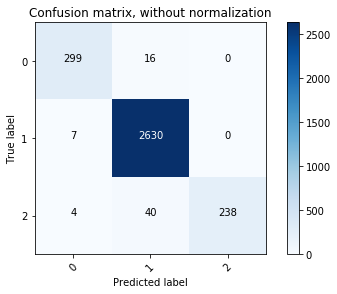

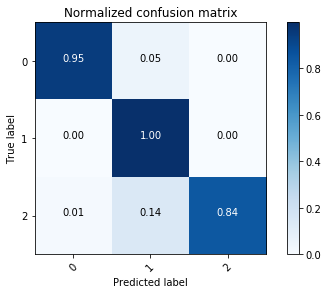

Confusion matrix, without normalization
[[ 25  11   0]
 [  2 290   2]
 [  0  13  19]]
Normalized confusion matrix
[[0.69444444 0.30555556 0.        ]
 [0.00680272 0.98639456 0.00680272]
 [0.         0.40625    0.59375   ]]


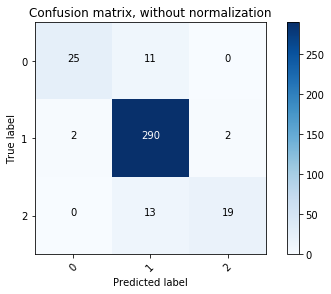

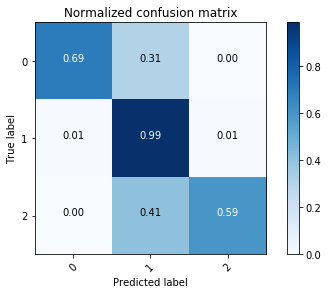

Wall time: 14min 2s


In [69]:
%%time
## VGG16, 128

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG16',
                                                    categories_count=3,
                                                    dataset_name='03_France_ByShape_128_3dim',
                                                    image_size=128, X_train=X_train_128_FS, y_train=y_train_128_FS,
                                                    X_test=X_test_128_FS, y_test=y_test_128_FS,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3234/3234 [==============================] - 36s 11ms/step - loss: 2.3041 - acc: 0.8457 - precision: 0.8457 - recall: 0.8457 - fmeasure: 0.8457
Epoch 2/200
3234/3234 [==============================] - 24s 8ms/step - loss: 1.9526 - acc: 0.8741 - precision: 0.8741 - recall: 0.8741 - fmeasure: 0.8741
Epoch 3/200
3234/3234 [==============================] - 25s 8ms/step - loss: 1.9251 - acc: 0.8785 - precision: 0.8785 - recall: 0.8785 - fmeasure: 0.8785
Epoch 4/200
3234/3234 [==============================] - 25s 8ms/step - loss: 1.8786 - acc: 0.8797 - precision: 0.8797 - recall: 0.8797 - fmeasure: 0.8797
Epoch 5/200
3234/3234 [==============================] - 24s 8ms/step - loss: 1.8896 - acc: 0.8813 - precision: 0.8813 - recall: 0.8813 - fmeasure: 0.8813
Epoch 6/200
3234/3234 [==============================] - 25s 8ms/step - loss: 1.8515 - acc: 0.8828 - precision: 0.8828 - recall: 0.8828 - fmeasure: 0.8828
Epoch 7/200
3234/3234 [==============================] - 24s 8ms/step

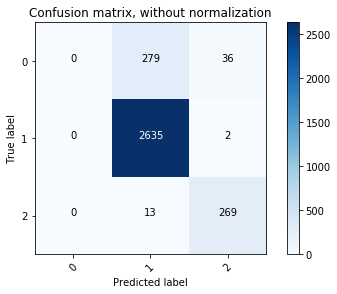

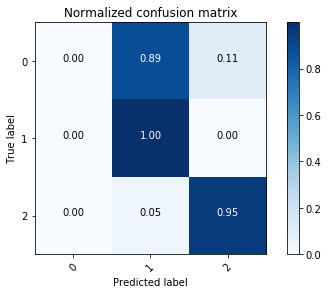

Confusion matrix, without normalization
[[  0  34   2]
 [  0 289   5]
 [  0   4  28]]
Normalized confusion matrix
[[0.         0.94444444 0.05555556]
 [0.         0.9829932  0.0170068 ]
 [0.         0.125      0.875     ]]


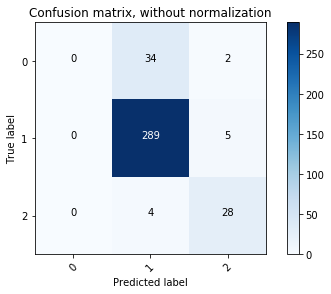

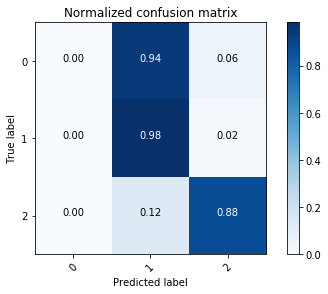

Wall time: 31min 4s


In [72]:
%%time
## VGG16, 160

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG16',
                                                    categories_count=3,
                                                    dataset_name='03_France_ByShape_160_3dim',
                                                    image_size=160, X_train=X_train_160_FS, y_train=y_train_160_FS,
                                                    X_test=X_test_160_FS, y_test=y_test_160_FS,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3234/3234 [==============================] - 40s 12ms/step - loss: 2.6387 - acc: 0.8318 - precision: 0.8318 - recall: 0.8318 - fmeasure: 0.8318
Epoch 2/200
3234/3234 [==============================] - 30s 9ms/step - loss: 2.2751 - acc: 0.8553 - precision: 0.8553 - recall: 0.8553 - fmeasure: 0.8553
Epoch 3/200
3234/3234 [==============================] - 30s 9ms/step - loss: 2.1087 - acc: 0.8661 - precision: 0.8661 - recall: 0.8661 - fmeasure: 0.8661
Epoch 4/200
3234/3234 [==============================] - 30s 9ms/step - loss: 1.9515 - acc: 0.8763 - precision: 0.8763 - recall: 0.8763 - fmeasure: 0.8763
Epoch 5/200
3234/3234 [==============================] - 30s 9ms/step - loss: 1.9366 - acc: 0.8779 - precision: 0.8779 - recall: 0.8779 - fmeasure: 0.8779
Epoch 6/200
3234/3234 [==============================] - 29s 9ms/step - loss: 1.8879 - acc: 0.8813 - precision: 0.8813 - recall: 0.8813 - fmeasure: 0.8813
Epoch 7/200
3234/3234 [==============================] - 29s 9ms/step

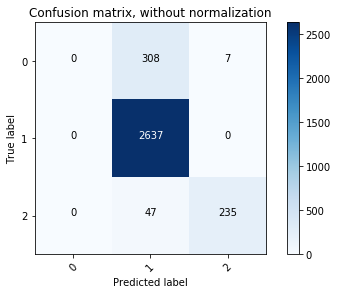

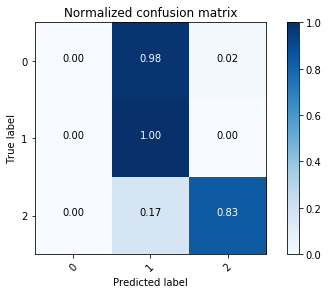

Confusion matrix, without normalization
[[  0  36   0]
 [  0 294   0]
 [  0  14  18]]
Normalized confusion matrix
[[0.     1.     0.    ]
 [0.     1.     0.    ]
 [0.     0.4375 0.5625]]


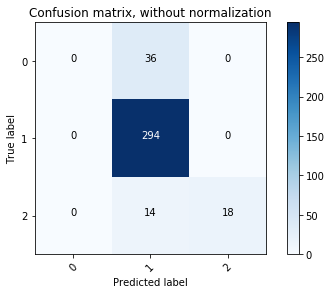

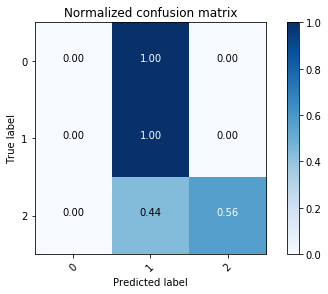

Wall time: 14min 4s


In [73]:
%%time
## VGG16, 192

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG16',
                                                    categories_count=3,
                                                    dataset_name='03_France_ByShape_192_3dim',
                                                    image_size=192, X_train=X_train_192_FS, y_train=y_train_192_FS,
                                                    X_test=X_test_192_FS, y_test=y_test_192_FS,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3234/3234 [==============================] - 47s 15ms/step - loss: 2.4443 - acc: 0.8423 - precision: 0.8423 - recall: 0.8423 - fmeasure: 0.8423
Epoch 2/200
3234/3234 [==============================] - 36s 11ms/step - loss: 1.7769 - acc: 0.8868 - precision: 0.8868 - recall: 0.8868 - fmeasure: 0.8868
Epoch 3/200
3234/3234 [==============================] - 36s 11ms/step - loss: 1.7845 - acc: 0.8865 - precision: 0.8865 - recall: 0.8865 - fmeasure: 0.8865
Epoch 4/200
3234/3234 [==============================] - 37s 11ms/step - loss: 1.7218 - acc: 0.8921 - precision: 0.8921 - recall: 0.8921 - fmeasure: 0.8921
Epoch 5/200
3234/3234 [==============================] - 37s 11ms/step - loss: 1.7325 - acc: 0.8902 - precision: 0.8902 - recall: 0.8902 - fmeasure: 0.8902
Epoch 6/200
3234/3234 [==============================] - 37s 11ms/step - loss: 1.6376 - acc: 0.8970 - precision: 0.8970 - recall: 0.8970 - fmeasure: 0.8970
Epoch 7/200
3234/3234 [==============================] - 36s 11m

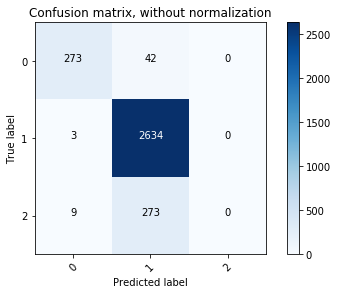

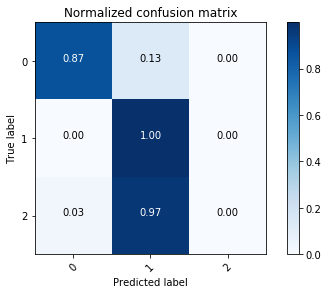

Confusion matrix, without normalization
[[ 22  14   0]
 [  0 294   0]
 [  5  27   0]]
Normalized confusion matrix
[[0.61111111 0.38888889 0.        ]
 [0.         1.         0.        ]
 [0.15625    0.84375    0.        ]]


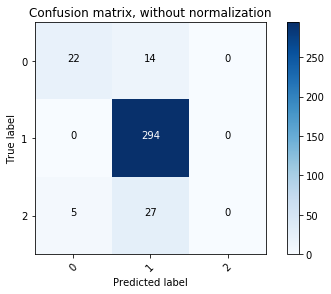

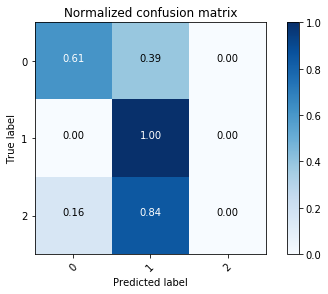

Wall time: 15min 9s


In [74]:
%%time
## VGG16, 224

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG16',
                                                    categories_count=3,
                                                    dataset_name='03_France_ByShape_224_3dim',
                                                    image_size=224, X_train=X_train_224_FS, y_train=y_train_224_FS,
                                                    X_test=X_test_224_FS, y_test=y_test_224_FS,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3234/3234 [==============================] - 31s 10ms/step - loss: 1.7608 - acc: 0.8711 - precision: 0.8711 - recall: 0.8711 - fmeasure: 0.8711
Epoch 2/200
3234/3234 [==============================] - 21s 6ms/step - loss: 1.0903 - acc: 0.9193 - precision: 0.9193 - recall: 0.9193 - fmeasure: 0.9193
Epoch 3/200
3234/3234 [==============================] - 21s 6ms/step - loss: 1.0408 - acc: 0.9227 - precision: 0.9227 - recall: 0.9227 - fmeasure: 0.9227
Epoch 4/200
3234/3234 [==============================] - 21s 6ms/step - loss: 0.7822 - acc: 0.9431 - precision: 0.9431 - recall: 0.9431 - fmeasure: 0.9431
Epoch 5/200
3234/3234 [==============================] - 22s 7ms/step - loss: 0.7487 - acc: 0.9462 - precision: 0.9462 - recall: 0.9462 - fmeasure: 0.9462
Epoch 6/200
3234/3234 [==============================] - 21s 6ms/step - loss: 0.6783 - acc: 0.9502 - precision: 0.9502 - recall: 0.9502 - fmeasure: 0.9502
Epoch 7/200
3234/3234 [==============================] - 23s 7ms/step

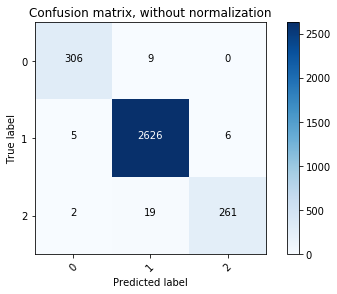

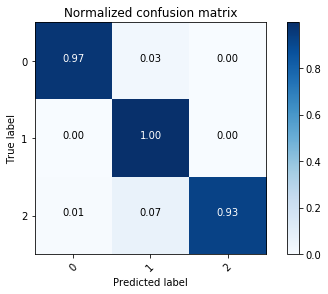

Confusion matrix, without normalization
[[ 28   8   0]
 [  2 288   4]
 [  1   7  24]]
Normalized confusion matrix
[[0.77777778 0.22222222 0.        ]
 [0.00680272 0.97959184 0.01360544]
 [0.03125    0.21875    0.75      ]]


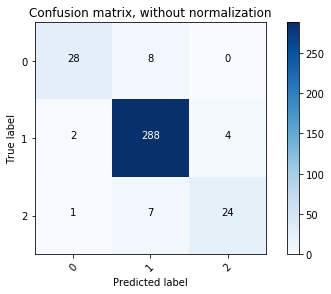

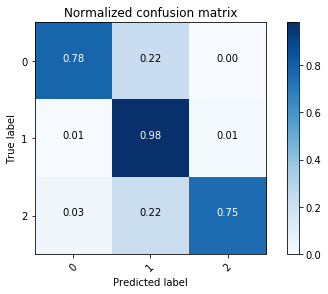

Wall time: 15min 38s


In [76]:
%%time
## VGG19, 128

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG19',
                                                    categories_count=3,
                                                    dataset_name='03_France_ByShape_128_3dim',
                                                    image_size=128, X_train=X_train_128_FS, y_train=y_train_128_FS,
                                                    X_test=X_test_128_FS, y_test=y_test_128_FS,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3234/3234 [==============================] - 40s 12ms/step - loss: 2.4190 - acc: 0.8414 - precision: 0.8414 - recall: 0.8414 - fmeasure: 0.8414
Epoch 2/200
3234/3234 [==============================] - 28s 9ms/step - loss: 2.0893 - acc: 0.8658 - precision: 0.8658 - recall: 0.8658 - fmeasure: 0.8658
Epoch 3/200
3234/3234 [==============================] - 28s 9ms/step - loss: 1.9624 - acc: 0.8754 - precision: 0.8754 - recall: 0.8754 - fmeasure: 0.8754
Epoch 4/200
3234/3234 [==============================] - 28s 9ms/step - loss: 2.0028 - acc: 0.8726 - precision: 0.8726 - recall: 0.8726 - fmeasure: 0.8726
Epoch 5/200
3234/3234 [==============================] - 28s 9ms/step - loss: 1.9893 - acc: 0.8738 - precision: 0.8738 - recall: 0.8738 - fmeasure: 0.8738
Epoch 6/200
3234/3234 [==============================] - 28s 9ms/step - loss: 1.9036 - acc: 0.8803 - precision: 0.8803 - recall: 0.8803 - fmeasure: 0.8803
Epoch 7/200
3234/3234 [==============================] - 28s 9ms/step

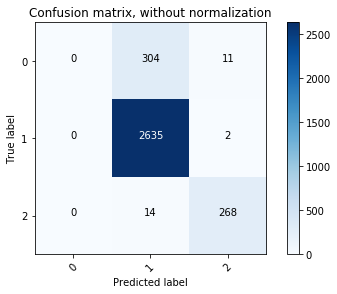

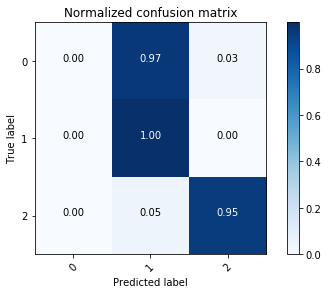

Confusion matrix, without normalization
[[  0  35   1]
 [  0 290   4]
 [  0   9  23]]
Normalized confusion matrix
[[0.         0.97222222 0.02777778]
 [0.         0.98639456 0.01360544]
 [0.         0.28125    0.71875   ]]


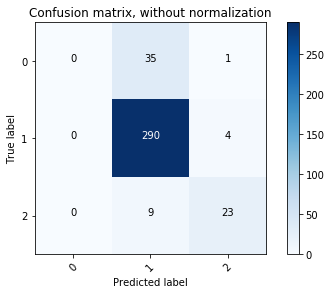

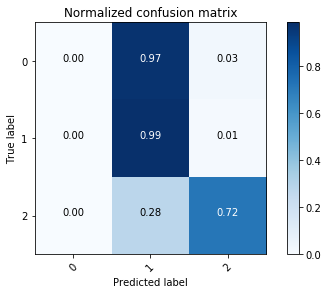

Wall time: 25min 36s


In [77]:
%%time
## VGG19, 160

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG19',
                                                    categories_count=3,
                                                    dataset_name='03_France_ByShape_160_3dim',
                                                    image_size=160, X_train=X_train_160_FS, y_train=y_train_160_FS,
                                                    X_test=X_test_160_FS, y_test=y_test_160_FS,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3234/3234 [==============================] - 44s 13ms/step - loss: 2.0024 - acc: 0.8683 - precision: 0.8683 - recall: 0.8683 - fmeasure: 0.8683
Epoch 2/200
3234/3234 [==============================] - 33s 10ms/step - loss: 1.7212 - acc: 0.8887 - precision: 0.8887 - recall: 0.8887 - fmeasure: 0.8887
Epoch 3/200
3234/3234 [==============================] - 33s 10ms/step - loss: 1.7163 - acc: 0.8902 - precision: 0.8902 - recall: 0.8902 - fmeasure: 0.8902
Epoch 4/200
3234/3234 [==============================] - 33s 10ms/step - loss: 1.6719 - acc: 0.8939 - precision: 0.8939 - recall: 0.8939 - fmeasure: 0.8939
Epoch 5/200
3234/3234 [==============================] - 33s 10ms/step - loss: 1.6187 - acc: 0.8980 - precision: 0.8980 - recall: 0.8980 - fmeasure: 0.8980
Epoch 6/200
3234/3234 [==============================] - 33s 10ms/step - loss: 1.6156 - acc: 0.8986 - precision: 0.8986 - recall: 0.8986 - fmeasure: 0.8986
Epoch 7/200
3234/3234 [==============================] - 33s 10m

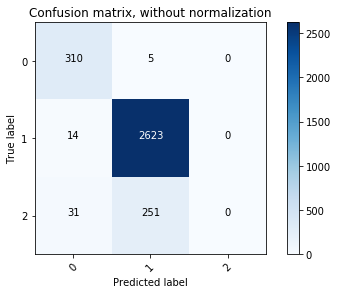

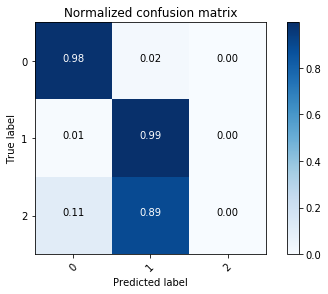

Confusion matrix, without normalization
[[ 30   6   0]
 [  7 287   0]
 [  6  26   0]]
Normalized confusion matrix
[[0.83333333 0.16666667 0.        ]
 [0.02380952 0.97619048 0.        ]
 [0.1875     0.8125     0.        ]]


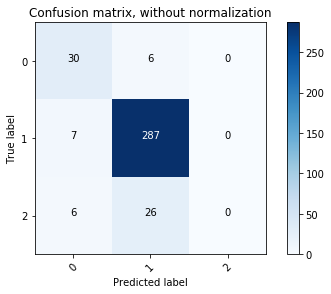

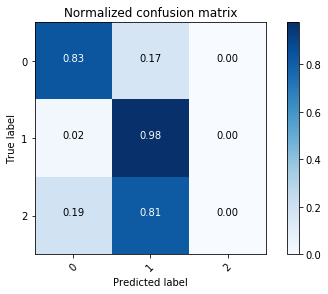

Wall time: 14min 34s


In [78]:
%%time
## VGG19, 192

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG19',
                                                    categories_count=3,
                                                    dataset_name='03_France_ByShape_192_3dim',
                                                    image_size=192, X_train=X_train_192_FS, y_train=y_train_192_FS,
                                                    X_test=X_test_192_FS, y_test=y_test_192_FS,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3234/3234 [==============================] - 53s 16ms/step - loss: 3.0012 - acc: 0.8132 - precision: 0.8132 - recall: 0.8132 - fmeasure: 0.8132
Epoch 2/200
3234/3234 [==============================] - 41s 13ms/step - loss: 2.9754 - acc: 0.8154 - precision: 0.8154 - recall: 0.8154 - fmeasure: 0.8154
Epoch 3/200
3234/3234 [==============================] - 40s 13ms/step - loss: 2.9015 - acc: 0.8179 - precision: 0.8179 - recall: 0.8179 - fmeasure: 0.8179
Epoch 4/200
3234/3234 [==============================] - 40s 13ms/step - loss: 2.4315 - acc: 0.8488 - precision: 0.8488 - recall: 0.8488 - fmeasure: 0.8488
Epoch 5/200
3234/3234 [==============================] - 41s 13ms/step - loss: 2.3455 - acc: 0.8534 - precision: 0.8534 - recall: 0.8534 - fmeasure: 0.8534
Epoch 6/200
3234/3234 [==============================] - 40s 12ms/step - loss: 2.1701 - acc: 0.8646 - precision: 0.8646 - recall: 0.8646 - fmeasure: 0.8646
Epoch 7/200
3234/3234 [==============================] - 40s 12m

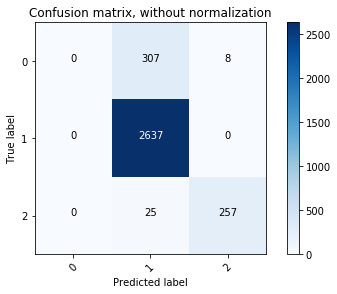

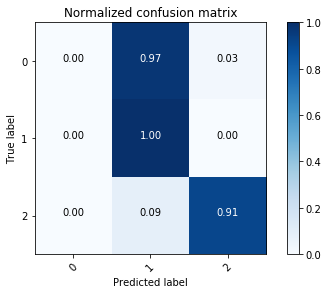

Confusion matrix, without normalization
[[  0  35   1]
 [  0 293   1]
 [  0   6  26]]
Normalized confusion matrix
[[0.         0.97222222 0.02777778]
 [0.         0.99659864 0.00340136]
 [0.         0.1875     0.8125    ]]


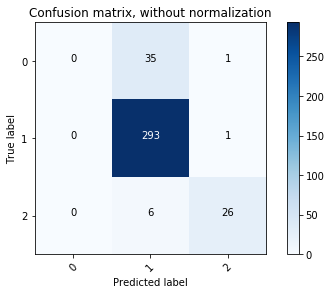

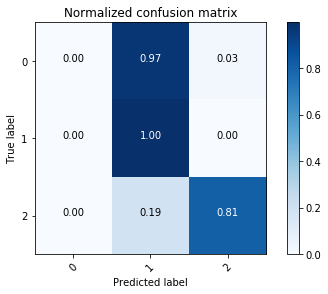

Wall time: 44min 21s


In [79]:
%%time
## VGG19, 224

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG19',
                                                    categories_count=3,
                                                    dataset_name='03_France_ByShape_224_3dim',
                                                    image_size=224, X_train=X_train_224_FS, y_train=y_train_224_FS,
                                                    X_test=X_test_224_FS, y_test=y_test_224_FS,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

In [10]:
%%time
# Now load another dataset

X_128_F_ByMeaning, y_128_F_ByMeaning = load_dir("D:/svruchtel/PREPROCESSED_DATA/03_France_ByMeaning_128_3dim",
                                            ["GazolineStation", "Hotel", "Parking", "Restaurant",
                                             "Taxi", "TollRoad", "Transport"],
                                            already_transformed=True)   

X_160_F_ByMeaning, y_160_F_ByMeaning = load_dir("D:/svruchtel/PREPROCESSED_DATA/03_France_ByMeaning_160_3dim",
                                            ["GazolineStation", "Hotel", "Parking", "Restaurant",
                                             "Taxi", "TollRoad", "Transport"],
                                            already_transformed=True)   

X_192_F_ByMeaning, y_192_F_ByMeaning = load_dir("D:/svruchtel/PREPROCESSED_DATA/03_France_ByMeaning_192_3dim",
                                            ["GazolineStation", "Hotel", "Parking", "Restaurant",
                                             "Taxi", "TollRoad", "Transport"],
                                            already_transformed=True)   

X_224_F_ByMeaning, y_224_F_ByMeaning = load_dir("D:/svruchtel/PREPROCESSED_DATA/03_France_ByMeaning_224_3dim",
                                            ["GazolineStation", "Hotel", "Parking", "Restaurant",
                                             "Taxi", "TollRoad", "Transport"],
                                            already_transformed=True)   


Wall time: 23.7 s


In [11]:
%%time

#Than divide all of them to train and test

X_train_128_FM, y_train_128_FM, X_test_128_FM, y_test_128_FM = divide_to_train_end_test(X_128_F_ByMeaning,
                                                                                        y_128_F_ByMeaning, num_categories=7)
X_train_160_FM, y_train_160_FM, X_test_160_FM, y_test_160_FM = divide_to_train_end_test(X_160_F_ByMeaning,
                                                                                        y_160_F_ByMeaning, num_categories=7)
X_train_192_FM, y_train_192_FM, X_test_192_FM, y_test_192_FM = divide_to_train_end_test(X_192_F_ByMeaning,
                                                                                        y_192_F_ByMeaning, num_categories=7)
X_train_224_FM, y_train_224_FM, X_test_224_FM, y_test_224_FM = divide_to_train_end_test(X_224_F_ByMeaning,
                                                                                        y_224_F_ByMeaning, num_categories=7)



Wall time: 1.3 s


Epoch 1/200
3123/3123 [==============================] - 32s 10ms/step - loss: 4.1679 - acc: 0.5498 - precision: 0.5539 - recall: 0.5469 - fmeasure: 0.5502
Epoch 2/200
3123/3123 [==============================] - 20s 6ms/step - loss: 3.0674 - acc: 0.6840 - precision: 0.6854 - recall: 0.6830 - fmeasure: 0.6841
Epoch 3/200
3123/3123 [==============================] - 20s 6ms/step - loss: 2.3917 - acc: 0.7538 - precision: 0.7538 - recall: 0.7534 - fmeasure: 0.7536
Epoch 4/200
3123/3123 [==============================] - 20s 7ms/step - loss: 2.2289 - acc: 0.7810 - precision: 0.7825 - recall: 0.7807 - fmeasure: 0.7816
Epoch 5/200
3123/3123 [==============================] - 20s 6ms/step - loss: 2.1197 - acc: 0.7919 - precision: 0.7934 - recall: 0.7912 - fmeasure: 0.7923
Epoch 6/200
3123/3123 [==============================] - 20s 6ms/step - loss: 1.9889 - acc: 0.8092 - precision: 0.8102 - recall: 0.8092 - fmeasure: 0.8096
Epoch 7/200
3123/3123 [==============================] - 20s 6ms/step

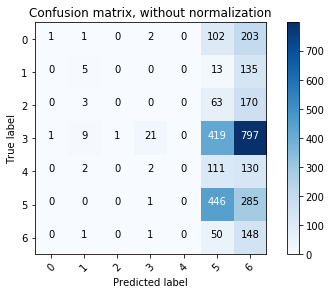

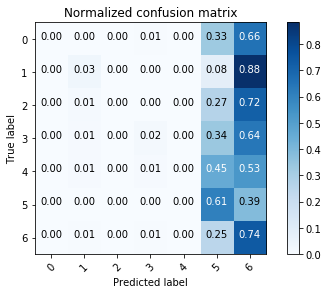

Confusion matrix, without normalization
[[ 0  1  0  0  0 13 21]
 [ 0  0  0  0  0  2 16]
 [ 0  0  0  0  0  8 19]
 [ 0  2  0  2  0 48 87]
 [ 0  1  0  1  0 14 12]
 [ 0  0  1  0  0 46 35]
 [ 0  0  0  0  0  5 18]]
Normalized confusion matrix
[[0.         0.02857143 0.         0.         0.         0.37142857
  0.6       ]
 [0.         0.         0.         0.         0.         0.11111111
  0.88888889]
 [0.         0.         0.         0.         0.         0.2962963
  0.7037037 ]
 [0.         0.01438849 0.         0.01438849 0.         0.34532374
  0.62589928]
 [0.         0.03571429 0.         0.03571429 0.         0.5
  0.42857143]
 [0.         0.         0.01219512 0.         0.         0.56097561
  0.42682927]
 [0.         0.         0.         0.         0.         0.2173913
  0.7826087 ]]


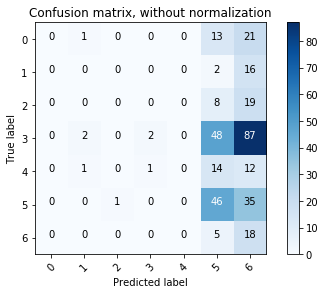

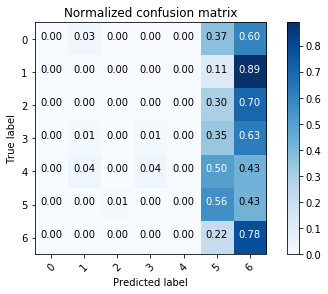

Wall time: 21min 58s


In [82]:
%%time
## MobileNet, 128

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='MobileNet',
                                                    categories_count=7,
                                                    dataset_name='03_France_ByMeaning_128_3dim',
                                                    image_size=128, X_train=X_train_128_FM, y_train=y_train_128_FM,
                                                    X_test=X_test_128_FM, y_test=y_test_128_FM,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3123/3123 [==============================] - 44s 14ms/step - loss: 6.6775 - acc: 0.5338 - precision: 0.5336 - recall: 0.5335 - fmeasure: 0.5335
Epoch 2/200
3123/3123 [==============================] - 21s 7ms/step - loss: 6.5698 - acc: 0.5652 - precision: 0.5652 - recall: 0.5652 - fmeasure: 0.5652
Epoch 3/200
3123/3123 [==============================] - 21s 7ms/step - loss: 6.4252 - acc: 0.5831 - precision: 0.5831 - recall: 0.5831 - fmeasure: 0.5831
Epoch 4/200
3123/3123 [==============================] - 21s 7ms/step - loss: 6.1852 - acc: 0.6010 - precision: 0.6010 - recall: 0.6010 - fmeasure: 0.6010
Epoch 5/200
3123/3123 [==============================] - 21s 7ms/step - loss: 6.2077 - acc: 0.5981 - precision: 0.5980 - recall: 0.5978 - fmeasure: 0.5979
Epoch 6/200
3123/3123 [==============================] - 21s 7ms/step - loss: 6.0406 - acc: 0.6055 - precision: 0.6055 - recall: 0.6055 - fmeasure: 0.6055
Epoch 7/200
3123/3123 [==============================] - 22s 7ms/step

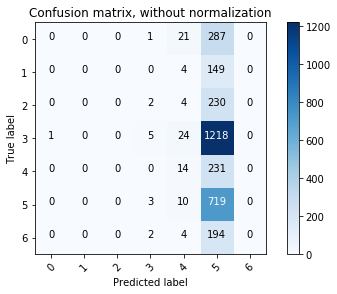

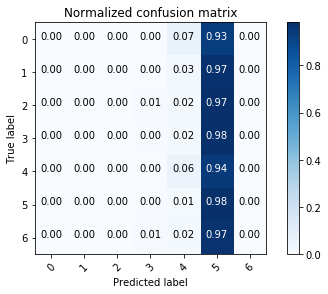

Confusion matrix, without normalization
[[  0   0   0   0   4  31   0]
 [  0   0   0   2   1  15   0]
 [  0   0   0   0   1  26   0]
 [  0   0   0   1   1 137   0]
 [  0   0   0   0   0  28   0]
 [  0   0   0   0   1  81   0]
 [  0   0   0   0   3  20   0]]
Normalized confusion matrix
[[0.         0.         0.         0.         0.11428571 0.88571429
  0.        ]
 [0.         0.         0.         0.11111111 0.05555556 0.83333333
  0.        ]
 [0.         0.         0.         0.         0.03703704 0.96296296
  0.        ]
 [0.         0.         0.         0.00719424 0.00719424 0.98561151
  0.        ]
 [0.         0.         0.         0.         0.         1.
  0.        ]
 [0.         0.         0.         0.         0.01219512 0.98780488
  0.        ]
 [0.         0.         0.         0.         0.13043478 0.86956522
  0.        ]]


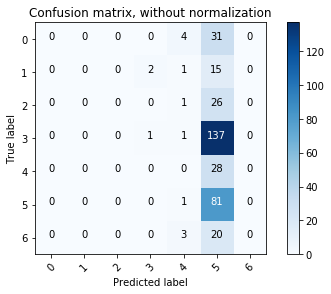

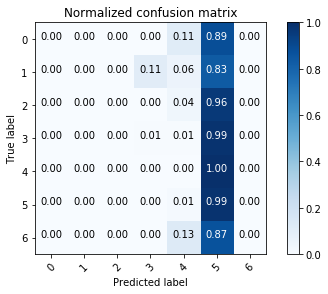

Wall time: 13min 18s


In [83]:
%%time
## MobileNet, 160

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='MobileNet',
                                                    categories_count=7,
                                                    dataset_name='03_France_ByMeaning_160_3dim',
                                                    image_size=160, X_train=X_train_160_FM, y_train=y_train_160_FM,
                                                    X_test=X_test_160_FM, y_test=y_test_160_FM,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

In [13]:
parameters_df = pd.read_csv('./PARAMETERS_AND_RESULTS/04_04_params_France_WithoutRetrain.csv', sep='\t', index_col=0)
results_df = pd.read_csv('./PARAMETERS_AND_RESULTS/04_04_results_France_WithoutRetrain.csv', sep='\t', index_col=0)

In [14]:
X_train_shuffled, y_train_shuffled = shuffle_Xy(X_train_192_FM, y_train_192_FM)

In [15]:
model_app = create_net_with_name('MobileNet', X_train_shuffled)
model_app.trainable = False

In [16]:
model = Sequential()
model.add(model_app)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

In [18]:
%%time
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', precision, recall, fmeasure])
callback = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto')
history_callback = model.fit(X_train_shuffled, one_hot(y_train_shuffled, 7),
                                 epochs=200, batch_size=10, callbacks=[callback])


Epoch 1/200
3123/3123 [==============================] - 23s 7ms/step - loss: 6.1555 - acc: 0.5485 - precision: 0.5488 - recall: 0.5482 - fmeasure: 0.5485
Epoch 2/200
3123/3123 [==============================] - 21s 7ms/step - loss: 5.5397 - acc: 0.6279 - precision: 0.6279 - recall: 0.6279 - fmeasure: 0.6279
Epoch 3/200
3123/3123 [==============================] - 21s 7ms/step - loss: 5.1514 - acc: 0.6535 - precision: 0.6541 - recall: 0.6535 - fmeasure: 0.6538
Epoch 4/200
3123/3123 [==============================] - 20s 7ms/step - loss: 5.0457 - acc: 0.6609 - precision: 0.6612 - recall: 0.6609 - fmeasure: 0.6610
Epoch 5/200
3123/3123 [==============================] - 20s 6ms/step - loss: 4.7327 - acc: 0.6852 - precision: 0.6852 - recall: 0.6852 - fmeasure: 0.6852
Epoch 6/200
3123/3123 [==============================] - 20s 7ms/step - loss: 4.8338 - acc: 0.6820 - precision: 0.6820 - recall: 0.6820 - fmeasure: 0.6820
Epoch 7/200
3123/3123 [==============================] - 20s 7ms/step 

In [19]:
scores_test = model.evaluate(X_test_192_FM, one_hot(y_test_192_FM, 7))

352/352 [==============================] - 2s 5ms/step


Confusion matrix, without normalization
[[   0    0    0    0    0    0  309]
 [   0    0    0    0    0    0  153]
 [   0    0    0    0    0    0  236]
 [   0    0    0    0    0    0 1248]
 [   0    0    0    0    0    0  245]
 [   0    0    0    1    0    0  731]
 [   0    0    0    0    0    0  200]]
Normalized confusion matrix
[[0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         0.00136612 0.         0.
  0.99863388]
 [0.         0.         0.         0.         0.         0.
  1.        ]]


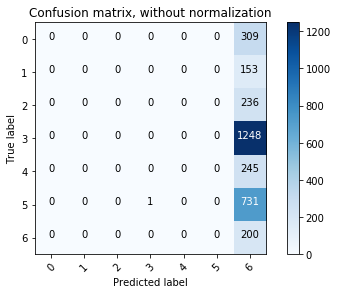

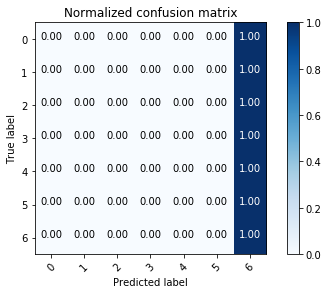

Confusion matrix, without normalization
[[  0   0   0   0   0   2  33]
 [  0   0   0   0   0   0  18]
 [  0   0   0   0   0   0  27]
 [  0   0   0   0   0   0 139]
 [  0   0   0   0   0   0  28]
 [  0   0   0   0   0   1  81]
 [  0   0   0   0   0   0  23]]
Normalized confusion matrix
[[0.         0.         0.         0.         0.         0.05714286
  0.94285714]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         0.         0.         0.01219512
  0.98780488]
 [0.         0.         0.         0.         0.         0.
  1.        ]]


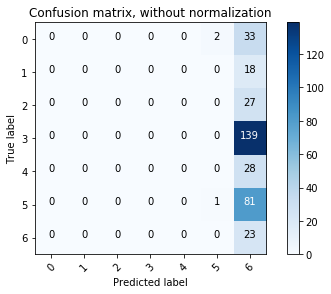

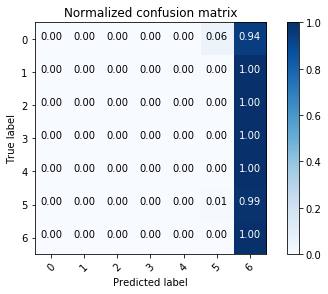

In [20]:
y_pred_train = model.predict(X_train_192_FM)
cnf_matrix = confusion_matrix(one_hot(y_train_192_FM, 7).argmax(axis=1), (y_pred_train.round()).argmax(axis=1))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(7),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(7), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

y_pred_test = model.predict(X_test_192_FM)
cnf_matrix = confusion_matrix(one_hot(y_test_192_FM, 7).argmax(axis=1), (y_pred_test.round()).argmax(axis=1))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(7),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(7), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [21]:
loss_best = min(history_callback.history['loss'])
accuracy_best = max(history_callback.history['acc'])
precision_best = max(history_callback.history['precision'])
recall_best = max(history_callback.history['recall'])
fmeasure_best = max(history_callback.history['fmeasure'])
    
# write in dataframes
parameters = {'net_name':'MobileNet', 'dataset_name':'03_France_ByMeaning_192_3dim', 
                  'train_or_test':'train', 'image_size':192, 
                  'batch_size_app':-1, 'batch_size_small_net':10, 'dense_1':0.5, 'dense_2':-1,
                  'activation_1':'relu', 'activation_2':'relu', 'optimiser':'adam'}
parameters_df = parameters_df.append(parameters, ignore_index=True)
results = {'net_name':'MobileNet','dataset_name':'03_France_ByMeaning_192_3dim', 'train_or_test':'train',
               'loss':loss_best, 'accuracy':accuracy_best, 'precision':precision_best,
               'recall':recall_best, 'fmeasure':fmeasure_best}
results_df = results_df.append(results, ignore_index=True)
    
# evaluate on test
parameters = {'net_name':'MobileNet', 'dataset_name':'03_France_ByMeaning_192_3dim', 
                  'train_or_test':'test', 'image_size':192, 
                  'batch_size_app':-1, 'batch_size_small_net':10, 'dense_1':0.5, 'dense_2':-1,
                  'activation_1':'relu', 'activation_2':'relu', 'optimiser':'adam'}
parameters_df = parameters_df.append(parameters, ignore_index=True)
results = {'net_name':'MobileNet','dataset_name':'03_France_ByMeaning_192_3dim', 'train_or_test':'test',
               'loss':scores_test[0], 'accuracy':scores_test[1],
               'precision':scores_test[2], 'recall':scores_test[3], 'fmeasure':scores_test[4]}
results_df = results_df.append(results, ignore_index=True)
    
parameters_df.to_csv('./PARAMETERS_AND_RESULTS/04_04_params_France_WithoutRetrain.csv', sep='\t')
results_df.to_csv('./PARAMETERS_AND_RESULTS/04_04_results_France_WithoutRetrain.csv', sep='\t')
    

Epoch 1/200
3123/3123 [==============================] - 24s 8ms/step - loss: 6.7594 - acc: 0.5447 - precision: 0.5448 - recall: 0.5447 - fmeasure: 0.5447
Epoch 2/200
3123/3123 [==============================] - 22s 7ms/step - loss: 6.3946 - acc: 0.5895 - precision: 0.5895 - recall: 0.5895 - fmeasure: 0.5895
Epoch 3/200
3123/3123 [==============================] - 22s 7ms/step - loss: 6.3340 - acc: 0.5953 - precision: 0.5953 - recall: 0.5953 - fmeasure: 0.5953
Epoch 4/200
3123/3123 [==============================] - 22s 7ms/step - loss: 6.2214 - acc: 0.6077 - precision: 0.6077 - recall: 0.6077 - fmeasure: 0.6077
Epoch 5/200
3123/3123 [==============================] - 22s 7ms/step - loss: 6.2135 - acc: 0.6097 - precision: 0.6097 - recall: 0.6097 - fmeasure: 0.6097
Epoch 6/200
3123/3123 [==============================] - 22s 7ms/step - loss: 6.3042 - acc: 0.6013 - precision: 0.6013 - recall: 0.6013 - fmeasure: 0.6013
Epoch 7/200
3123/3123 [==============================] - 22s 7ms/step 

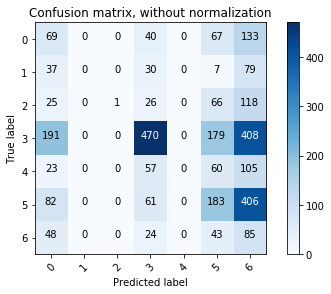

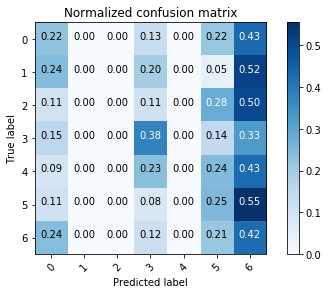

Confusion matrix, without normalization
[[ 5  0  0  6  0  8 16]
 [ 4  0  0  3  0  2  9]
 [ 4  0  0  3  0 10 10]
 [20  0  0 47  0 30 42]
 [ 4  0  0  5  0  1 18]
 [ 5  0  0  4  0 24 49]
 [ 3  0  0  1  0  5 14]]
Normalized confusion matrix
[[0.14285714 0.         0.         0.17142857 0.         0.22857143
  0.45714286]
 [0.22222222 0.         0.         0.16666667 0.         0.11111111
  0.5       ]
 [0.14814815 0.         0.         0.11111111 0.         0.37037037
  0.37037037]
 [0.14388489 0.         0.         0.3381295  0.         0.21582734
  0.30215827]
 [0.14285714 0.         0.         0.17857143 0.         0.03571429
  0.64285714]
 [0.06097561 0.         0.         0.04878049 0.         0.29268293
  0.59756098]
 [0.13043478 0.         0.         0.04347826 0.         0.2173913
  0.60869565]]


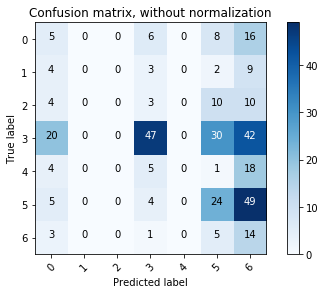

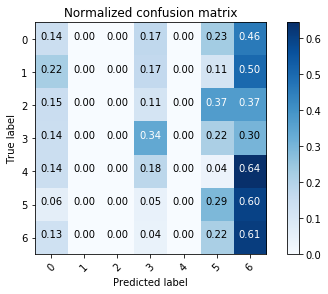

Wall time: 1h 13min 19s


In [22]:
%%time
## MobileNet, 224

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='MobileNet',
                                                    categories_count=7,
                                                    dataset_name='03_France_ByMeaning_224_3dim',
                                                    image_size=224, X_train=X_train_224_FM, y_train=y_train_224_FM,
                                                    X_test=X_test_224_FM, y_test=y_test_224_FM,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3123/3123 [==============================] - 15s 5ms/step - loss: 9.6174 - acc: 0.3993 - precision: 0.3993 - recall: 0.3993 - fmeasure: 0.3993
Epoch 2/200
3123/3123 [==============================] - 13s 4ms/step - loss: 9.5196 - acc: 0.4083 - precision: 0.4083 - recall: 0.4083 - fmeasure: 0.4083
Epoch 3/200
3123/3123 [==============================] - 13s 4ms/step - loss: 9.5103 - acc: 0.4086 - precision: 0.4086 - recall: 0.4086 - fmeasure: 0.4086
Epoch 4/200
3123/3123 [==============================] - 13s 4ms/step - loss: 9.5711 - acc: 0.4054 - precision: 0.4054 - recall: 0.4054 - fmeasure: 0.4054
Epoch 5/200
3123/3123 [==============================] - 13s 4ms/step - loss: 9.4291 - acc: 0.4140 - precision: 0.4140 - recall: 0.4140 - fmeasure: 0.4140
Epoch 6/200
3123/3123 [==============================] - 13s 4ms/step - loss: 9.4073 - acc: 0.4156 - precision: 0.4156 - recall: 0.4156 - fmeasure: 0.4156
Epoch 7/200
3123/3123 [==============================] - 13s 4ms/step 

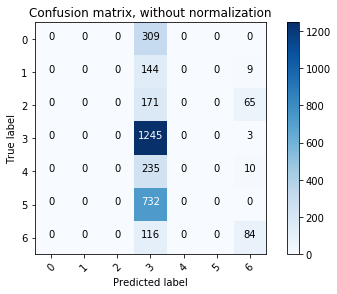

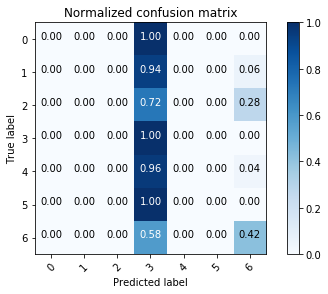

Confusion matrix, without normalization
[[  0   0   0  35   0   0   0]
 [  0   0   0  17   0   0   1]
 [  0   0   0  21   0   0   6]
 [  0   0   0 139   0   0   0]
 [  0   0   0  28   0   0   0]
 [  0   0   0  82   0   0   0]
 [  0   0   0  13   0   0  10]]
Normalized confusion matrix
[[0.         0.         0.         1.         0.         0.
  0.        ]
 [0.         0.         0.         0.94444444 0.         0.
  0.05555556]
 [0.         0.         0.         0.77777778 0.         0.
  0.22222222]
 [0.         0.         0.         1.         0.         0.
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.        ]
 [0.         0.         0.         0.56521739 0.         0.
  0.43478261]]


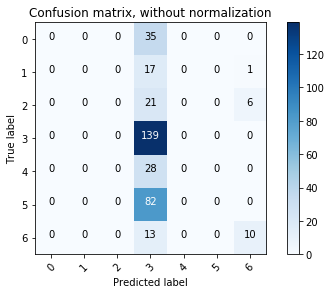

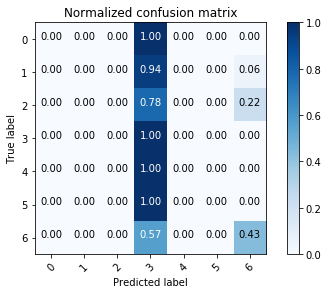

Wall time: 10min 9s


In [24]:
%%time
## SqueezeNet, 128

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='SqueezeNet',
                                                    categories_count=7,
                                                    dataset_name='03_France_ByMeaning_128_3dim',
                                                    image_size=128, X_train=X_train_128_FM, y_train=y_train_128_FM,
                                                    X_test=X_test_128_FM, y_test=y_test_128_FM,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3123/3123 [==============================] - 16s 5ms/step - loss: 9.3532 - acc: 0.4102 - precision: 0.4102 - recall: 0.4102 - fmeasure: 0.4102
Epoch 2/200
3123/3123 [==============================] - 14s 5ms/step - loss: 8.4664 - acc: 0.4685 - precision: 0.4685 - recall: 0.4685 - fmeasure: 0.4685
Epoch 3/200
3123/3123 [==============================] - 14s 5ms/step - loss: 8.0964 - acc: 0.4925 - precision: 0.4925 - recall: 0.4925 - fmeasure: 0.4925
Epoch 4/200
3123/3123 [==============================] - 14s 5ms/step - loss: 7.4530 - acc: 0.5319 - precision: 0.5319 - recall: 0.5319 - fmeasure: 0.5319
Epoch 5/200
3123/3123 [==============================] - 14s 5ms/step - loss: 7.3391 - acc: 0.5415 - precision: 0.5415 - recall: 0.5415 - fmeasure: 0.5415
Epoch 6/200
3123/3123 [==============================] - 14s 5ms/step - loss: 7.1418 - acc: 0.5530 - precision: 0.5530 - recall: 0.5530 - fmeasure: 0.5530
Epoch 7/200
3123/3123 [==============================] - 14s 5ms/step 

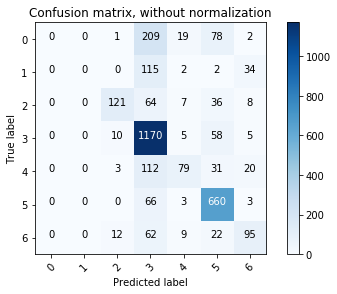

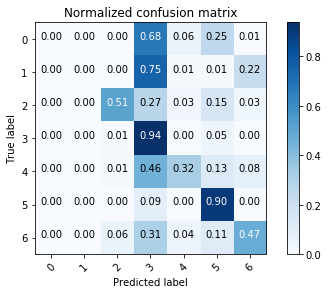

Confusion matrix, without normalization
[[  0   0   0  30   2   3   0]
 [  0   0   0  16   0   0   2]
 [  0   0  10   9   0   6   2]
 [  0   0   1 127   1   6   4]
 [  0   0   1  19   2   5   1]
 [  0   0   2  14   0  66   0]
 [  0   0   2   7   1   3  10]]
Normalized confusion matrix
[[0.         0.         0.         0.85714286 0.05714286 0.08571429
  0.        ]
 [0.         0.         0.         0.88888889 0.         0.
  0.11111111]
 [0.         0.         0.37037037 0.33333333 0.         0.22222222
  0.07407407]
 [0.         0.         0.00719424 0.91366906 0.00719424 0.04316547
  0.02877698]
 [0.         0.         0.03571429 0.67857143 0.07142857 0.17857143
  0.03571429]
 [0.         0.         0.02439024 0.17073171 0.         0.80487805
  0.        ]
 [0.         0.         0.08695652 0.30434783 0.04347826 0.13043478
  0.43478261]]


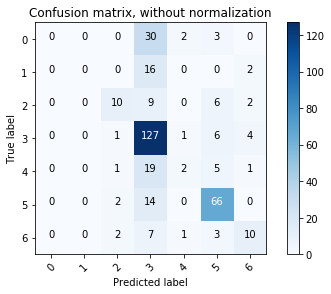

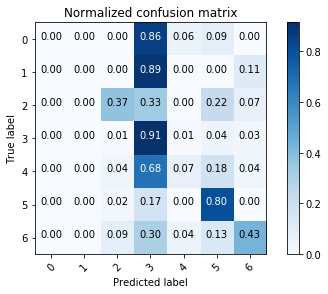

Wall time: 12min 54s


In [25]:
%%time
## SqueezeNet, 160

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='SqueezeNet',
                                                    categories_count=7,
                                                    dataset_name='03_France_ByMeaning_160_3dim',
                                                    image_size=160, X_train=X_train_160_FM, y_train=y_train_160_FM,
                                                    X_test=X_test_160_FM, y_test=y_test_160_FM,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3123/3123 [==============================] - 18s 6ms/step - loss: 9.6873 - acc: 0.3987 - precision: 0.3987 - recall: 0.3987 - fmeasure: 0.3987
Epoch 2/200
3123/3123 [==============================] - 16s 5ms/step - loss: 9.6033 - acc: 0.4031 - precision: 0.4031 - recall: 0.4031 - fmeasure: 0.4031
Epoch 3/200
3123/3123 [==============================] - 17s 5ms/step - loss: 9.5073 - acc: 0.4099 - precision: 0.4099 - recall: 0.4099 - fmeasure: 0.4099
Epoch 4/200
3123/3123 [==============================] - 17s 5ms/step - loss: 9.3842 - acc: 0.4175 - precision: 0.4175 - recall: 0.4175 - fmeasure: 0.4175
Epoch 5/200
3123/3123 [==============================] - 16s 5ms/step - loss: 9.3266 - acc: 0.4207 - precision: 0.4207 - recall: 0.4207 - fmeasure: 0.4207
Epoch 6/200
3123/3123 [==============================] - 17s 5ms/step - loss: 9.2980 - acc: 0.4230 - precision: 0.4230 - recall: 0.4230 - fmeasure: 0.4230
Epoch 7/200
3123/3123 [==============================] - 17s 5ms/step 

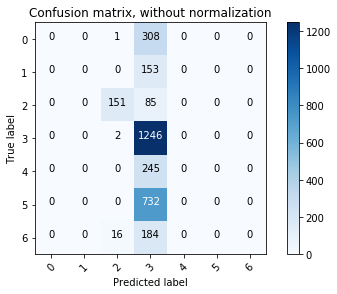

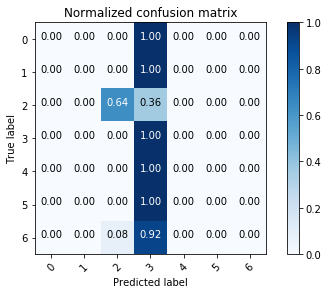

Confusion matrix, without normalization
[[  0   0   0  35   0   0   0]
 [  0   0   0  18   0   0   0]
 [  0   0  11  16   0   0   0]
 [  0   0   0 139   0   0   0]
 [  0   0   0  28   0   0   0]
 [  0   0   0  82   0   0   0]
 [  0   0   2  21   0   0   0]]
Normalized confusion matrix
[[0.         0.         0.         1.         0.         0.
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.        ]
 [0.         0.         0.40740741 0.59259259 0.         0.
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.        ]
 [0.         0.         0.08695652 0.91304348 0.         0.
  0.        ]]


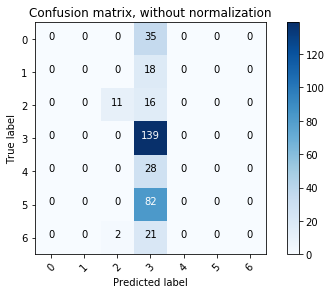

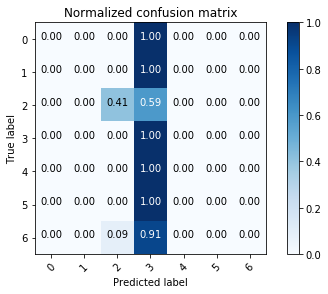

Wall time: 16min 45s


In [26]:
%%time
## SqueezeNet, 192

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='SqueezeNet',
                                                    categories_count=7,
                                                    dataset_name='03_France_ByMeaning_192_3dim',
                                                    image_size=192, X_train=X_train_192_FM, y_train=y_train_192_FM,
                                                    X_test=X_test_192_FM, y_test=y_test_192_FM,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3123/3123 [==============================] - 20s 6ms/step - loss: 11.8632 - acc: 0.2603 - precision: 0.2603 - recall: 0.2603 - fmeasure: 0.2603
Epoch 2/200
3123/3123 [==============================] - 19s 6ms/step - loss: 11.7561 - acc: 0.2693 - precision: 0.2693 - recall: 0.2693 - fmeasure: 0.2693
Epoch 3/200
3123/3123 [==============================] - 19s 6ms/step - loss: 11.6032 - acc: 0.2792 - precision: 0.2792 - recall: 0.2792 - fmeasure: 0.2792
Epoch 4/200
3123/3123 [==============================] - 19s 6ms/step - loss: 11.5471 - acc: 0.2827 - precision: 0.2827 - recall: 0.2827 - fmeasure: 0.2827
Epoch 5/200
3123/3123 [==============================] - 19s 6ms/step - loss: 11.3905 - acc: 0.2933 - precision: 0.2933 - recall: 0.2933 - fmeasure: 0.2933
Epoch 6/200
3123/3123 [==============================] - 19s 6ms/step - loss: 11.5499 - acc: 0.2834 - precision: 0.2834 - recall: 0.2834 - fmeasure: 0.2834
Epoch 7/200
3123/3123 [==============================] - 19s 6ms

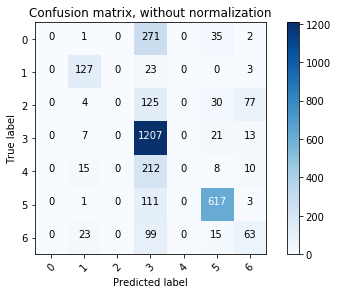

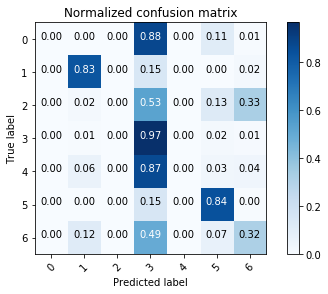

Confusion matrix, without normalization
[[  0   0   0  29   0   5   1]
 [  0  10   0   7   0   0   1]
 [  0   2   0  12   0   5   8]
 [  0   0   0 133   0   2   4]
 [  0   1   0  24   0   2   1]
 [  0   0   0  15   0  65   2]
 [  0   0   0   9   0   0  14]]
Normalized confusion matrix
[[0.         0.         0.         0.82857143 0.         0.14285714
  0.02857143]
 [0.         0.55555556 0.         0.38888889 0.         0.
  0.05555556]
 [0.         0.07407407 0.         0.44444444 0.         0.18518519
  0.2962963 ]
 [0.         0.         0.         0.95683453 0.         0.01438849
  0.02877698]
 [0.         0.03571429 0.         0.85714286 0.         0.07142857
  0.03571429]
 [0.         0.         0.         0.18292683 0.         0.79268293
  0.02439024]
 [0.         0.         0.         0.39130435 0.         0.
  0.60869565]]


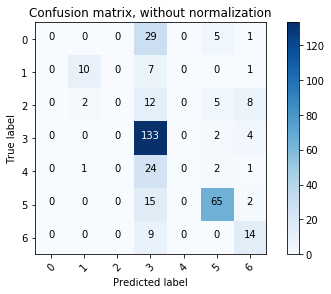

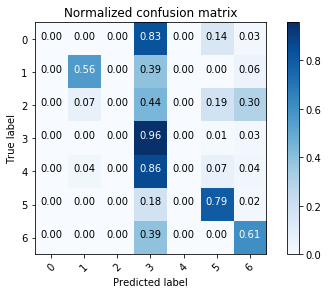

Wall time: 26min 45s


In [27]:
%%time
## SqueezeNet, 224

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='SqueezeNet',
                                                    categories_count=7,
                                                    dataset_name='03_France_ByMeaning_224_3dim',
                                                    image_size=224, X_train=X_train_224_FM, y_train=y_train_224_FM,
                                                    X_test=X_test_224_FM, y_test=y_test_224_FM,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3123/3123 [==============================] - 31s 10ms/step - loss: 2.2033 - acc: 0.4438 - precision: 0.5017 - recall: 0.3378 - fmeasure: 0.3982
Epoch 2/200
3123/3123 [==============================] - 28s 9ms/step - loss: 1.8617 - acc: 0.5520 - precision: 0.5948 - recall: 0.4694 - fmeasure: 0.5211
Epoch 3/200
3123/3123 [==============================] - 28s 9ms/step - loss: 1.8828 - acc: 0.5776 - precision: 0.6074 - recall: 0.5107 - fmeasure: 0.5523
Epoch 4/200
3123/3123 [==============================] - 28s 9ms/step - loss: 1.7345 - acc: 0.5997 - precision: 0.6348 - recall: 0.5447 - fmeasure: 0.5842
Epoch 5/200
3123/3123 [==============================] - 28s 9ms/step - loss: 1.5778 - acc: 0.6350 - precision: 0.6609 - recall: 0.5847 - fmeasure: 0.6182
Epoch 6/200
3123/3123 [==============================] - 28s 9ms/step - loss: 1.6909 - acc: 0.6318 - precision: 0.6584 - recall: 0.5898 - fmeasure: 0.6201
Epoch 7/200
3123/3123 [==============================] - 28s 9ms/step

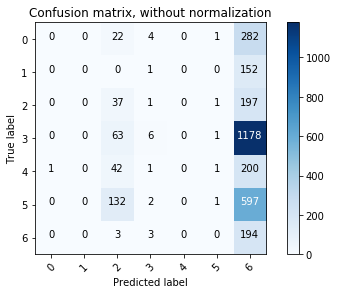

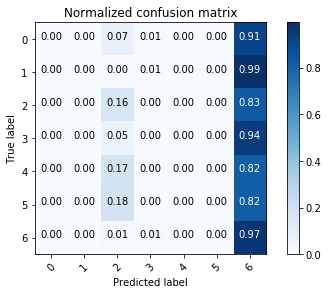

Confusion matrix, without normalization
[[  0   0   8   0   0   0  27]
 [  0   0   1   0   0   0  17]
 [  0   0   1   1   0   0  25]
 [  0   0   6   0   0   0 133]
 [  0   0   3   1   0   0  24]
 [  0   0  13   0   0   0  69]
 [  0   0   1   0   0   0  22]]
Normalized confusion matrix
[[0.         0.         0.22857143 0.         0.         0.
  0.77142857]
 [0.         0.         0.05555556 0.         0.         0.
  0.94444444]
 [0.         0.         0.03703704 0.03703704 0.         0.
  0.92592593]
 [0.         0.         0.04316547 0.         0.         0.
  0.95683453]
 [0.         0.         0.10714286 0.03571429 0.         0.
  0.85714286]
 [0.         0.         0.15853659 0.         0.         0.
  0.84146341]
 [0.         0.         0.04347826 0.         0.         0.
  0.95652174]]


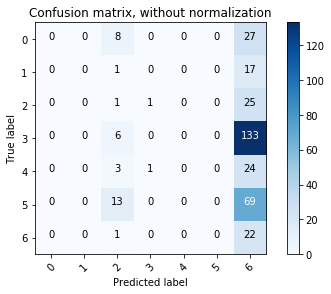

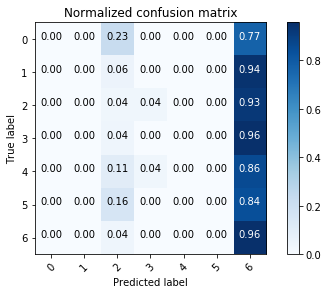

Wall time: 17min 58s


In [28]:
%%time
## Xception, 128

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='Xception',
                                                    categories_count=7,
                                                    dataset_name='03_France_ByMeaning_128_3dim',
                                                    image_size=128, X_train=X_train_128_FM, y_train=y_train_128_FM,
                                                    X_test=X_test_128_FM, y_test=y_test_128_FM,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3123/3123 [==============================] - 34s 11ms/step - loss: 2.4964 - acc: 0.4579 - precision: 0.4851 - recall: 0.4035 - fmeasure: 0.4376
Epoch 2/200
3123/3123 [==============================] - 29s 9ms/step - loss: 1.8348 - acc: 0.6116 - precision: 0.6347 - recall: 0.5837 - fmeasure: 0.6067
Epoch 3/200
3123/3123 [==============================] - 30s 9ms/step - loss: 1.7395 - acc: 0.6526 - precision: 0.6724 - recall: 0.6350 - fmeasure: 0.6522
Epoch 4/200
3123/3123 [==============================] - 30s 10ms/step - loss: 1.6403 - acc: 0.6836 - precision: 0.6993 - recall: 0.6692 - fmeasure: 0.6832
Epoch 5/200
3123/3123 [==============================] - 30s 10ms/step - loss: 1.5464 - acc: 0.7157 - precision: 0.7267 - recall: 0.6964 - fmeasure: 0.7104
Epoch 6/200
3123/3123 [==============================] - 30s 10ms/step - loss: 1.3134 - acc: 0.7355 - precision: 0.7478 - recall: 0.7227 - fmeasure: 0.7343
Epoch 7/200
3123/3123 [==============================] - 30s 9ms/s

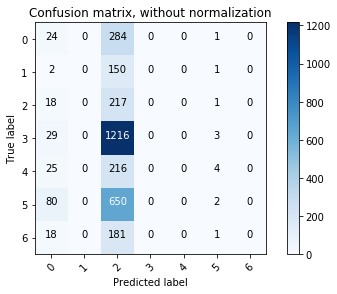

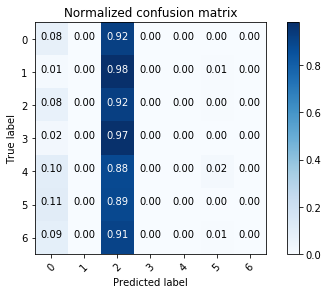

Confusion matrix, without normalization
[[  4   0  31   0   0   0   0]
 [  0   0  18   0   0   0   0]
 [  1   0  26   0   0   0   0]
 [  4   0 135   0   0   0   0]
 [  2   0  26   0   0   0   0]
 [  9   0  72   0   0   1   0]
 [  1   0  22   0   0   0   0]]
Normalized confusion matrix
[[0.11428571 0.         0.88571429 0.         0.         0.
  0.        ]
 [0.         0.         1.         0.         0.         0.
  0.        ]
 [0.03703704 0.         0.96296296 0.         0.         0.
  0.        ]
 [0.02877698 0.         0.97122302 0.         0.         0.
  0.        ]
 [0.07142857 0.         0.92857143 0.         0.         0.
  0.        ]
 [0.1097561  0.         0.87804878 0.         0.         0.01219512
  0.        ]
 [0.04347826 0.         0.95652174 0.         0.         0.
  0.        ]]


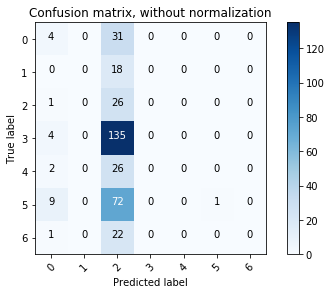

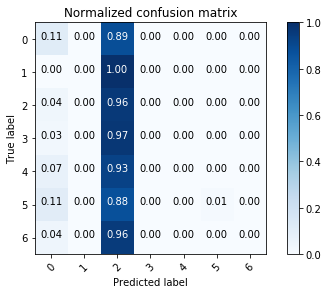

Wall time: 19min 35s


In [29]:
%%time
## Xception, 160

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='Xception',
                                                    categories_count=7,
                                                    dataset_name='03_France_ByMeaning_160_3dim',
                                                    image_size=160, X_train=X_train_160_FM, y_train=y_train_160_FM,
                                                    X_test=X_test_160_FM, y_test=y_test_160_FM,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3123/3123 [==============================] - 34s 11ms/step - loss: 2.7448 - acc: 0.5062 - precision: 0.5224 - recall: 0.4864 - fmeasure: 0.5027
Epoch 2/200
3123/3123 [==============================] - 29s 9ms/step - loss: 2.2016 - acc: 0.6510 - precision: 0.6623 - recall: 0.6414 - fmeasure: 0.6510
Epoch 3/200
3123/3123 [==============================] - 29s 9ms/step - loss: 1.9557 - acc: 0.7048 - precision: 0.7083 - recall: 0.6977 - fmeasure: 0.7026
Epoch 4/200
3123/3123 [==============================] - 29s 9ms/step - loss: 1.6139 - acc: 0.7563 - precision: 0.7644 - recall: 0.7528 - fmeasure: 0.7582
Epoch 5/200
3123/3123 [==============================] - 29s 9ms/step - loss: 1.6356 - acc: 0.7663 - precision: 0.7707 - recall: 0.7637 - fmeasure: 0.7670
Epoch 6/200
3123/3123 [==============================] - 29s 9ms/step - loss: 1.5377 - acc: 0.7743 - precision: 0.7783 - recall: 0.7717 - fmeasure: 0.7748
Epoch 7/200
3123/3123 [==============================] - 29s 9ms/step

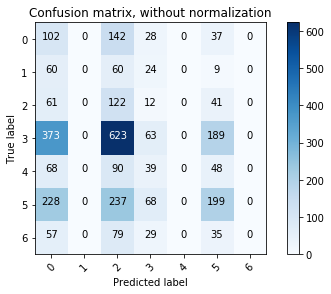

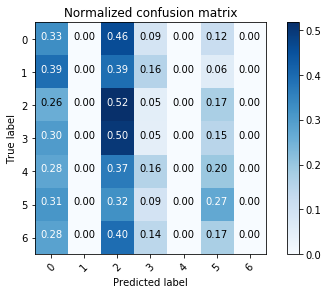

Confusion matrix, without normalization
[[ 8  0 15  3  0  9  0]
 [ 9  0  8  0  0  1  0]
 [ 4  0 17  2  0  4  0]
 [38  0 68  6  0 27  0]
 [13  0  9  2  0  4  0]
 [30  0 22  3  0 27  0]
 [ 3  0 12  5  0  3  0]]
Normalized confusion matrix
[[0.22857143 0.         0.42857143 0.08571429 0.         0.25714286
  0.        ]
 [0.5        0.         0.44444444 0.         0.         0.05555556
  0.        ]
 [0.14814815 0.         0.62962963 0.07407407 0.         0.14814815
  0.        ]
 [0.27338129 0.         0.48920863 0.04316547 0.         0.1942446
  0.        ]
 [0.46428571 0.         0.32142857 0.07142857 0.         0.14285714
  0.        ]
 [0.36585366 0.         0.26829268 0.03658537 0.         0.32926829
  0.        ]
 [0.13043478 0.         0.52173913 0.2173913  0.         0.13043478
  0.        ]]


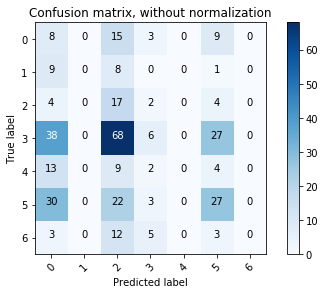

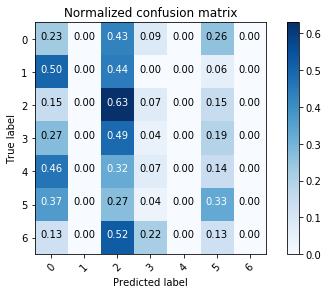

Wall time: 21min 38s


In [30]:
%%time
## Xception, 192

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='Xception',
                                                    categories_count=7,
                                                    dataset_name='03_France_ByMeaning_192_3dim',
                                                    image_size=192, X_train=X_train_192_FM, y_train=y_train_192_FM,
                                                    X_test=X_test_192_FM, y_test=y_test_192_FM,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

In [13]:
parameters_df = pd.read_csv('./PARAMETERS_AND_RESULTS/04_04_params_France_WithoutRetrain.csv', sep='\t', index_col=0)
results_df = pd.read_csv('./PARAMETERS_AND_RESULTS/04_04_results_France_WithoutRetrain.csv', sep='\t', index_col=0)

Epoch 1/200
3123/3123 [==============================] - 151s 48ms/step - loss: 9.3627 - acc: 0.3826 - precision: 0.3826 - recall: 0.3826 - fmeasure: 0.3826
Epoch 2/200
3123/3123 [==============================] - 146s 47ms/step - loss: 9.3532 - acc: 0.4086 - precision: 0.4086 - recall: 0.4086 - fmeasure: 0.4086
Epoch 3/200
3123/3123 [==============================] - 147s 47ms/step - loss: 9.0174 - acc: 0.4198 - precision: 0.4198 - recall: 0.4198 - fmeasure: 0.4198
Epoch 4/200
3123/3123 [==============================] - 147s 47ms/step - loss: 8.3671 - acc: 0.4624 - precision: 0.4624 - recall: 0.4624 - fmeasure: 0.4624
Epoch 5/200
3123/3123 [==============================] - 147s 47ms/step - loss: 7.8873 - acc: 0.4906 - precision: 0.4906 - recall: 0.4906 - fmeasure: 0.4906
Epoch 6/200
3123/3123 [==============================] - 147s 47ms/step - loss: 8.0288 - acc: 0.4854 - precision: 0.4854 - recall: 0.4854 - fmeasure: 0.4854
Epoch 7/200
3123/3123 [==============================] - 1

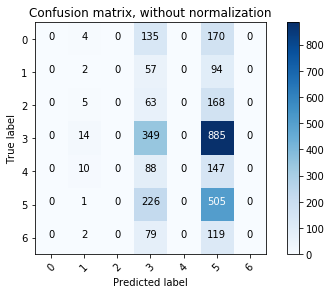

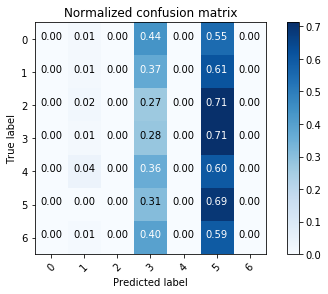

Confusion matrix, without normalization
[[  0   0   0  10   0  25   0]
 [  0   0   0   6   0  12   0]
 [  0   1   0   7   0  19   0]
 [  0   0   0  34   0 105   0]
 [  0   1   0   6   0  21   0]
 [  0   0   0  28   0  54   0]
 [  0   0   0   7   0  16   0]]
Normalized confusion matrix
[[0.         0.         0.         0.28571429 0.         0.71428571
  0.        ]
 [0.         0.         0.         0.33333333 0.         0.66666667
  0.        ]
 [0.         0.03703704 0.         0.25925926 0.         0.7037037
  0.        ]
 [0.         0.         0.         0.24460432 0.         0.75539568
  0.        ]
 [0.         0.03571429 0.         0.21428571 0.         0.75
  0.        ]
 [0.         0.         0.         0.34146341 0.         0.65853659
  0.        ]
 [0.         0.         0.         0.30434783 0.         0.69565217
  0.        ]]


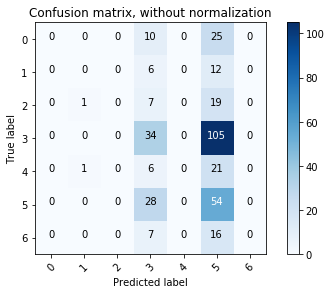

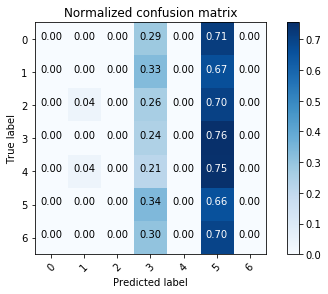

Wall time: 2h 43min 44s


In [14]:
%%time
## Xception, 224

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='Xception',
                                                    categories_count=7,
                                                    dataset_name='03_France_ByMeaning_224_3dim',
                                                    image_size=224, X_train=X_train_224_FM, y_train=y_train_224_FM,
                                                    X_test=X_test_224_FM, y_test=y_test_224_FM,
                                                    batch_size_small_net=2, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3123/3123 [==============================] - 19s 6ms/step - loss: 7.6051 - acc: 0.4838 - precision: 0.4838 - recall: 0.4838 - fmeasure: 0.4838
Epoch 2/200
3123/3123 [==============================] - 17s 5ms/step - loss: 6.6232 - acc: 0.5661 - precision: 0.5661 - recall: 0.5661 - fmeasure: 0.5661
Epoch 3/200
3123/3123 [==============================] - 17s 5ms/step - loss: 6.3179 - acc: 0.5825 - precision: 0.5825 - recall: 0.5825 - fmeasure: 0.5825
Epoch 4/200
3123/3123 [==============================] - 17s 5ms/step - loss: 6.3460 - acc: 0.5885 - precision: 0.5885 - recall: 0.5885 - fmeasure: 0.5885
Epoch 5/200
3123/3123 [==============================] - 17s 5ms/step - loss: 6.1065 - acc: 0.6026 - precision: 0.6026 - recall: 0.6026 - fmeasure: 0.6026
Epoch 6/200
3123/3123 [==============================] - 17s 5ms/step - loss: 6.1346 - acc: 0.6065 - precision: 0.6065 - recall: 0.6065 - fmeasure: 0.6065
Epoch 7/200
3123/3123 [==============================] - 17s 5ms/step 

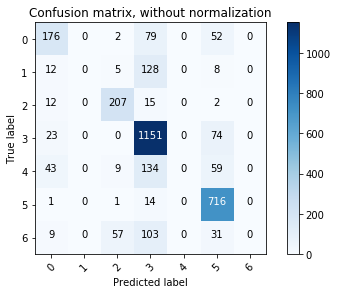

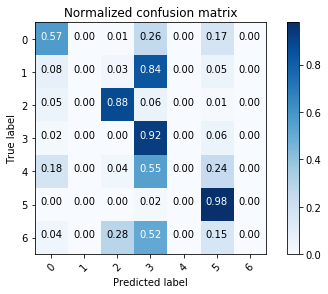

Confusion matrix, without normalization
[[ 10   0   1  20   0   4   0]
 [  0   0   0  18   0   0   0]
 [  2   0  15   7   0   3   0]
 [ 16   0   2 108   0  13   0]
 [  3   0   0  13   0  12   0]
 [  4   0   1   8   0  69   0]
 [  2   0  11   8   0   2   0]]
Normalized confusion matrix
[[0.28571429 0.         0.02857143 0.57142857 0.         0.11428571
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.        ]
 [0.07407407 0.         0.55555556 0.25925926 0.         0.11111111
  0.        ]
 [0.11510791 0.         0.01438849 0.77697842 0.         0.09352518
  0.        ]
 [0.10714286 0.         0.         0.46428571 0.         0.42857143
  0.        ]
 [0.04878049 0.         0.01219512 0.09756098 0.         0.84146341
  0.        ]
 [0.08695652 0.         0.47826087 0.34782609 0.         0.08695652
  0.        ]]


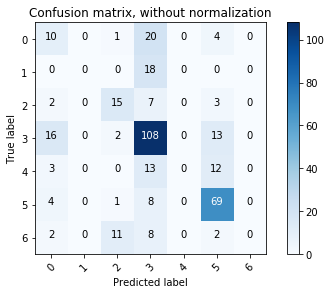

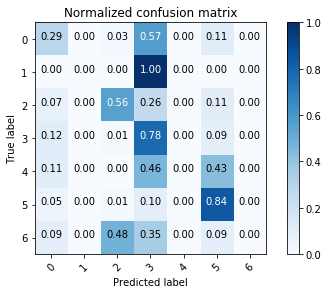

Wall time: 16min 2s


In [15]:
%%time
## VGG16, 128

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG16',
                                                    categories_count=7,
                                                    dataset_name='03_France_ByMeaning_128_3dim',
                                                    image_size=128, X_train=X_train_128_FM, y_train=y_train_128_FM,
                                                    X_test=X_test_128_FM, y_test=y_test_128_FM,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

In [14]:
parameters_df = pd.read_csv('./PARAMETERS_AND_RESULTS/04_04_params_France_WithoutRetrain.csv', sep='\t', index_col=0)
results_df = pd.read_csv('./PARAMETERS_AND_RESULTS/04_04_results_France_WithoutRetrain.csv', sep='\t', index_col=0)

In [17]:
X_train_shuffled, y_train_shuffled = shuffle_Xy(X_train_160_FM, y_train_160_FM)
    
model_app = create_net_with_name('VGG16', X_train_shuffled)
model_app.trainable = False


In [18]:
model = Sequential()
model.add(model_app)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', precision, recall, fmeasure])
callback = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto')
history_callback = model.fit(X_train_shuffled, one_hot(y_train_shuffled, 7),
                                 epochs=200, batch_size=4, callbacks=[callback])
    

Epoch 1/200
3123/3123 [==============================] - 36s 12ms/step - loss: 8.0571 - acc: 0.4733 - precision: 0.4733 - recall: 0.4729 - fmeasure: 0.4731
Epoch 2/200
3123/3123 [==============================] - 35s 11ms/step - loss: 6.9590 - acc: 0.5517 - precision: 0.5517 - recall: 0.5517 - fmeasure: 0.5517
Epoch 3/200
3123/3123 [==============================] - 35s 11ms/step - loss: 6.6439 - acc: 0.5741 - precision: 0.5741 - recall: 0.5741 - fmeasure: 0.5741
Epoch 4/200
3123/3123 [==============================] - 35s 11ms/step - loss: 6.0838 - acc: 0.6093 - precision: 0.6092 - recall: 0.6090 - fmeasure: 0.6091
Epoch 5/200
3123/3123 [==============================] - 36s 11ms/step - loss: 5.6403 - acc: 0.6394 - precision: 0.6394 - recall: 0.6394 - fmeasure: 0.6394
Epoch 6/200
3123/3123 [==============================] - 37s 12ms/step - loss: 5.5496 - acc: 0.6430 - precision: 0.6430 - recall: 0.6430 - fmeasure: 0.6430
Epoch 7/200
3123/3123 [==============================] - 36s 11m

In [19]:
scores_test = model.evaluate(X_test_160_FM, one_hot(y_test_160_FM, 7))

352/352 [==============================] - 3s 7ms/step


Confusion matrix, without normalization
[[   0    3    3  226   26   48    3]
 [   0  146    0    7    0    0    0]
 [   0    4  191   36    1    3    1]
 [   0    5    0 1232    3    7    1]
 [   0    5    1   51  168    4   16]
 [   0    1    1   40    1  688    1]
 [   0    6    3   43    4    3  141]]
Normalized confusion matrix
[[0.00000000e+00 9.70873786e-03 9.70873786e-03 7.31391586e-01
  8.41423948e-02 1.55339806e-01 9.70873786e-03]
 [0.00000000e+00 9.54248366e-01 0.00000000e+00 4.57516340e-02
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.69491525e-02 8.09322034e-01 1.52542373e-01
  4.23728814e-03 1.27118644e-02 4.23728814e-03]
 [0.00000000e+00 4.00641026e-03 0.00000000e+00 9.87179487e-01
  2.40384615e-03 5.60897436e-03 8.01282051e-04]
 [0.00000000e+00 2.04081633e-02 4.08163265e-03 2.08163265e-01
  6.85714286e-01 1.63265306e-02 6.53061224e-02]
 [0.00000000e+00 1.36612022e-03 1.36612022e-03 5.46448087e-02
  1.36612022e-03 9.39890710e-01 1.36612022e-03]
 [0.0

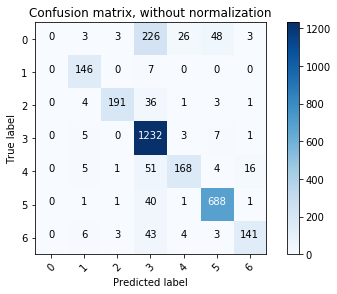

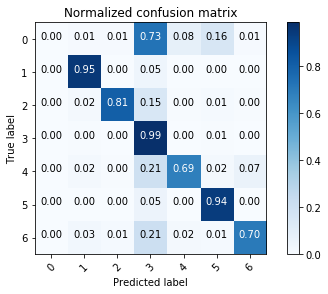

Confusion matrix, without normalization
[[  0   0   1  29   2   3   0]
 [  0  11   0   5   1   0   1]
 [  0   1  14   8   0   1   3]
 [  0   0   0 136   2   1   0]
 [  0   0   1  17   8   2   0]
 [  0   0   1  17   0  63   1]
 [  0   0   1  10   0   0  12]]
Normalized confusion matrix
[[0.         0.         0.02857143 0.82857143 0.05714286 0.08571429
  0.        ]
 [0.         0.61111111 0.         0.27777778 0.05555556 0.
  0.05555556]
 [0.         0.03703704 0.51851852 0.2962963  0.         0.03703704
  0.11111111]
 [0.         0.         0.         0.97841727 0.01438849 0.00719424
  0.        ]
 [0.         0.         0.03571429 0.60714286 0.28571429 0.07142857
  0.        ]
 [0.         0.         0.01219512 0.20731707 0.         0.76829268
  0.01219512]
 [0.         0.         0.04347826 0.43478261 0.         0.
  0.52173913]]


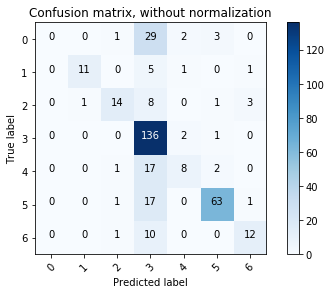

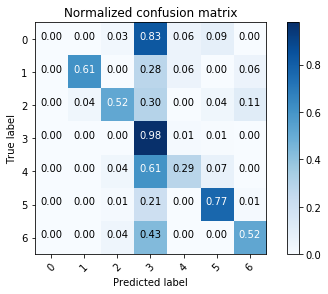

In [20]:
y_pred_train = model.predict(X_train_160_FM)
cnf_matrix = confusion_matrix(one_hot(y_train_160_FM, 7).argmax(axis=1), (y_pred_train.round()).argmax(axis=1))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(7),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(7), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

y_pred_test = model.predict(X_test_160_FM)
cnf_matrix = confusion_matrix(one_hot(y_test_160_FM, 7).argmax(axis=1), (y_pred_test.round()).argmax(axis=1))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(7),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(7), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [22]:
loss_best = min(history_callback.history['loss'])
accuracy_best = max(history_callback.history['acc'])
precision_best = max(history_callback.history['precision'])
recall_best = max(history_callback.history['recall'])
fmeasure_best = max(history_callback.history['fmeasure'])
    
# write in dataframes
parameters = {'net_name':'VGG16', 'dataset_name':'03_France_ByMeaning_160_3dim', 
                  'train_or_test':'train', 'image_size':160, 
                  'batch_size_app':-1, 'batch_size_small_net':10, 'dense_1':0.5, 'dense_2':-1,
                  'activation_1':'relu', 'activation_2':'relu', 'optimiser':'adam'}
parameters_df = parameters_df.append(parameters, ignore_index=True)
results = {'net_name':'VGG16','dataset_name':'03_France_ByMeaning_160_3dim', 'train_or_test':'train',
               'loss':loss_best, 'accuracy':accuracy_best, 'precision':precision_best,
               'recall':recall_best, 'fmeasure':fmeasure_best}
results_df = results_df.append(results, ignore_index=True)
    
# evaluate on test
parameters = {'net_name':'VGG16', 'dataset_name':'03_France_ByMeaning_160_3dim', 
                  'train_or_test':'test', 'image_size':160, 
                  'batch_size_app':-1, 'batch_size_small_net':10, 'dense_1':0.5, 'dense_2':-1,
                  'activation_1':'relu', 'activation_2':'relu', 'optimiser':'adam'}
parameters_df = parameters_df.append(parameters, ignore_index=True)
results = {'net_name':'VGG16','dataset_name':'03_France_ByMeaning_160_3dim', 'train_or_test':'test',
               'loss':scores_test[0], 'accuracy':scores_test[1],
               'precision':scores_test[2], 'recall':scores_test[3], 'fmeasure':scores_test[4]}
results_df = results_df.append(results, ignore_index=True)
    
parameters_df.to_csv('./PARAMETERS_AND_RESULTS/04_04_params_France_WithoutRetrain.csv', sep='\t')
results_df.to_csv('./PARAMETERS_AND_RESULTS/04_04_results_France_WithoutRetrain.csv', sep='\t')

Epoch 1/200
3123/3123 [==============================] - 41s 13ms/step - loss: 7.5039 - acc: 0.5165 - precision: 0.5165 - recall: 0.5165 - fmeasure: 0.5165
Epoch 2/200
3123/3123 [==============================] - 40s 13ms/step - loss: 7.2519 - acc: 0.5421 - precision: 0.5421 - recall: 0.5421 - fmeasure: 0.5421
Epoch 3/200
3123/3123 [==============================] - 40s 13ms/step - loss: 6.9260 - acc: 0.5645 - precision: 0.5645 - recall: 0.5645 - fmeasure: 0.5645
Epoch 4/200
3123/3123 [==============================] - 40s 13ms/step - loss: 6.8480 - acc: 0.5703 - precision: 0.5703 - recall: 0.5703 - fmeasure: 0.5703
Epoch 5/200
3123/3123 [==============================] - 40s 13ms/step - loss: 6.8026 - acc: 0.5735 - precision: 0.5735 - recall: 0.5735 - fmeasure: 0.5735
Epoch 6/200
3123/3123 [==============================] - 40s 13ms/step - loss: 6.7408 - acc: 0.5764 - precision: 0.5764 - recall: 0.5764 - fmeasure: 0.5764
Epoch 7/200
3123/3123 [==============================] - 40s 13m

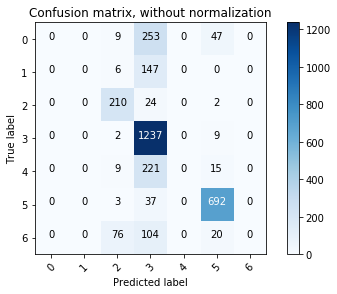

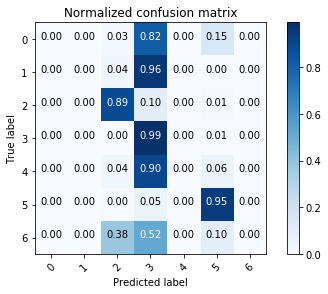

Confusion matrix, without normalization
[[  0   0   1  30   0   4   0]
 [  0   0   0  18   0   0   0]
 [  0   0  18   8   0   1   0]
 [  0   0   1 137   0   1   0]
 [  0   0   4  21   0   3   0]
 [  0   0   1  17   0  64   0]
 [  0   0  10  12   0   1   0]]
Normalized confusion matrix
[[0.         0.         0.02857143 0.85714286 0.         0.11428571
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.        ]
 [0.         0.         0.66666667 0.2962963  0.         0.03703704
  0.        ]
 [0.         0.         0.00719424 0.98561151 0.         0.00719424
  0.        ]
 [0.         0.         0.14285714 0.75       0.         0.10714286
  0.        ]
 [0.         0.         0.01219512 0.20731707 0.         0.7804878
  0.        ]
 [0.         0.         0.43478261 0.52173913 0.         0.04347826
  0.        ]]


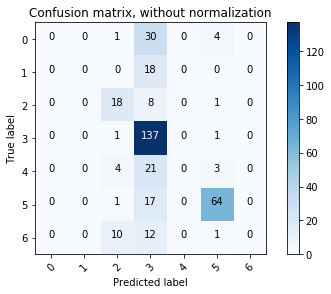

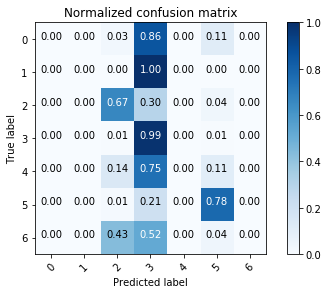

Wall time: 49min 37s


In [23]:
%%time
## VGG16, 192

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG16',
                                                    categories_count=7,
                                                    dataset_name='03_France_ByMeaning_192_3dim',
                                                    image_size=192, X_train=X_train_192_FM, y_train=y_train_192_FM,
                                                    X_test=X_test_192_FM, y_test=y_test_192_FM,
                                                    batch_size_small_net=4, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3123/3123 [==============================] - 34s 11ms/step - loss: 6.5889 - acc: 0.5632 - precision: 0.5632 - recall: 0.5632 - fmeasure: 0.5632
Epoch 2/200
3123/3123 [==============================] - 33s 11ms/step - loss: 5.8315 - acc: 0.6298 - precision: 0.6298 - recall: 0.6298 - fmeasure: 0.6298
Epoch 3/200
3123/3123 [==============================] - 33s 10ms/step - loss: 5.7563 - acc: 0.6359 - precision: 0.6361 - recall: 0.6359 - fmeasure: 0.6360
Epoch 4/200
3123/3123 [==============================] - 33s 11ms/step - loss: 5.5536 - acc: 0.6452 - precision: 0.6452 - recall: 0.6452 - fmeasure: 0.6452
Epoch 5/200
3123/3123 [==============================] - 33s 10ms/step - loss: 5.6197 - acc: 0.6407 - precision: 0.6407 - recall: 0.6407 - fmeasure: 0.6407
Epoch 6/200
3123/3123 [==============================] - 34s 11ms/step - loss: 5.4707 - acc: 0.6567 - precision: 0.6567 - recall: 0.6567 - fmeasure: 0.6567
Epoch 7/200
3123/3123 [==============================] - 33s 11m

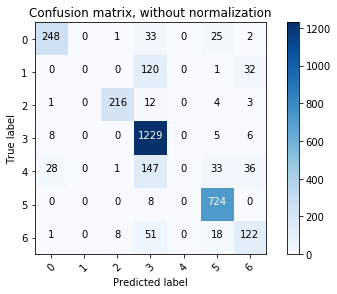

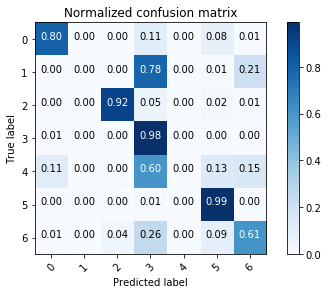

Confusion matrix, without normalization
[[ 13   0   0  16   0   3   3]
 [  0   0   0  17   0   0   1]
 [  1   0  15   6   0   1   4]
 [  4   0   0 126   0   7   2]
 [  7   0   1  12   0   4   4]
 [  3   0   0   1   0  74   4]
 [  0   0   0   9   0   1  13]]
Normalized confusion matrix
[[0.37142857 0.         0.         0.45714286 0.         0.08571429
  0.08571429]
 [0.         0.         0.         0.94444444 0.         0.
  0.05555556]
 [0.03703704 0.         0.55555556 0.22222222 0.         0.03703704
  0.14814815]
 [0.02877698 0.         0.         0.90647482 0.         0.05035971
  0.01438849]
 [0.25       0.         0.03571429 0.42857143 0.         0.14285714
  0.14285714]
 [0.03658537 0.         0.         0.01219512 0.         0.90243902
  0.04878049]
 [0.         0.         0.         0.39130435 0.         0.04347826
  0.56521739]]


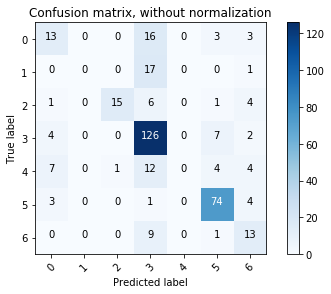

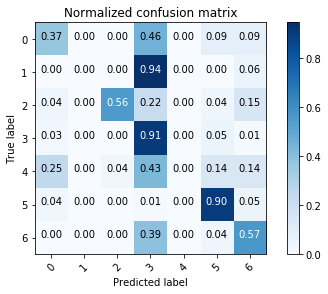

Wall time: 57min 33s


In [24]:
%%time
## VGG16, 224

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG16',
                                                    categories_count=7,
                                                    dataset_name='03_France_ByMeaning_224_3dim',
                                                    image_size=224, X_train=X_train_224_FM, y_train=y_train_224_FM,
                                                    X_test=X_test_224_FM, y_test=y_test_224_FM,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3123/3123 [==============================] - 19s 6ms/step - loss: 10.0854 - acc: 0.3481 - precision: 0.3477 - recall: 0.3474 - fmeasure: 0.3475
Epoch 2/200
3123/3123 [==============================] - 18s 6ms/step - loss: 6.9010 - acc: 0.5370 - precision: 0.5375 - recall: 0.5370 - fmeasure: 0.5372
Epoch 3/200
3123/3123 [==============================] - 18s 6ms/step - loss: 6.0985 - acc: 0.5889 - precision: 0.5885 - recall: 0.5882 - fmeasure: 0.5884
Epoch 4/200
3123/3123 [==============================] - 18s 6ms/step - loss: 5.8717 - acc: 0.6145 - precision: 0.6145 - recall: 0.6145 - fmeasure: 0.6145
Epoch 5/200
3123/3123 [==============================] - 18s 6ms/step - loss: 5.4045 - acc: 0.6468 - precision: 0.6468 - recall: 0.6468 - fmeasure: 0.6468
Epoch 6/200
3123/3123 [==============================] - 18s 6ms/step - loss: 5.3910 - acc: 0.6484 - precision: 0.6486 - recall: 0.6484 - fmeasure: 0.6485
Epoch 7/200
3123/3123 [==============================] - 18s 6ms/step

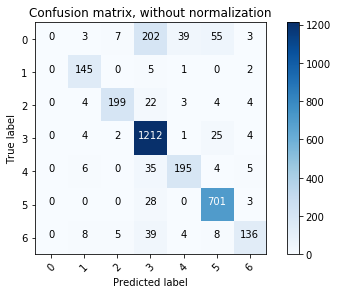

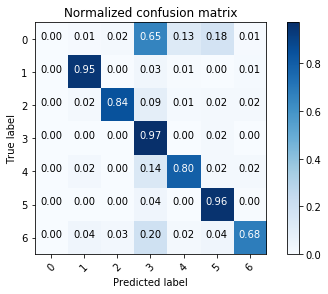

Confusion matrix, without normalization
[[  0   2   0  29   2   2   0]
 [  0  14   0   3   0   0   1]
 [  0   3  12   6   0   0   6]
 [  0   3   1 123   4   5   3]
 [  0   0   3  17   4   2   2]
 [  0   0   1  16   0  65   0]
 [  0   0   1   9   0   0  13]]
Normalized confusion matrix
[[0.         0.05714286 0.         0.82857143 0.05714286 0.05714286
  0.        ]
 [0.         0.77777778 0.         0.16666667 0.         0.
  0.05555556]
 [0.         0.11111111 0.44444444 0.22222222 0.         0.
  0.22222222]
 [0.         0.02158273 0.00719424 0.88489209 0.02877698 0.03597122
  0.02158273]
 [0.         0.         0.10714286 0.60714286 0.14285714 0.07142857
  0.07142857]
 [0.         0.         0.01219512 0.19512195 0.         0.79268293
  0.        ]
 [0.         0.         0.04347826 0.39130435 0.         0.
  0.56521739]]


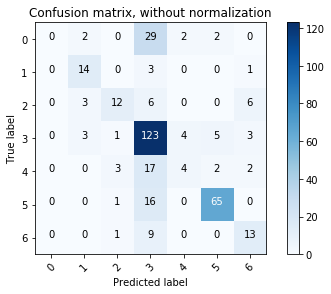

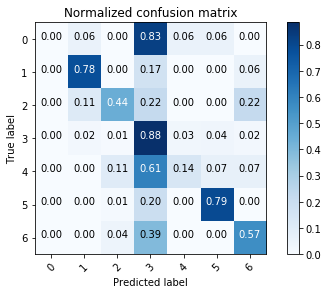

Wall time: 23min 13s


In [25]:
%%time
## VGG19, 128

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG19',
                                                    categories_count=7,
                                                    dataset_name='03_France_ByMeaning_128_3dim',
                                                    image_size=128, X_train=X_train_128_FM, y_train=y_train_128_FM,
                                                    X_test=X_test_128_FM, y_test=y_test_128_FM,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3123/3123 [==============================] - 26s 8ms/step - loss: 8.6614 - acc: 0.4457 - precision: 0.4457 - recall: 0.4457 - fmeasure: 0.4457
Epoch 2/200
3123/3123 [==============================] - 25s 8ms/step - loss: 7.2345 - acc: 0.5376 - precision: 0.5376 - recall: 0.5376 - fmeasure: 0.5376
Epoch 3/200
3123/3123 [==============================] - 25s 8ms/step - loss: 6.9961 - acc: 0.5543 - precision: 0.5543 - recall: 0.5543 - fmeasure: 0.5543
Epoch 4/200
3123/3123 [==============================] - 25s 8ms/step - loss: 7.0456 - acc: 0.5533 - precision: 0.5533 - recall: 0.5533 - fmeasure: 0.5533
Epoch 5/200
3123/3123 [==============================] - 24s 8ms/step - loss: 6.8895 - acc: 0.5642 - precision: 0.5642 - recall: 0.5642 - fmeasure: 0.5642
Epoch 6/200
3123/3123 [==============================] - 25s 8ms/step - loss: 6.8067 - acc: 0.5712 - precision: 0.5712 - recall: 0.5712 - fmeasure: 0.5712
Epoch 7/200
3123/3123 [==============================] - 25s 8ms/step 

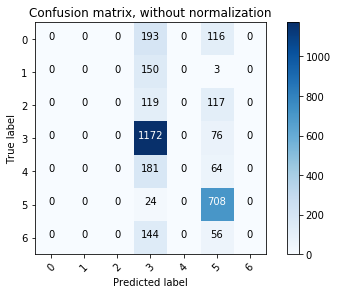

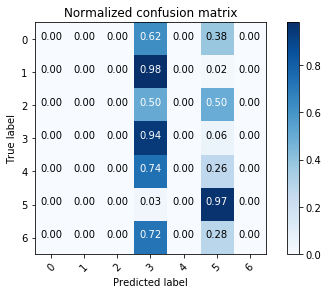

Confusion matrix, without normalization
[[  0   0   0  31   0   4   0]
 [  0   0   0  18   0   0   0]
 [  0   0   0  14   0  13   0]
 [  0   0   0 128   0  11   0]
 [  0   0   0  19   0   9   0]
 [  0   0   0   9   0  73   0]
 [  0   0   0   9   0  14   0]]
Normalized confusion matrix
[[0.         0.         0.         0.88571429 0.         0.11428571
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.        ]
 [0.         0.         0.         0.51851852 0.         0.48148148
  0.        ]
 [0.         0.         0.         0.92086331 0.         0.07913669
  0.        ]
 [0.         0.         0.         0.67857143 0.         0.32142857
  0.        ]
 [0.         0.         0.         0.1097561  0.         0.8902439
  0.        ]
 [0.         0.         0.         0.39130435 0.         0.60869565
  0.        ]]


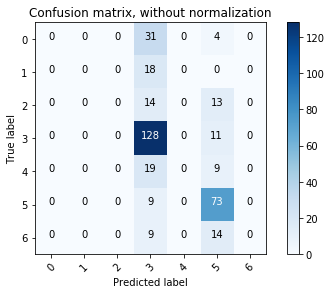

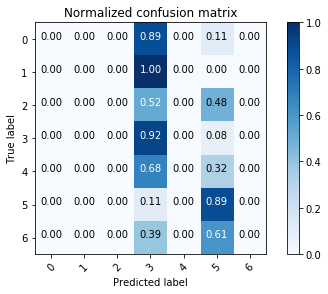

Wall time: 15min 3s


In [26]:
%%time
## VGG19, 160

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG19',
                                                    categories_count=7,
                                                    dataset_name='03_France_ByMeaning_160_3dim',
                                                    image_size=160, X_train=X_train_160_FM, y_train=y_train_160_FM,
                                                    X_test=X_test_160_FM, y_test=y_test_160_FM,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3123/3123 [==============================] - 44s 14ms/step - loss: 9.6458 - acc: 0.3932 - precision: 0.3934 - recall: 0.3932 - fmeasure: 0.3933
Epoch 2/200
3123/3123 [==============================] - 44s 14ms/step - loss: 9.3617 - acc: 0.4143 - precision: 0.4143 - recall: 0.4143 - fmeasure: 0.4143
Epoch 3/200
3123/3123 [==============================] - 44s 14ms/step - loss: 9.1433 - acc: 0.4313 - precision: 0.4313 - recall: 0.4313 - fmeasure: 0.4313
Epoch 4/200
3123/3123 [==============================] - 44s 14ms/step - loss: 9.1288 - acc: 0.4304 - precision: 0.4304 - recall: 0.4304 - fmeasure: 0.4304
Epoch 5/200
3123/3123 [==============================] - 43s 14ms/step - loss: 8.9463 - acc: 0.4432 - precision: 0.4432 - recall: 0.4432 - fmeasure: 0.4432
Epoch 6/200
3123/3123 [==============================] - 44s 14ms/step - loss: 9.0975 - acc: 0.4339 - precision: 0.4339 - recall: 0.4339 - fmeasure: 0.4339
Epoch 7/200
3123/3123 [==============================] - 44s 14m

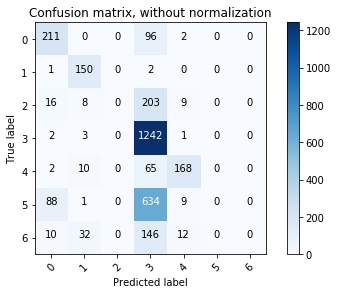

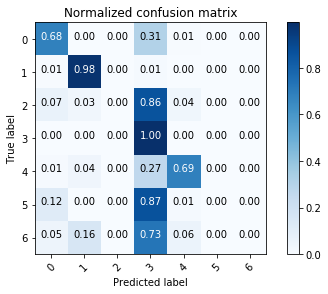

Confusion matrix, without normalization
[[  7   0   0  28   0   0   0]
 [  0  15   0   3   0   0   0]
 [  2   3   0  22   0   0   0]
 [  2   0   0 136   1   0   0]
 [  1   0   0  23   4   0   0]
 [  7   1   0  73   1   0   0]
 [  1   0   0  20   2   0   0]]
Normalized confusion matrix
[[0.2        0.         0.         0.8        0.         0.
  0.        ]
 [0.         0.83333333 0.         0.16666667 0.         0.
  0.        ]
 [0.07407407 0.11111111 0.         0.81481481 0.         0.
  0.        ]
 [0.01438849 0.         0.         0.97841727 0.00719424 0.
  0.        ]
 [0.03571429 0.         0.         0.82142857 0.14285714 0.
  0.        ]
 [0.08536585 0.01219512 0.         0.8902439  0.01219512 0.
  0.        ]
 [0.04347826 0.         0.         0.86956522 0.08695652 0.
  0.        ]]


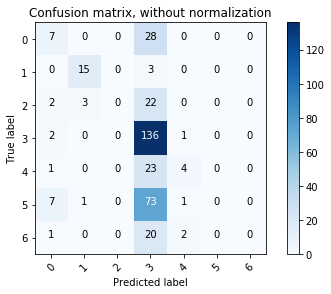

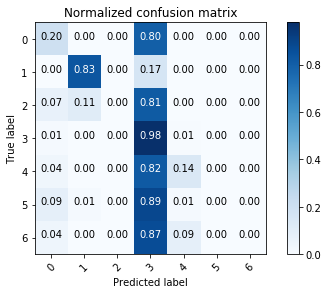

Wall time: 1h 31min 36s


In [27]:
%%time
## VGG19, 192

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG19',
                                                    categories_count=7,
                                                    dataset_name='03_France_ByMeaning_192_3dim',
                                                    image_size=192, X_train=X_train_192_FM, y_train=y_train_192_FM,
                                                    X_test=X_test_192_FM, y_test=y_test_192_FM,
                                                    batch_size_small_net=4, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
3123/3123 [==============================] - 39s 13ms/step - loss: 7.6053 - acc: 0.5030 - precision: 0.5030 - recall: 0.5030 - fmeasure: 0.5030
Epoch 2/200
3123/3123 [==============================] - 38s 12ms/step - loss: 6.1528 - acc: 0.6055 - precision: 0.6055 - recall: 0.6055 - fmeasure: 0.6055
Epoch 3/200
3123/3123 [==============================] - 38s 12ms/step - loss: 5.6595 - acc: 0.6346 - precision: 0.6349 - recall: 0.6346 - fmeasure: 0.6347
Epoch 4/200
3123/3123 [==============================] - 38s 12ms/step - loss: 5.7073 - acc: 0.6369 - precision: 0.6369 - recall: 0.6369 - fmeasure: 0.6369
Epoch 5/200
3123/3123 [==============================] - 37s 12ms/step - loss: 5.4370 - acc: 0.6558 - precision: 0.6558 - recall: 0.6558 - fmeasure: 0.6558
Epoch 6/200
3123/3123 [==============================] - 38s 12ms/step - loss: 5.3736 - acc: 0.6590 - precision: 0.6590 - recall: 0.6590 - fmeasure: 0.6590
Epoch 7/200
3123/3123 [==============================] - 37s 12m

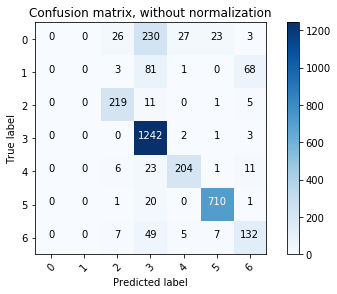

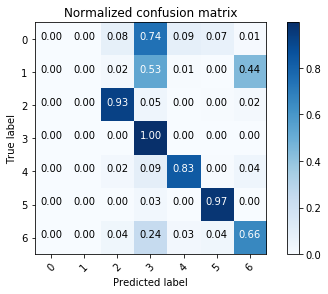

Confusion matrix, without normalization
[[  0   0   2  31   1   1   0]
 [  0   0   0  10   0   0   8]
 [  0   0  20   4   1   0   2]
 [  0   0   1 132   2   2   2]
 [  0   0   4  14   9   1   0]
 [  0   0   0  16   1  61   4]
 [  0   0   2   8   0   0  13]]
Normalized confusion matrix
[[0.         0.         0.05714286 0.88571429 0.02857143 0.02857143
  0.        ]
 [0.         0.         0.         0.55555556 0.         0.
  0.44444444]
 [0.         0.         0.74074074 0.14814815 0.03703704 0.
  0.07407407]
 [0.         0.         0.00719424 0.94964029 0.01438849 0.01438849
  0.01438849]
 [0.         0.         0.14285714 0.5        0.32142857 0.03571429
  0.        ]
 [0.         0.         0.         0.19512195 0.01219512 0.74390244
  0.04878049]
 [0.         0.         0.08695652 0.34782609 0.         0.
  0.56521739]]


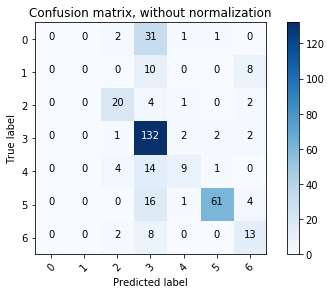

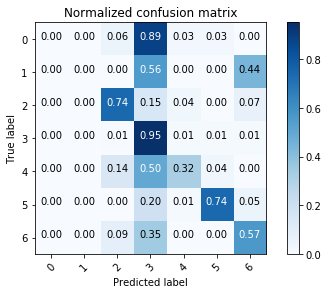

Wall time: 54min 41s


In [28]:
%%time
## VGG19, 224

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG19',
                                                    categories_count=7,
                                                    dataset_name='03_France_ByMeaning_224_3dim',
                                                    image_size=224, X_train=X_train_224_FM, y_train=y_train_224_FM,
                                                    X_test=X_test_224_FM, y_test=y_test_224_FM,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

In [29]:
%%time
# Now load another dataset

X_128_F_ByMeaningLarge, y_128_F_ByMeaningLarge = load_dir("D:/svruchtel/PREPROCESSED_DATA/03_France_ByMeaningLarge_128_3dim",
                                            ["AllTransport", "Restaurant"],
                                            already_transformed=True)   

X_160_F_ByMeaningLarge, y_160_F_ByMeaningLarge = load_dir("D:/svruchtel/PREPROCESSED_DATA/03_France_ByMeaningLarge_160_3dim",
                                            ["AllTransport", "Restaurant"],
                                            already_transformed=True)   

X_192_F_ByMeaningLarge, y_192_F_ByMeaningLarge = load_dir("D:/svruchtel/PREPROCESSED_DATA/03_France_ByMeaningLarge_192_3dim",
                                            ["AllTransport", "Restaurant"],
                                            already_transformed=True)   

X_224_F_ByMeaningLarge, y_224_F_ByMeaningLarge = load_dir("D:/svruchtel/PREPROCESSED_DATA/03_France_ByMeaningLarge_224_3dim",
                                            ["AllTransport", "Restaurant"],
                                            already_transformed=True)   


Wall time: 34.5 s


In [30]:
%%time

#Than divide all of them to train and test

X_train_128_FML, y_train_128_FML, X_test_128_FML, y_test_128_FML = divide_to_train_end_test(X_128_F_ByMeaningLarge,
                                                                                        y_128_F_ByMeaningLarge, num_categories=2)
X_train_160_FML, y_train_160_FML, X_test_160_FML, y_test_160_FML = divide_to_train_end_test(X_160_F_ByMeaningLarge,
                                                                                        y_160_F_ByMeaningLarge, num_categories=2)
X_train_192_FML, y_train_192_FML, X_test_192_FML, y_test_192_FML = divide_to_train_end_test(X_192_F_ByMeaningLarge,
                                                                                        y_192_F_ByMeaningLarge, num_categories=2)
X_train_224_FML, y_train_224_FML, X_test_224_FML, y_test_224_FML = divide_to_train_end_test(X_224_F_ByMeaningLarge,
                                                                                        y_224_F_ByMeaningLarge, num_categories=2)


Wall time: 4.61 s


Epoch 1/200
2977/2977 [==============================] - 21s 7ms/step - loss: 1.8341 - acc: 0.7229 - precision: 0.7229 - recall: 0.7229 - fmeasure: 0.7229
Epoch 2/200
2977/2977 [==============================] - 18s 6ms/step - loss: 1.7087 - acc: 0.7921 - precision: 0.7921 - recall: 0.7921 - fmeasure: 0.7921
Epoch 3/200
2977/2977 [==============================] - 18s 6ms/step - loss: 1.7143 - acc: 0.8099 - precision: 0.8099 - recall: 0.8099 - fmeasure: 0.8099
Epoch 4/200
2977/2977 [==============================] - 17s 6ms/step - loss: 1.6488 - acc: 0.8300 - precision: 0.8300 - recall: 0.8300 - fmeasure: 0.8300
Epoch 5/200
2977/2977 [==============================] - 17s 6ms/step - loss: 1.4801 - acc: 0.8509 - precision: 0.8509 - recall: 0.8509 - fmeasure: 0.8509
Epoch 6/200
2977/2977 [==============================] - 18s 6ms/step - loss: 1.6482 - acc: 0.8361 - precision: 0.8361 - recall: 0.8361 - fmeasure: 0.8361
Epoch 7/200
2977/2977 [==============================] - 18s 6ms/step 

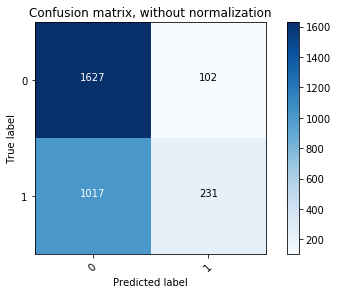

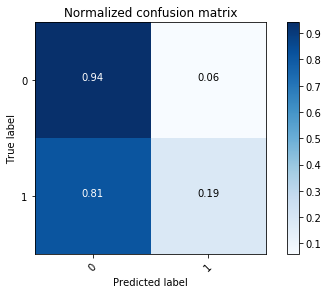

Confusion matrix, without normalization
[[173  20]
 [115  24]]
Normalized confusion matrix
[[0.89637306 0.10362694]
 [0.82733813 0.17266187]]


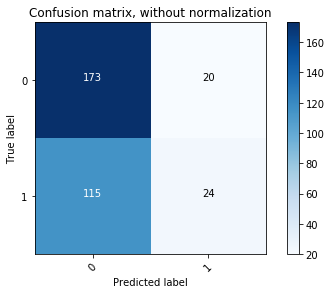

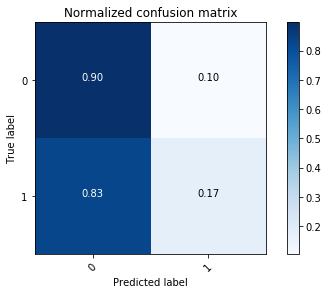

Wall time: 6min 53s


In [31]:
%%time
## MobileNet, 128

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='MobileNet',
                                                    categories_count=2,
                                                    dataset_name='03_France_ByMeaningLarge_128_3dim',
                                                    image_size=128, X_train=X_train_128_FML, y_train=y_train_128_FML,
                                                    X_test=X_test_128_FML, y_test=y_test_128_FML,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
2977/2977 [==============================] - 22s 8ms/step - loss: 2.0157 - acc: 0.7410 - precision: 0.7410 - recall: 0.7410 - fmeasure: 0.7410
Epoch 2/200
2977/2977 [==============================] - 19s 6ms/step - loss: 1.7835 - acc: 0.8186 - precision: 0.8186 - recall: 0.8186 - fmeasure: 0.8186
Epoch 3/200
2977/2977 [==============================] - 19s 6ms/step - loss: 1.5301 - acc: 0.8559 - precision: 0.8559 - recall: 0.8559 - fmeasure: 0.8559
Epoch 4/200
2977/2977 [==============================] - 19s 6ms/step - loss: 1.5988 - acc: 0.8515 - precision: 0.8515 - recall: 0.8515 - fmeasure: 0.8515
Epoch 5/200
2977/2977 [==============================] - 19s 6ms/step - loss: 1.5856 - acc: 0.8616 - precision: 0.8616 - recall: 0.8616 - fmeasure: 0.8616
Epoch 6/200
2977/2977 [==============================] - 19s 6ms/step - loss: 1.5879 - acc: 0.8677 - precision: 0.8677 - recall: 0.8677 - fmeasure: 0.8677
Epoch 7/200
2977/2977 [==============================] - 41s 14ms/step

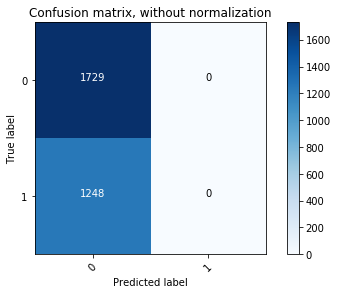

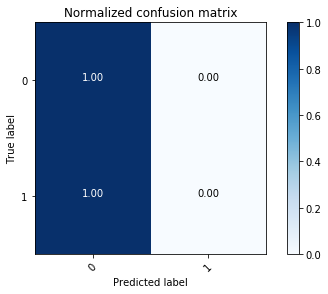

Confusion matrix, without normalization
[[193   0]
 [139   0]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


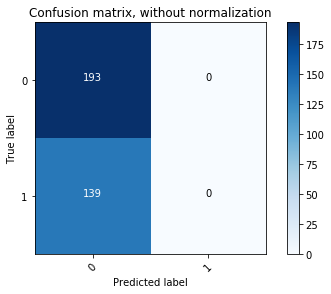

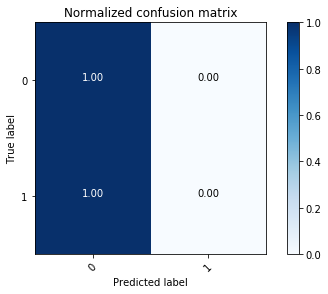

Wall time: 17min 7s


In [32]:
%%time
## MobileNet, 160

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='MobileNet',
                                                    categories_count=2,
                                                    dataset_name='03_France_ByMeaningLarge_160_3dim',
                                                    image_size=160, X_train=X_train_160_FML, y_train=y_train_160_FML,
                                                    X_test=X_test_160_FML, y_test=y_test_160_FML,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
2977/2977 [==============================] - 25s 8ms/step - loss: 2.1869 - acc: 0.7548 - precision: 0.7548 - recall: 0.7548 - fmeasure: 0.7548
Epoch 2/200
2977/2977 [==============================] - 20s 7ms/step - loss: 1.7007 - acc: 0.8505 - precision: 0.8505 - recall: 0.8505 - fmeasure: 0.8505
Epoch 3/200
2977/2977 [==============================] - 21s 7ms/step - loss: 1.5255 - acc: 0.8660 - precision: 0.8660 - recall: 0.8660 - fmeasure: 0.8660
Epoch 4/200
2977/2977 [==============================] - 21s 7ms/step - loss: 1.6178 - acc: 0.8666 - precision: 0.8666 - recall: 0.8666 - fmeasure: 0.8666
Epoch 5/200
2977/2977 [==============================] - 21s 7ms/step - loss: 1.4852 - acc: 0.8811 - precision: 0.8811 - recall: 0.8811 - fmeasure: 0.8811
Epoch 6/200
2977/2977 [==============================] - 21s 7ms/step - loss: 1.4041 - acc: 0.8888 - precision: 0.8888 - recall: 0.8888 - fmeasure: 0.8888
Epoch 7/200
2977/2977 [==============================] - 21s 7ms/step 

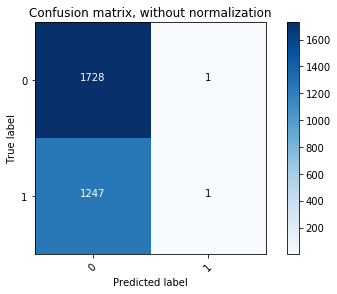

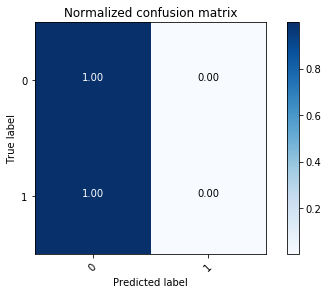

Confusion matrix, without normalization
[[193   0]
 [139   0]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


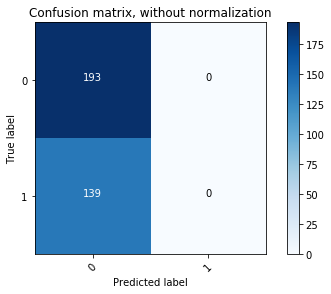

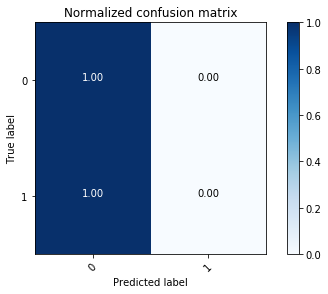

Wall time: 20min 44s


In [33]:
%%time
## MobileNet, 192

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='MobileNet',
                                                    categories_count=2,
                                                    dataset_name='03_France_ByMeaningLarge_192_3dim',
                                                    image_size=192, X_train=X_train_192_FML, y_train=y_train_192_FML,
                                                    X_test=X_test_192_FML, y_test=y_test_192_FML,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
2977/2977 [==============================] - 25s 8ms/step - loss: 2.4167 - acc: 0.7605 - precision: 0.7605 - recall: 0.7605 - fmeasure: 0.7605
Epoch 2/200
2977/2977 [==============================] - 22s 7ms/step - loss: 1.8968 - acc: 0.8512 - precision: 0.8512 - recall: 0.8512 - fmeasure: 0.8512
Epoch 3/200
2977/2977 [==============================] - 22s 7ms/step - loss: 1.6623 - acc: 0.8643 - precision: 0.8643 - recall: 0.8643 - fmeasure: 0.8643
Epoch 4/200
2977/2977 [==============================] - 22s 7ms/step - loss: 1.9123 - acc: 0.8552 - precision: 0.8552 - recall: 0.8552 - fmeasure: 0.8552
Epoch 5/200
2977/2977 [==============================] - 22s 7ms/step - loss: 1.7239 - acc: 0.8660 - precision: 0.8660 - recall: 0.8660 - fmeasure: 0.8660
Epoch 6/200
2977/2977 [==============================] - 45s 15ms/step - loss: 1.4788 - acc: 0.8892 - precision: 0.8892 - recall: 0.8892 - fmeasure: 0.8892
Epoch 7/200
2977/2977 [==============================] - 23s 8ms/step

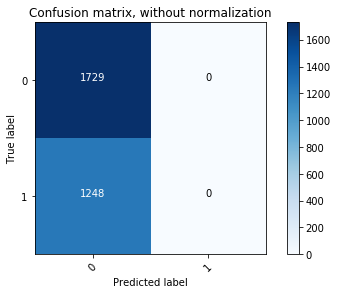

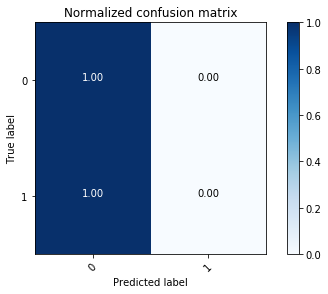

Confusion matrix, without normalization
[[193   0]
 [139   0]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


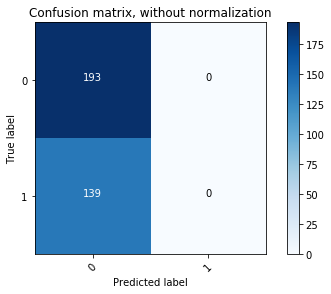

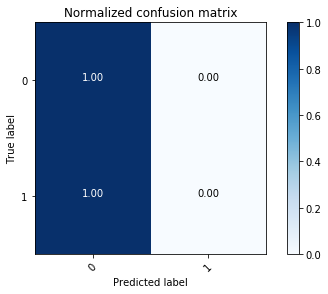

Wall time: 36min 5s


In [34]:
%%time
## MobileNet, 224

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='MobileNet',
                                                    categories_count=2,
                                                    dataset_name='03_France_ByMeaningLarge_224_3dim',
                                                    image_size=224, X_train=X_train_224_FML, y_train=y_train_224_FML,
                                                    X_test=X_test_224_FML, y_test=y_test_224_FML,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
2977/2977 [==============================] - 16s 5ms/step - loss: 5.4819 - acc: 0.6315 - precision: 0.6315 - recall: 0.6315 - fmeasure: 0.6315
Epoch 2/200
2977/2977 [==============================] - 13s 4ms/step - loss: 4.7147 - acc: 0.6883 - precision: 0.6883 - recall: 0.6883 - fmeasure: 0.6883
Epoch 3/200
2977/2977 [==============================] - 13s 4ms/step - loss: 4.1710 - acc: 0.7259 - precision: 0.7259 - recall: 0.7259 - fmeasure: 0.7259
Epoch 4/200
2977/2977 [==============================] - 13s 4ms/step - loss: 3.6625 - acc: 0.7632 - precision: 0.7632 - recall: 0.7632 - fmeasure: 0.7632
Epoch 5/200
2977/2977 [==============================] - 13s 4ms/step - loss: 3.4060 - acc: 0.7759 - precision: 0.7759 - recall: 0.7759 - fmeasure: 0.7759
Epoch 6/200
2977/2977 [==============================] - 13s 5ms/step - loss: 3.8245 - acc: 0.7538 - precision: 0.7538 - recall: 0.7538 - fmeasure: 0.7538
Epoch 7/200
2977/2977 [==============================] - 13s 4ms/step 

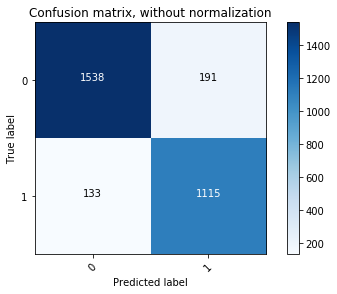

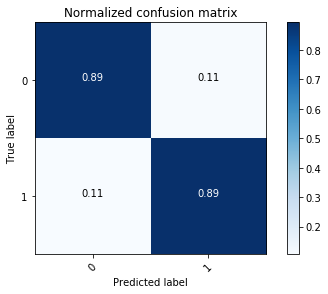

Confusion matrix, without normalization
[[150  43]
 [ 26 113]]
Normalized confusion matrix
[[0.77720207 0.22279793]
 [0.18705036 0.81294964]]


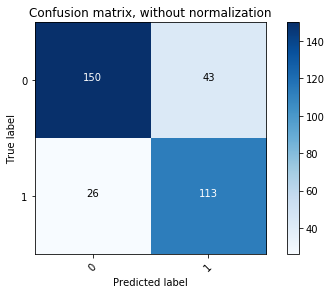

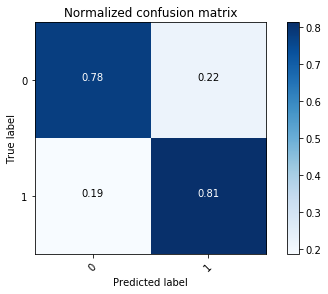

Wall time: 23min 1s


In [35]:
%%time
## SqueezeNet, 128

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='SqueezeNet',
                                                    categories_count=2,
                                                    dataset_name='03_France_ByMeaningLarge_128_3dim',
                                                    image_size=128, X_train=X_train_128_FML, y_train=y_train_128_FML,
                                                    X_test=X_test_128_FML, y_test=y_test_128_FML,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
2977/2977 [==============================] - 19s 6ms/step - loss: 5.4501 - acc: 0.6376 - precision: 0.6376 - recall: 0.6376 - fmeasure: 0.6376
Epoch 2/200
2977/2977 [==============================] - 14s 5ms/step - loss: 4.1769 - acc: 0.7293 - precision: 0.7293 - recall: 0.7293 - fmeasure: 0.7293
Epoch 3/200
2977/2977 [==============================] - 14s 5ms/step - loss: 3.8828 - acc: 0.7511 - precision: 0.7511 - recall: 0.7511 - fmeasure: 0.7511
Epoch 4/200
2977/2977 [==============================] - 14s 5ms/step - loss: 3.7173 - acc: 0.7595 - precision: 0.7595 - recall: 0.7595 - fmeasure: 0.7595
Epoch 5/200
2977/2977 [==============================] - 14s 5ms/step - loss: 3.4311 - acc: 0.7800 - precision: 0.7800 - recall: 0.7800 - fmeasure: 0.7800
Epoch 6/200
2977/2977 [==============================] - 15s 5ms/step - loss: 3.6096 - acc: 0.7692 - precision: 0.7692 - recall: 0.7692 - fmeasure: 0.7692
Epoch 7/200
2977/2977 [==============================] - 14s 5ms/step 

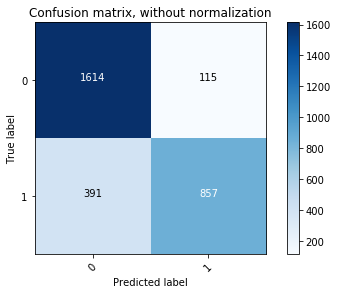

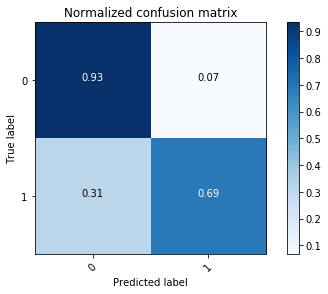

Confusion matrix, without normalization
[[178  15]
 [ 50  89]]
Normalized confusion matrix
[[0.92227979 0.07772021]
 [0.35971223 0.64028777]]


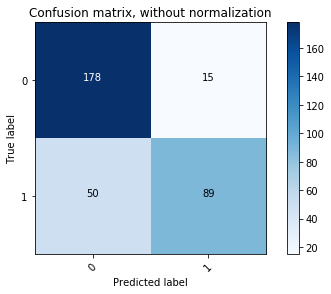

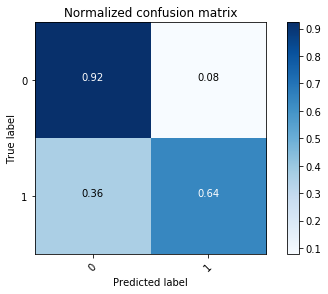

Wall time: 8min 38s


In [37]:
%%time
## SqueezeNet, 160

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='SqueezeNet',
                                                    categories_count=2,
                                                    dataset_name='03_France_ByMeaningLarge_160_3dim',
                                                    image_size=160, X_train=X_train_160_FML, y_train=y_train_160_FML,
                                                    X_test=X_test_160_FML, y_test=y_test_160_FML,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
2977/2977 [==============================] - 20s 7ms/step - loss: 6.7671 - acc: 0.5791 - precision: 0.5791 - recall: 0.5791 - fmeasure: 0.5791
Epoch 2/200
2977/2977 [==============================] - 16s 5ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 3/200
2977/2977 [==============================] - 16s 6ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 4/200
2977/2977 [==============================] - 16s 6ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 5/200
2977/2977 [==============================] - 16s 6ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 6/200
2977/2977 [==============================] - 39s 13ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 7/200
2977/2977 [==============================] - 17s 6ms/step

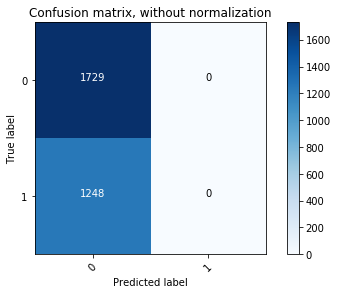

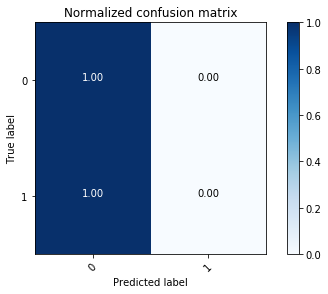

Confusion matrix, without normalization
[[193   0]
 [139   0]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


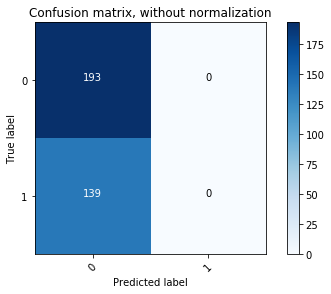

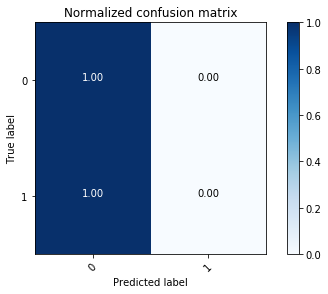

Wall time: 5min 12s


In [42]:
%%time
## SqueezeNet, 192

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='SqueezeNet',
                                                    categories_count=2,
                                                    dataset_name='03_France_ByMeaningLarge_192_3dim',
                                                    image_size=192, X_train=X_train_192_FML, y_train=y_train_192_FML,
                                                    X_test=X_test_192_FML, y_test=y_test_192_FML,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
2977/2977 [==============================] - 23s 8ms/step - loss: 9.3653 - acc: 0.4185 - precision: 0.4185 - recall: 0.4185 - fmeasure: 0.4185
Epoch 2/200
2977/2977 [==============================] - 18s 6ms/step - loss: 9.3558 - acc: 0.4195 - precision: 0.4195 - recall: 0.4195 - fmeasure: 0.4195
Epoch 3/200
2977/2977 [==============================] - 18s 6ms/step - loss: 9.3505 - acc: 0.4199 - precision: 0.4199 - recall: 0.4199 - fmeasure: 0.4199
Epoch 4/200
2977/2977 [==============================] - 18s 6ms/step - loss: 9.3503 - acc: 0.4199 - precision: 0.4199 - recall: 0.4199 - fmeasure: 0.4199
Epoch 5/200
2977/2977 [==============================] - 18s 6ms/step - loss: 9.3503 - acc: 0.4199 - precision: 0.4199 - recall: 0.4199 - fmeasure: 0.4199
Epoch 6/200
2977/2977 [==============================] - 31s 10ms/step - loss: 9.3503 - acc: 0.4199 - precision: 0.4199 - recall: 0.4199 - fmeasure: 0.4199
Epoch 7/200
2977/2977 [==============================] - 28s 9ms/step

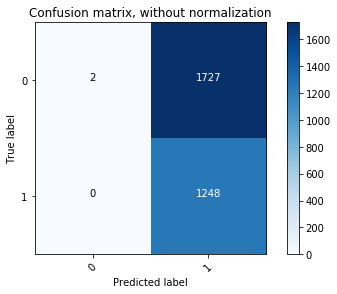

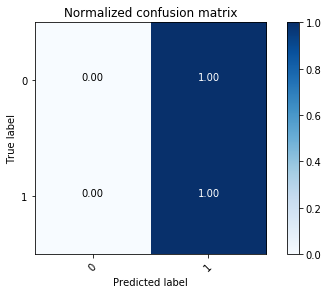

Confusion matrix, without normalization
[[  0 193]
 [  0 139]]
Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


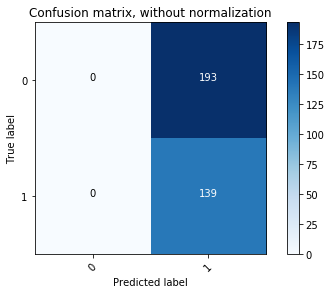

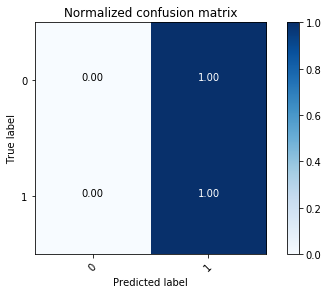

Wall time: 7min 12s


In [43]:
%%time
## SqueezeNet, 224

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='SqueezeNet',
                                                    categories_count=2,
                                                    dataset_name='03_France_ByMeaningLarge_224_3dim',
                                                    image_size=224, X_train=X_train_224_FML, y_train=y_train_224_FML,
                                                    X_test=X_test_224_FML, y_test=y_test_224_FML,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
2977/2977 [==============================] - 35s 12ms/step - loss: 1.0383 - acc: 0.6241 - precision: 0.6241 - recall: 0.6241 - fmeasure: 0.6241
Epoch 2/200
2977/2977 [==============================] - 28s 9ms/step - loss: 1.0547 - acc: 0.6839 - precision: 0.6839 - recall: 0.6839 - fmeasure: 0.6839
Epoch 3/200
2977/2977 [==============================] - 28s 9ms/step - loss: 0.9871 - acc: 0.7051 - precision: 0.7051 - recall: 0.7051 - fmeasure: 0.7051
Epoch 4/200
2977/2977 [==============================] - 28s 9ms/step - loss: 1.0258 - acc: 0.7165 - precision: 0.7165 - recall: 0.7165 - fmeasure: 0.7165
Epoch 5/200
2977/2977 [==============================] - 29s 10ms/step - loss: 0.9980 - acc: 0.7276 - precision: 0.7276 - recall: 0.7276 - fmeasure: 0.7276
Epoch 6/200
2977/2977 [==============================] - 44s 15ms/step - loss: 1.1822 - acc: 0.7074 - precision: 0.7074 - recall: 0.7074 - fmeasure: 0.7074
Epoch 7/200
2977/2977 [==============================] - 29s 10ms/s

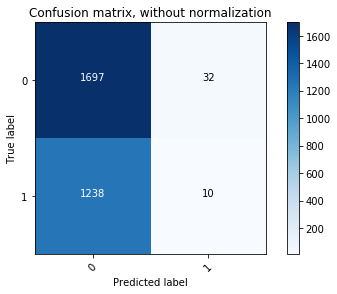

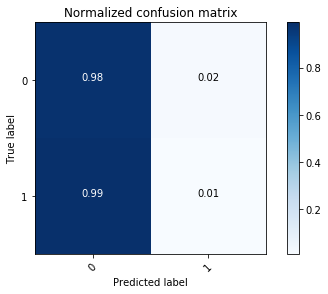

Confusion matrix, without normalization
[[191   2]
 [139   0]]
Normalized confusion matrix
[[0.98963731 0.01036269]
 [1.         0.        ]]


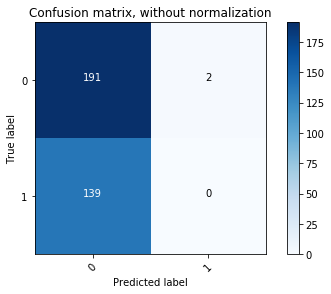

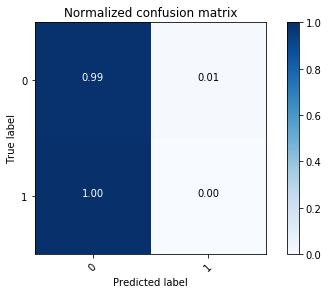

Wall time: 7min 14s


In [44]:
%%time
## Xception, 128

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='Xception',
                                                    categories_count=2,
                                                    dataset_name='03_France_ByMeaningLarge_128_3dim',
                                                    image_size=128, X_train=X_train_128_FML, y_train=y_train_128_FML,
                                                    X_test=X_test_128_FML, y_test=y_test_128_FML,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
2977/2977 [==============================] - 36s 12ms/step - loss: 1.0918 - acc: 0.6873 - precision: 0.6873 - recall: 0.6873 - fmeasure: 0.6873
Epoch 2/200
2977/2977 [==============================] - 30s 10ms/step - loss: 0.9826 - acc: 0.7471 - precision: 0.7471 - recall: 0.7471 - fmeasure: 0.7471
Epoch 3/200
2977/2977 [==============================] - 30s 10ms/step - loss: 1.1569 - acc: 0.7531 - precision: 0.7531 - recall: 0.7531 - fmeasure: 0.7531
Epoch 4/200
2977/2977 [==============================] - 30s 10ms/step - loss: 1.0702 - acc: 0.7706 - precision: 0.7706 - recall: 0.7706 - fmeasure: 0.7706
Epoch 5/200
2977/2977 [==============================] - 30s 10ms/step - loss: 1.0380 - acc: 0.7870 - precision: 0.7870 - recall: 0.7870 - fmeasure: 0.7870
Epoch 6/200
2977/2977 [==============================] - 31s 10ms/step - loss: 1.0133 - acc: 0.7941 - precision: 0.7941 - recall: 0.7941 - fmeasure: 0.7941
Epoch 7/200
2977/2977 [==============================] - 30s 10m

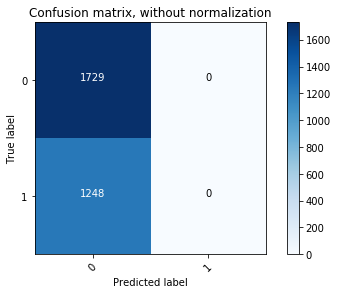

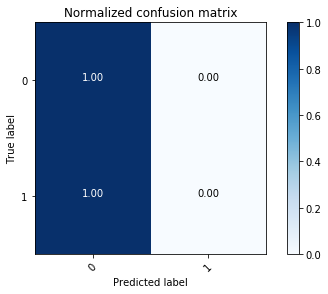

Confusion matrix, without normalization
[[193   0]
 [139   0]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


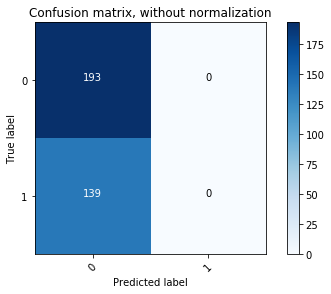

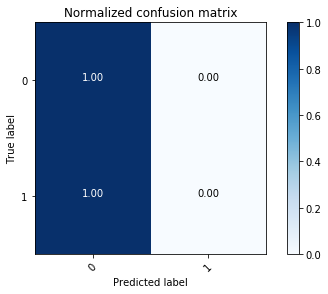

Wall time: 6min 54s


In [45]:
%%time
## Xception, 160

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='Xception',
                                                    categories_count=2,
                                                    dataset_name='03_France_ByMeaningLarge_160_3dim',
                                                    image_size=160, X_train=X_train_160_FML, y_train=y_train_160_FML,
                                                    X_test=X_test_160_FML, y_test=y_test_160_FML,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
2977/2977 [==============================] - 36s 12ms/step - loss: 1.2225 - acc: 0.6957 - precision: 0.6957 - recall: 0.6957 - fmeasure: 0.6957
Epoch 2/200
2977/2977 [==============================] - 28s 9ms/step - loss: 1.2517 - acc: 0.7659 - precision: 0.7659 - recall: 0.7659 - fmeasure: 0.7659
Epoch 3/200
2977/2977 [==============================] - 28s 9ms/step - loss: 1.1418 - acc: 0.7887 - precision: 0.7887 - recall: 0.7887 - fmeasure: 0.7887
Epoch 4/200
2977/2977 [==============================] - 28s 9ms/step - loss: 1.0241 - acc: 0.8247 - precision: 0.8247 - recall: 0.8247 - fmeasure: 0.8247
Epoch 5/200
2977/2977 [==============================] - 28s 9ms/step - loss: 1.0841 - acc: 0.8226 - precision: 0.8226 - recall: 0.8226 - fmeasure: 0.8226
Epoch 6/200
2977/2977 [==============================] - 64s 22ms/step - loss: 1.3528 - acc: 0.8062 - precision: 0.8062 - recall: 0.8062 - fmeasure: 0.8062
Epoch 7/200
2977/2977 [==============================] - 29s 10ms/st

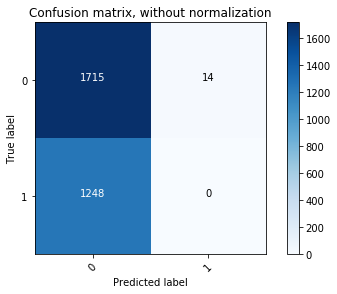

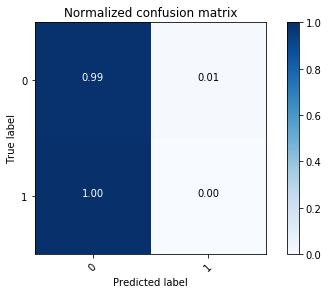

Confusion matrix, without normalization
[[193   0]
 [139   0]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


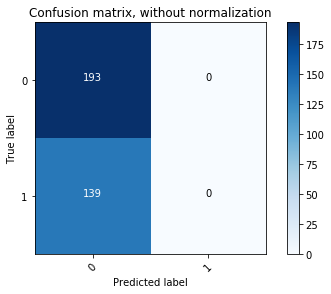

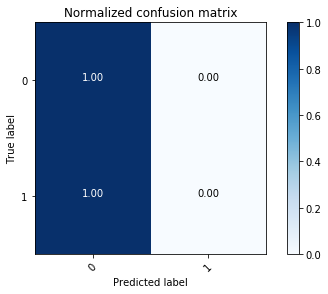

Wall time: 40min 17s


In [46]:
%%time
## Xception, 192

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='Xception',
                                                    categories_count=2,
                                                    dataset_name='03_France_ByMeaningLarge_192_3dim',
                                                    image_size=192, X_train=X_train_192_FML, y_train=y_train_192_FML,
                                                    X_test=X_test_192_FML, y_test=y_test_192_FML,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
2977/2977 [==============================] - 46s 15ms/step - loss: 1.6243 - acc: 0.7068 - precision: 0.7068 - recall: 0.7068 - fmeasure: 0.7068
Epoch 2/200
2977/2977 [==============================] - 36s 12ms/step - loss: 1.5735 - acc: 0.7827 - precision: 0.7827 - recall: 0.7827 - fmeasure: 0.7827
Epoch 3/200
2977/2977 [==============================] - 34s 11ms/step - loss: 1.2962 - acc: 0.8173 - precision: 0.8173 - recall: 0.8173 - fmeasure: 0.8173
Epoch 4/200
2977/2977 [==============================] - 35s 12ms/step - loss: 1.2696 - acc: 0.8351 - precision: 0.8351 - recall: 0.8351 - fmeasure: 0.8351
Epoch 5/200
2977/2977 [==============================] - 34s 11ms/step - loss: 1.0167 - acc: 0.8653 - precision: 0.8653 - recall: 0.8653 - fmeasure: 0.8653
Epoch 6/200
2977/2977 [==============================] - 35s 12ms/step - loss: 1.4164 - acc: 0.8367 - precision: 0.8367 - recall: 0.8367 - fmeasure: 0.8367
Epoch 7/200
2977/2977 [==============================] - 34s 11m

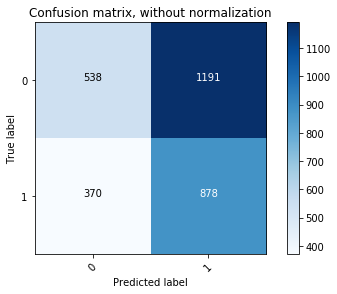

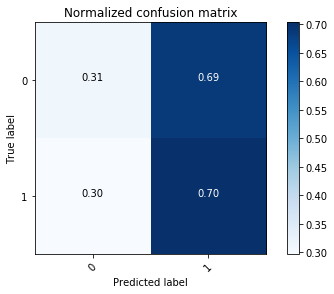

Confusion matrix, without normalization
[[ 63 130]
 [ 42  97]]
Normalized confusion matrix
[[0.32642487 0.67357513]
 [0.30215827 0.69784173]]


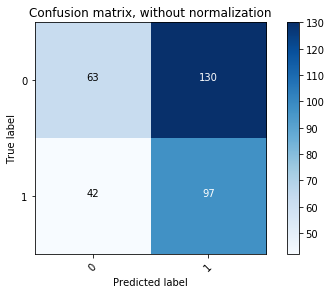

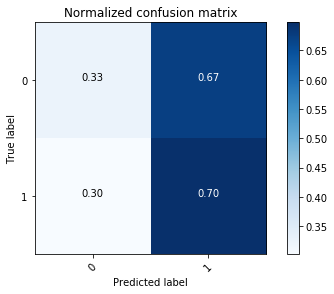

Wall time: 11h 21min 22s


In [47]:
%%time
## Xception, 224

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='Xception',
                                                    categories_count=2,
                                                    dataset_name='03_France_ByMeaningLarge_224_3dim',
                                                    image_size=224, X_train=X_train_224_FML, y_train=y_train_224_FML,
                                                    X_test=X_test_224_FML, y_test=y_test_224_FML,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
2977/2977 [==============================] - 1586s 533ms/step - loss: 4.2885 - acc: 0.6621 - precision: 0.6621 - recall: 0.6621 - fmeasure: 0.6621
Epoch 2/200
2977/2977 [==============================] - 1558s 523ms/step - loss: 3.2901 - acc: 0.7528 - precision: 0.7528 - recall: 0.7528 - fmeasure: 0.7528
Epoch 3/200
2977/2977 [==============================] - 1557s 523ms/step - loss: 3.2291 - acc: 0.7625 - precision: 0.7625 - recall: 0.7625 - fmeasure: 0.7625
Epoch 4/200
2977/2977 [==============================] - 1817s 610ms/step - loss: 3.1685 - acc: 0.7686 - precision: 0.7686 - recall: 0.7686 - fmeasure: 0.7686
Epoch 5/200
2977/2977 [==============================] - 905s 304ms/step - loss: 3.2792 - acc: 0.7669 - precision: 0.7669 - recall: 0.7669 - fmeasure: 0.7669
Epoch 6/200
2977/2977 [==============================] - 1691s 568ms/step - loss: 2.5914 - acc: 0.8112 - precision: 0.8112 - recall: 0.8112 - fmeasure: 0.8112
Epoch 7/200
2977/2977 [========================

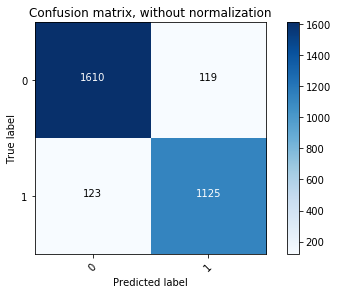

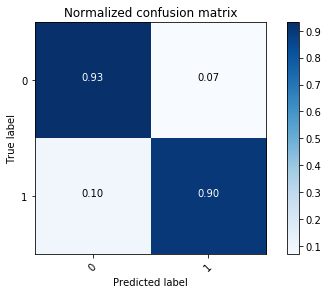

Confusion matrix, without normalization
[[143  50]
 [ 23 116]]
Normalized confusion matrix
[[0.74093264 0.25906736]
 [0.16546763 0.83453237]]


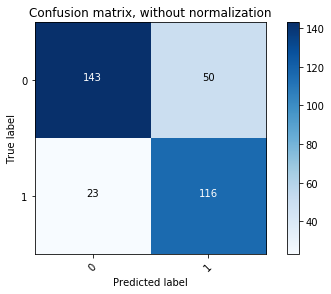

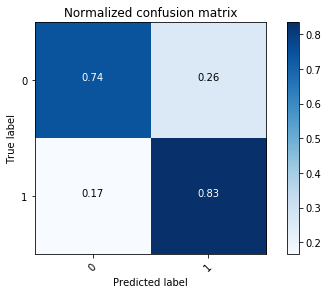

Wall time: 10h 30min 11s


In [48]:
%%time
## VGG16, 128

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG16',
                                                    categories_count=2,
                                                    dataset_name='03_France_ByMeaningLarge_128_3dim',
                                                    image_size=128, X_train=X_train_128_FML, y_train=y_train_128_FML,
                                                    X_test=X_test_128_FML, y_test=y_test_128_FML,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
2977/2977 [==============================] - 34s 11ms/step - loss: 4.0080 - acc: 0.6906 - precision: 0.6906 - recall: 0.6906 - fmeasure: 0.6906
Epoch 2/200
2977/2977 [==============================] - 22s 7ms/step - loss: 3.3485 - acc: 0.7581 - precision: 0.7581 - recall: 0.7581 - fmeasure: 0.7581
Epoch 3/200
2977/2977 [==============================] - 22s 7ms/step - loss: 2.8287 - acc: 0.7958 - precision: 0.7958 - recall: 0.7958 - fmeasure: 0.7958
Epoch 4/200
2977/2977 [==============================] - 22s 7ms/step - loss: 2.5716 - acc: 0.8173 - precision: 0.8173 - recall: 0.8173 - fmeasure: 0.8173
Epoch 5/200
2977/2977 [==============================] - 22s 7ms/step - loss: 2.5134 - acc: 0.8243 - precision: 0.8243 - recall: 0.8243 - fmeasure: 0.8243
Epoch 6/200
2977/2977 [==============================] - 23s 8ms/step - loss: 2.5978 - acc: 0.8213 - precision: 0.8213 - recall: 0.8213 - fmeasure: 0.8213
Epoch 7/200
2977/2977 [==============================] - 22s 7ms/step

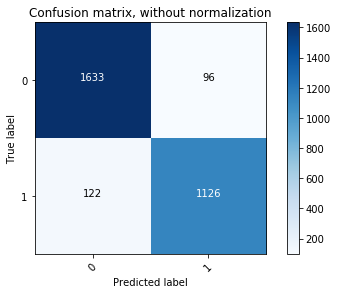

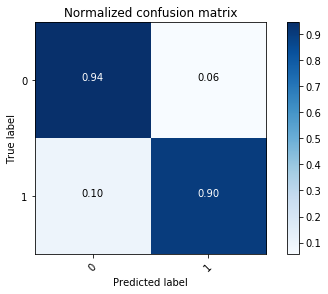

Confusion matrix, without normalization
[[154  39]
 [ 29 110]]
Normalized confusion matrix
[[0.79792746 0.20207254]
 [0.20863309 0.79136691]]


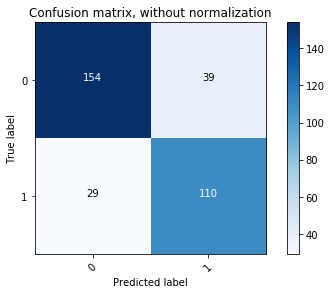

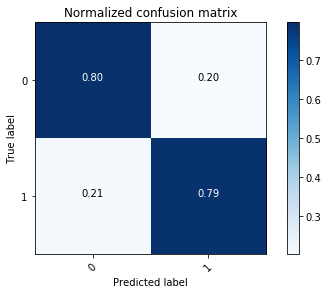

Wall time: 16min 25s


In [49]:
%%time
## VGG16, 160

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG16',
                                                    categories_count=2,
                                                    dataset_name='03_France_ByMeaningLarge_160_3dim',
                                                    image_size=160, X_train=X_train_160_FML, y_train=y_train_160_FML,
                                                    X_test=X_test_160_FML, y_test=y_test_160_FML,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
2977/2977 [==============================] - 32s 11ms/step - loss: 3.6223 - acc: 0.7225 - precision: 0.7225 - recall: 0.7225 - fmeasure: 0.7225
Epoch 2/200
2977/2977 [==============================] - 25s 8ms/step - loss: 2.6016 - acc: 0.8089 - precision: 0.8089 - recall: 0.8089 - fmeasure: 0.8089
Epoch 3/200
2977/2977 [==============================] - 25s 8ms/step - loss: 2.4972 - acc: 0.8243 - precision: 0.8243 - recall: 0.8243 - fmeasure: 0.8243
Epoch 4/200
2977/2977 [==============================] - 25s 9ms/step - loss: 2.3952 - acc: 0.8351 - precision: 0.8351 - recall: 0.8351 - fmeasure: 0.8351
Epoch 5/200
2977/2977 [==============================] - 25s 8ms/step - loss: 2.2373 - acc: 0.8465 - precision: 0.8465 - recall: 0.8465 - fmeasure: 0.8465
Epoch 6/200
2977/2977 [==============================] - 66s 22ms/step - loss: 2.0153 - acc: 0.8582 - precision: 0.8582 - recall: 0.8582 - fmeasure: 0.8582
Epoch 7/200
2977/2977 [==============================] - 27s 9ms/ste

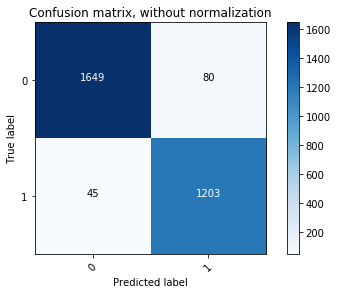

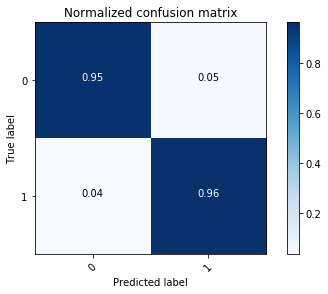

Confusion matrix, without normalization
[[158  35]
 [ 24 115]]
Normalized confusion matrix
[[0.81865285 0.18134715]
 [0.17266187 0.82733813]]


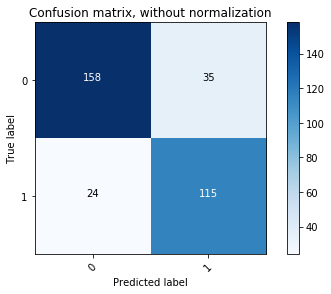

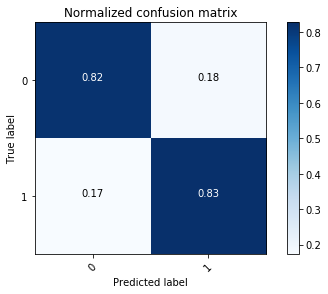

Wall time: 37min 9s


In [50]:
%%time
## VGG16, 192

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG16',
                                                    categories_count=2,
                                                    dataset_name='03_France_ByMeaningLarge_192_3dim',
                                                    image_size=192, X_train=X_train_192_FML, y_train=y_train_192_FML,
                                                    X_test=X_test_192_FML, y_test=y_test_192_FML,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
2977/2977 [==============================] - 42s 14ms/step - loss: 3.1987 - acc: 0.7561 - precision: 0.7561 - recall: 0.7561 - fmeasure: 0.7561
Epoch 2/200
2977/2977 [==============================] - 31s 11ms/step - loss: 2.2851 - acc: 0.8384 - precision: 0.8384 - recall: 0.8384 - fmeasure: 0.8384
Epoch 3/200
2977/2977 [==============================] - 31s 11ms/step - loss: 2.2927 - acc: 0.8408 - precision: 0.8408 - recall: 0.8408 - fmeasure: 0.8408
Epoch 4/200
2977/2977 [==============================] - 31s 11ms/step - loss: 2.2497 - acc: 0.8458 - precision: 0.8458 - recall: 0.8458 - fmeasure: 0.8458
Epoch 5/200
2977/2977 [==============================] - 31s 11ms/step - loss: 2.1211 - acc: 0.8576 - precision: 0.8576 - recall: 0.8576 - fmeasure: 0.8576
Epoch 6/200
2977/2977 [==============================] - 33s 11ms/step - loss: 2.0517 - acc: 0.8596 - precision: 0.8596 - recall: 0.8596 - fmeasure: 0.8596
Epoch 7/200
2977/2977 [==============================] - 31s 11m

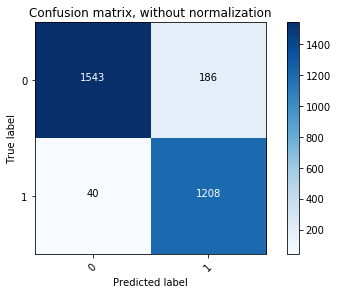

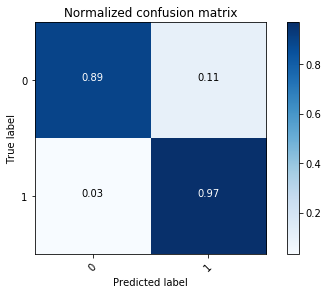

Confusion matrix, without normalization
[[152  41]
 [ 14 125]]
Normalized confusion matrix
[[0.78756477 0.21243523]
 [0.10071942 0.89928058]]


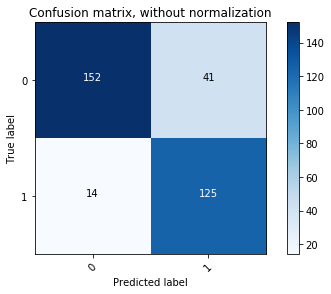

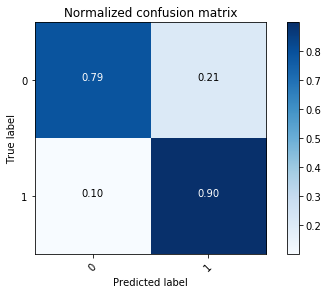

Wall time: 19min 24s


In [51]:
%%time
## VGG16, 224

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG16',
                                                    categories_count=2,
                                                    dataset_name='03_France_ByMeaningLarge_224_3dim',
                                                    image_size=224, X_train=X_train_224_FML, y_train=y_train_224_FML,
                                                    X_test=X_test_224_FML, y_test=y_test_224_FML,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
2977/2977 [==============================] - 26s 9ms/step - loss: 4.7572 - acc: 0.6436 - precision: 0.6436 - recall: 0.6436 - fmeasure: 0.6436
Epoch 2/200
2977/2977 [==============================] - 18s 6ms/step - loss: 3.8679 - acc: 0.7232 - precision: 0.7232 - recall: 0.7232 - fmeasure: 0.7232
Epoch 3/200
2977/2977 [==============================] - 18s 6ms/step - loss: 3.3995 - acc: 0.7565 - precision: 0.7565 - recall: 0.7565 - fmeasure: 0.7565
Epoch 4/200
2977/2977 [==============================] - 19s 6ms/step - loss: 3.2080 - acc: 0.7709 - precision: 0.7709 - recall: 0.7709 - fmeasure: 0.7709
Epoch 5/200
2977/2977 [==============================] - 18s 6ms/step - loss: 3.1043 - acc: 0.7776 - precision: 0.7776 - recall: 0.7776 - fmeasure: 0.7776
Epoch 6/200
2977/2977 [==============================] - 19s 6ms/step - loss: 3.1396 - acc: 0.7763 - precision: 0.7763 - recall: 0.7763 - fmeasure: 0.7763
Epoch 7/200
2977/2977 [==============================] - 19s 6ms/step 

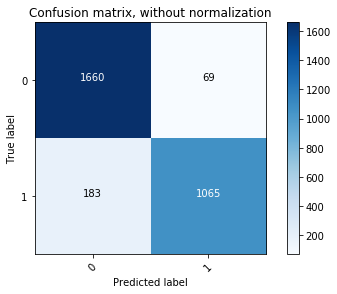

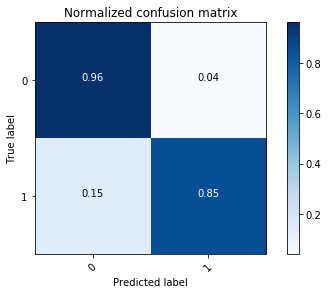

Confusion matrix, without normalization
[[159  34]
 [ 31 108]]
Normalized confusion matrix
[[0.8238342  0.1761658 ]
 [0.22302158 0.77697842]]


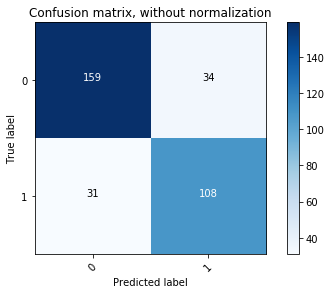

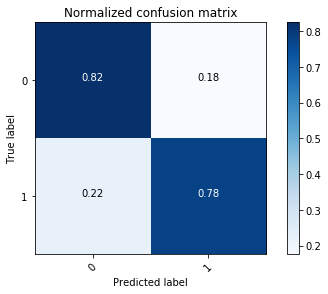

Wall time: 21min 15s


In [52]:
%%time
## VGG19, 128

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG19',
                                                    categories_count=2,
                                                    dataset_name='03_France_ByMeaningLarge_128_3dim',
                                                    image_size=128, X_train=X_train_128_FML, y_train=y_train_128_FML,
                                                    X_test=X_test_128_FML, y_test=y_test_128_FML,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
2977/2977 [==============================] - 63s 21ms/step - loss: 4.0709 - acc: 0.6910 - precision: 0.6910 - recall: 0.6910 - fmeasure: 0.6910
Epoch 2/200
2977/2977 [==============================] - 27s 9ms/step - loss: 3.3056 - acc: 0.7608 - precision: 0.7608 - recall: 0.7608 - fmeasure: 0.7608
Epoch 3/200
2977/2977 [==============================] - 29s 10ms/step - loss: 2.8843 - acc: 0.7958 - precision: 0.7958 - recall: 0.7958 - fmeasure: 0.7958
Epoch 4/200
2977/2977 [==============================] - 26s 9ms/step - loss: 2.8075 - acc: 0.8025 - precision: 0.8025 - recall: 0.8025 - fmeasure: 0.8025
Epoch 5/200
2977/2977 [==============================] - 26s 9ms/step - loss: 2.6900 - acc: 0.8099 - precision: 0.8099 - recall: 0.8099 - fmeasure: 0.8099
Epoch 6/200
2977/2977 [==============================] - 26s 9ms/step - loss: 2.4796 - acc: 0.8290 - precision: 0.8290 - recall: 0.8290 - fmeasure: 0.8290
Epoch 7/200
2977/2977 [==============================] - 29s 10ms/st

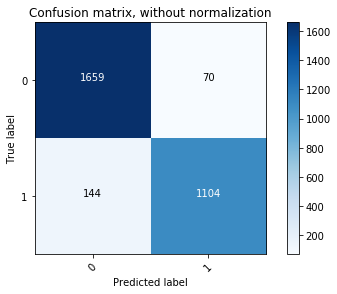

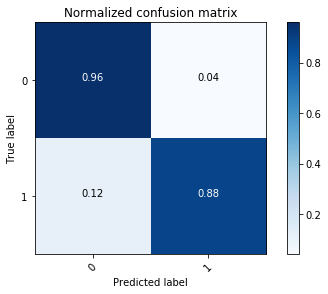

Confusion matrix, without normalization
[[168  25]
 [ 36 103]]
Normalized confusion matrix
[[0.87046632 0.12953368]
 [0.25899281 0.74100719]]


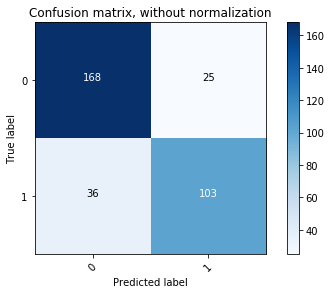

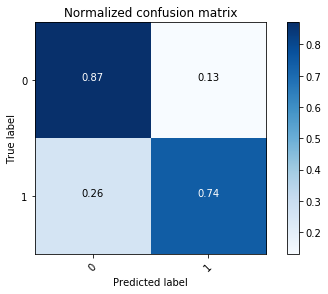

Wall time: 24min 1s


In [53]:
%%time
## VGG19, 160

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG19',
                                                    categories_count=2,
                                                    dataset_name='03_France_ByMeaningLarge_160_3dim',
                                                    image_size=160, X_train=X_train_160_FML, y_train=y_train_160_FML,
                                                    X_test=X_test_160_FML, y_test=y_test_160_FML,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
2977/2977 [==============================] - 82s 28ms/step - loss: 6.7586 - acc: 0.5798 - precision: 0.5798 - recall: 0.5798 - fmeasure: 0.5798
Epoch 2/200
2977/2977 [==============================] - 31s 10ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 3/200
2977/2977 [==============================] - 31s 10ms/step - loss: 6.7569 - acc: 0.5808 - precision: 0.5808 - recall: 0.5808 - fmeasure: 0.5808
Epoch 4/200
2977/2977 [==============================] - 31s 11ms/step - loss: 6.7461 - acc: 0.5815 - precision: 0.5815 - recall: 0.5815 - fmeasure: 0.5815
Epoch 5/200
2977/2977 [==============================] - 30s 10ms/step - loss: 8.3104 - acc: 0.4830 - precision: 0.4830 - recall: 0.4830 - fmeasure: 0.4830
Epoch 6/200
2977/2977 [==============================] - 116s 39ms/step - loss: 9.3612 - acc: 0.4192 - precision: 0.4192 - recall: 0.4192 - fmeasure: 0.4192
Epoch 7/200
2977/2977 [==============================] - 37s 12

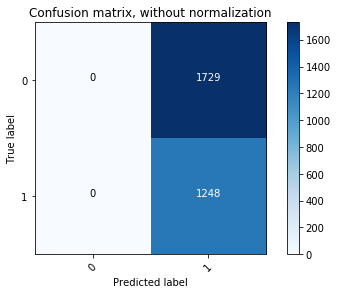

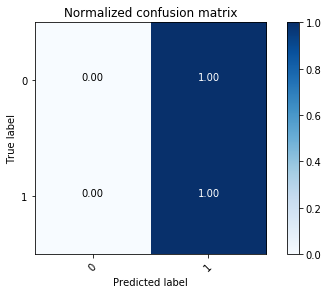

Confusion matrix, without normalization
[[  0 193]
 [  0 139]]
Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


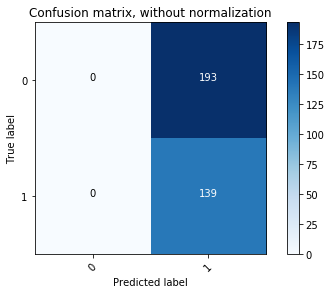

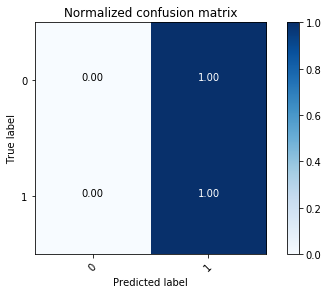

Wall time: 11min 52s


In [54]:
%%time
## VGG19, 192

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG19',
                                                    categories_count=2,
                                                    dataset_name='03_France_ByMeaningLarge_192_3dim',
                                                    image_size=192, X_train=X_train_192_FML, y_train=y_train_192_FML,
                                                    X_test=X_test_192_FML, y_test=y_test_192_FML,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)

Epoch 1/200
2977/2977 [==============================] - 44s 15ms/step - loss: 4.4096 - acc: 0.6950 - precision: 0.6950 - recall: 0.6950 - fmeasure: 0.6950
Epoch 2/200
2977/2977 [==============================] - 35s 12ms/step - loss: 3.1845 - acc: 0.7823 - precision: 0.7823 - recall: 0.7823 - fmeasure: 0.7823
Epoch 3/200
2977/2977 [==============================] - 35s 12ms/step - loss: 2.8920 - acc: 0.8052 - precision: 0.8052 - recall: 0.8052 - fmeasure: 0.8052
Epoch 4/200
2977/2977 [==============================] - 35s 12ms/step - loss: 2.6038 - acc: 0.8267 - precision: 0.8267 - recall: 0.8267 - fmeasure: 0.8267
Epoch 5/200
2977/2977 [==============================] - 35s 12ms/step - loss: 2.3978 - acc: 0.8418 - precision: 0.8418 - recall: 0.8418 - fmeasure: 0.8418
Epoch 6/200
2977/2977 [==============================] - 35s 12ms/step - loss: 2.4212 - acc: 0.8408 - precision: 0.8408 - recall: 0.8408 - fmeasure: 0.8408
Epoch 7/200
2977/2977 [==============================] - 35s 12m

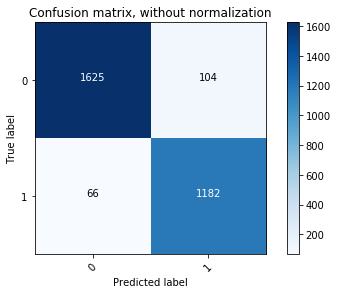

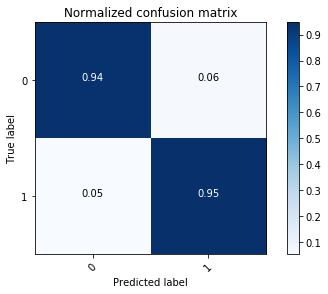

Confusion matrix, without normalization
[[153  40]
 [ 22 117]]
Normalized confusion matrix
[[0.79274611 0.20725389]
 [0.15827338 0.84172662]]


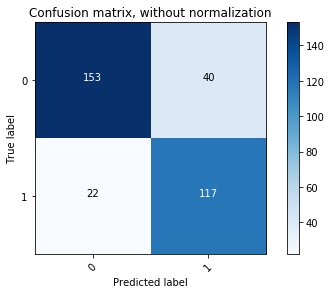

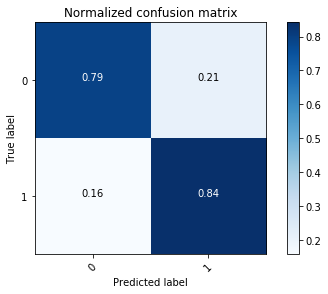

Wall time: 43min 41s


In [55]:
%%time
## VGG19, 224

parameters_df, results_df = run_net_and_write_result(parameters_df, results_df,
                                                    net_name='VGG19',
                                                    categories_count=2,
                                                    dataset_name='03_France_ByMeaningLarge_224_3dim',
                                                    image_size=224, X_train=X_train_224_FML, y_train=y_train_224_FML,
                                                    X_test=X_test_224_FML, y_test=y_test_224_FML,
                                                    batch_size_small_net=10, dense_1=0.5, dense_2=-1,
                                                    epoch_count=200)